**Student Name:** Nam Hoang  
**ID:** 370134  
**Project:** US Mortgage Loans - Probability of Default Prediction  

In [1]:
# Loading required packages for the project
import warnings; warnings.simplefilter('ignore')
import os
os.chdir('C:\\Users\\Lenovo\\Desktop\\ML1and2')
import pickle
import joblib
import numpy as np
import random
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import functools
import miceforest as mf
from scipy.stats import chi2_contingency, pointbiserialr, spearmanr, binom_test, beta
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier

# Functions:
## 1. Weighted of Evidence:

In [2]:
def woe(data_in, target, variable, bins, binning):
    
    df = data_in
    df2 = data_in[[target, variable]].rename(columns={target: 'Target', variable: 'Variable'}).dropna()
    
    if binning == 'True':
       df2['key'] = pd.qcut(df2.Variable, bins, labels=False, duplicates='drop')
    if binning == 'False':
       df2['key'] = df2.Variable
    table = pd.crosstab(df2.key, df2.Target, margins= True)
    table = table.drop(['All'], axis=0)
    table = table.rename(columns={1: 'deft', 0: 'nondeft'}).reset_index(drop=False)

    table.loc[:, 'fracdeft'] = table.deft/np.sum(table.deft)
    table.loc[:, 'fracnondeft'] = table.nondeft/np.sum(table.nondeft)

    table.loc[:, 'WOE'] = np.log(table.fracdeft/table.fracnondeft)
    table.loc[:, 'IV'] = (table.fracdeft-table.fracnondeft)*table.WOE
    
    table.rename(columns={'WOE': variable}, inplace=True)
    table=table.add_suffix('_WOE')
    table.rename(columns={table.columns[0]: 'key' }, inplace = True)
    WOE = table.iloc[:, [0,-2]]
    
    df = pd.merge(df, df2.key, right_index=True, left_index=True)
      
    outputWOE = pd.merge(df, WOE, on='key').drop(['key'], axis=1)
    outputIV = pd.DataFrame(data={'name': [variable], 'IV': table.IV_WOE.sum()})
    
    return outputWOE, outputIV

## 2. Out of sample prediction and actual values aggregation function:

In [3]:
def test_result(fit, outcome, time):
    
    fitP=pd.DataFrame(data=fit)
    outcomeP=pd.DataFrame(data=outcome)
    timeP=pd.DataFrame(data=time)
    
    if isinstance(fit, pd.Series):
        fit=fit.values
    if isinstance(outcome, pd.Series):
        outcome=outcome.values
    if isinstance(time, pd.Series):
        time=time.values
    
    df = pd.concat([fitP, outcomeP, timeP], axis=1)
    df.columns = ['fit', 'outcome', 'time']
    return df

## 3. Summary of validation of forecasting result function:

In [4]:
def validation(fit, outcome , time, model_name, continuous=False):

    plt.rcParams['figure.dpi']= 300
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.rcParams.update({'font.size': 16})
    
    fitP=pd.DataFrame(data=fit)
    outcomeP=pd.DataFrame(data=outcome)
    timeP=pd.DataFrame(data=time)
    
    if isinstance(fit, pd.Series):
        fit=fit.values
    if isinstance(outcome, pd.Series):
        outcome=outcome.values
    if isinstance(time, pd.Series):
        time=time.values
    
    data_in = pd.concat([fitP, outcomeP, timeP], axis=1)
    data_in.columns = ['fit', 'outcome', 'time']
    #means = data_in.groupby('time')[['fit', 'outcome']].mean().reset_index(drop=False)
    means = data_in.groupby('time').aggregate({'fit':'mean','outcome':'mean'}).reset_index()
  
    data_in['outcomeD']=data_in.loc[:,'outcome']    
    if continuous==True:
        data_in.loc[data_in['outcome'] >= data_in.outcome.mean(), 'outcomeD'] = 1
        data_in.loc[data_in['outcome'] <  data_in.outcome.mean(), 'outcomeD'] = 0
    
    outcomeD=data_in.loc[:,'outcomeD'].values

    roc_auc = np.nan
    binom_p = np.nan
    Jeffreys_p =  np.nan
    
    max_outcome_fit=np.maximum(max(outcome), max(fit))
    min_outcome_fit=np.minimum(min(outcome), min(fit)) 
    if min_outcome_fit>=0 and max_outcome_fit<=1:
        #roc_auc = roc_auc_score(outcomeD, fit).round(4)
        outcomeP[0] = outcomeP[0].astype(np.int64)
        roc_auc = roc_auc_score(outcomeP, fit).round(4)    
        binom_p = binom_test(sum(outcomeD), n=len(outcomeD), p= np.mean(fit), alternative='greater').round(decimals=4)
        Jeffreys_p =  beta.cdf(np.mean(fit), sum(outcomeD)+0.5, len(outcomeD)-sum(outcomeD)+0.5).round(decimals=4)

    
    the_table = [['Counts', len(outcome)],
                      ['Mean outcome', round(sum(outcome)/len(outcome),4)],
                      ['Mean fit', np.mean(fit).round(4)],
                      ['AUC', roc_auc],
                      ['MAE', mean_absolute_error(means['outcome'], means['fit']).round(decimals=4)],
                      ['MSE', mean_squared_error(means['outcome'], means['fit']).round(decimals=4)],
                      ['RMSE/ SQR(Brier score)', round(np.sqrt(((outcome-fit).dot(outcome-fit))/len(outcome)),4)],
                      ['Binomial p-value', binom_p],
                      ['Jeffreys p-value', Jeffreys_p]]
    the_table=pd.DataFrame(data=the_table)
    the_table.columns = ['Metric', 'Value']
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
 
    plt.subplot(221)
    plt.title('Summary_' + model_name)
    plt.axis('off')
    plt.axis('tight')
    test=plt.table(cellText=the_table.values, colLabels=the_table.columns, loc='center', cellLoc='center', colWidths=[0.34, 0.2])
    test.auto_set_font_size(False)
    test.set_fontsize(16) 
    test.scale(2, 1.5)
    
    plt.subplot(222)
    plt.title('Time-Series Real-Fit')
    plt.plot(means['time'],means['outcome'])
    plt.plot(means['time'],means['fit'], color='red', ls='dashed')
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Mean', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.legend(('Outcome','Fit'), loc='best', fontsize=15)
    
    plt.subplot(223)
    plt.title('Fit Histogram')
    plt.hist(fit, bins=20, histtype='bar', density=True)
    plt.xlabel('Fit', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    
    data_in['cat'] = pd.qcut(data_in.fit, 10, labels=False, duplicates='drop')
    real_fit = data_in.groupby('cat').aggregate({'fit':'mean','outcome':'mean'})
    #real_fit = data_in.groupby('cat')[['fit', 'outcome']].mean()
    mpv=real_fit.fit.values
    fop=real_fit.outcome.values
    
    maximum=np.maximum(max(fop), max(mpv))       
    maximum=np.ceil(maximum*100)/100
    minimum=np.minimum(min(fop), min(mpv))
    minimum=np.floor(minimum*100)/100
    
    plt.subplot(224)
    plt.title('Calibration Curve')
    plt.plot(mpv, fop, marker='.', linestyle='', markersize=18)
    plt.plot([minimum,maximum],[minimum,maximum], linestyle='--', color='gray')
    plt.xlim((minimum,maximum))
    plt.ylim((minimum,maximum))
    plt.xlabel('Mean fit', fontsize=15)
    plt.ylabel('Mean outcome', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.show()

# Data Import:

In [5]:
data = pd.read_csv('dcr.csv')
data_loan_id =  data['id'].unique() # 50,000 loans
data['default_time'].value_counts(normalize = True)*100 # 97.56/2.44 ratio

0    97.564937
1     2.435063
Name: default_time, dtype: float64

# List of all key variables:
* **id:** borrower id
* **time:** time stamp of observation
* **orig_time:** time stamp for origination
* **first_time:** time stamp for first observation
* **mat_time:** time stamp for maturity
* **res_time:** time stamp for resolution
* **balance_time:** outstanding balance at observation time
* **LTV_time:** loan to value ratio at observation time, in %
* **interest_rate_time:** interest rate at observation time, in %
* **rate_time:** risk-free rate
* **hpi_time:** house price index at observation time, base year=100
* **gdp_time:** GDP growth at observation time, in %
* **uer_time:** unemployment rate at observation time, in %
* **REtype_CO_orig_time:** real estate type condominium: 1, otherwise: 0
* **REtype_PU_orig_time:** real estate type planned urban developments: 1, otherwise: 0
* **REtype_SF_orig_time:** single family home: 1, otherwise: 0
* **investor_orig_time:** investor borrower: 1, otherwise: 0
* **balance_orig_time:** outstanding balance at origination time
* **FICO_orig_time:** FICO score at origination time, in %
* **LTV_orig_time:** loan to value ratio at origination time, in %
* **Interest_Rate_orig_time:** interest rate at origination time, in %
* **state_orig_time:** US state in which the property is located
* **hpi_orig_time:** house price index at observation time, base year=100
* **default_time:** default observation at observation time
* **payoff_time:** payoff observation at observation time
* **status_time:** default (1), payoff (2) and non-default/non-payoff (0) observation at observation time
* **lgd_time:** LGD assuming no discounting of cash flows
* **recovery_res:** sum of all cash flows received during resolution period

# Feature Engineering:
## 1. Exclusion of unecessary variables:

In [6]:
id_col = data['id']
data.drop(columns=['id', 'res_time', 'payoff_time', 'status_time', 'lgd_time', 'recovery_res'], inplace=True)

* **id, payoff_time, status_time** are dropped due to being irrelevant to PD modelling
* **lgd_time** and **recovery_res** are dropped as they are related to LGD component

## 2. One-hot-enconding categorical variable:

In [7]:
data = pd.concat([data, pd.get_dummies(data["state_orig_time"],prefix="state")], axis=1)
data.drop(columns=['state_orig_time'], inplace=True) # remove the original column after one-hot encoding

## 3. Feature Creation:

In [8]:
data['balance_orig_time'] = data['balance_orig_time'].replace(0, 1)

Some of the derived economic features need balance at origination to be different than 0 to yield finite values  
Mortgage borrowers make **annuity** payments (fixed). **Annuities** are calculated as follows:

In [9]:
data.loc[:, 'annuity'] = ((data.loc[:,'interest_rate_time']/(100*4))*data.loc[:,'balance_orig_time'])/(1-(1+data.loc[:,'interest_rate_time']/(100*4))**(-(data.loc[:,'mat_time']-data.loc[:,'orig_time'])))

**Scheduled balance** is computed as the difference between future value of the loan balance at origination and less future value of all annuity payments made

In [10]:
data.loc[:,'balance_scheduled_time']  = data.loc[:,'balance_orig_time']*(1+data.loc[:,'interest_rate_time']/(100*4))**(data.loc[:,'time']-data.loc[:,'orig_time'])-data.loc[:,'annuity']*((1+data.loc[:,'interest_rate_time']/(100*4))**(data.loc[:,'time']-data.loc[:,'orig_time'])-1)/(data.loc[:,'interest_rate_time']/(100*4))

**Property  price** at origination. It is derived by dividing balance at origination with LTV at origination

In [11]:
data.loc[:,'property_orig_time'] = data.loc[:,'balance_orig_time']/(data.loc[:,'LTV_orig_time']/100)

**cep** is an acronym for cummulative excess payment. It is a function of scheduled balance minus actual balance over property value cep is an approximation of the liquidity of borrowers

In [12]:
data.loc[:,'cep_time']= (data.loc[:,'balance_scheduled_time'] - data.loc[:,'balance_time'])/data.loc[:,'property_orig_time']

**Age** and **time till maturity** variables are created as follows:

In [13]:
data.loc[:,'age'] = (data.loc[:,'time']-data.loc[:,'first_time']+1)
data.loc[:,'time_till_maturity'] = (data.loc[:,'mat_time']-data.loc[:,'time']+1)

**Current Equity** variable is created as follows:

In [14]:
data.loc[:, 'equity_time'] = 1 - (data.loc[:, 'LTV_time']/100)

Create lagged macro variables (**GDP** and **Unemployment Rate**):

In [15]:
econ_df = data.groupby('time')['uer_time', 'gdp_time'].max().reset_index (drop=False)
    
econ_df['gdp_time_lag_1'] = econ_df['gdp_time'].shift(1)
econ_df['gdp_time_lag_1'].iloc[0] = econ_df['gdp_time'].iloc[0]
econ_df['gdp_time_lag_2'] = econ_df['gdp_time'].shift(2)
econ_df['gdp_time_lag_2'].iloc[0:2] = econ_df['gdp_time'].iloc[0]

econ_df['uer_time_lag_1'] = econ_df['uer_time'].shift(1)
econ_df['uer_time_lag_1'].iloc[0] = econ_df['uer_time'].iloc[0]
econ_df['uer_time_lag_2'] = econ_df['uer_time'].shift(2)
econ_df['uer_time_lag_2'].iloc[0:2] = econ_df['uer_time'].iloc[0]

econ_df.drop(columns=['uer_time','gdp_time'], inplace=True)

data = pd.merge(data, econ_df, on='time', how='left')

## 4. Missing data treatment:
Examine for **NaN** values in the dataset:

In [16]:
nan_columns = data.columns[data.isna().any()]
print("Columns with NaN values:")
print(nan_columns)
nan_values = data.isna().sum()
nan_values

Columns with NaN values:
Index(['LTV_time', 'annuity', 'balance_scheduled_time', 'cep_time',
       'equity_time'],
      dtype='object')


time                0
orig_time           0
first_time          0
mat_time            0
balance_time        0
                 ... 
equity_time       270
gdp_time_lag_1      0
gdp_time_lag_2      0
uer_time_lag_1      0
uer_time_lag_2      0
Length: 85, dtype: int64

Examine for **inf** values:

In [17]:
inf_columns = data.columns[np.isinf(data).any()]
inf_rows = data.index[np.isinf(data).any(axis=1)]
inf_df = data.loc[inf_rows]
inf_df

time  orig_time  first_time  mat_time  balance_time  LTV_time  \
153091    18         18          18        18        511.44  1.135836   

        interest_rate_time  rate_time  hpi_time  gdp_time  ...  \
153091               11.99       4.14    186.91  3.370511  ...   

        balance_scheduled_time  property_orig_time  cep_time  age  \
153091                     NaN        45027.624309       NaN    1   

        time_till_maturity  equity_time  gdp_time_lag_1  gdp_time_lag_2  \
153091                   1     0.988642        4.126684        4.320114   

        uer_time_lag_1  uer_time_lag_2  
153091             5.6             5.7  

[1 rows x 85 columns]

Replace **inf** values with **NaN**

In [18]:
data['annuity'] = data['annuity'].replace([np.inf, -np.inf], np.nan)

We employ **MICE** (Multivariate Imputation with Chain-Equation) algorithm to fill in missing values. The reason why this technique is chosen over single variate approach (such as linear interpolation, spline, etc.) is because the algorithm uses multiple imputation techniques to fill in the missing data and then combines the results from multiple imputations to produce a final imputed dataset. The goal of MICE is to preserve the relationship between variables in the original data and to reduce the bias introduced by imputing missing values. For more information, please visit this [link](https://medium.com/@brijesh_soni/topic-9-mice-or-multivariate-imputation-with-chain-equation-f8fd435ca91#:~:text=MICE%20stands%20for%20Multivariate%20Imputation,produce%20a%20final%20imputed%20dataset.).

In [19]:
kds = mf.ImputationKernel(
  data,
  save_all_iterations=True,
  random_state=100
)
kds.mice(5) # Run the MICE algorithm for 5 iterations - the more iteration the more accurate imputation. Recommended number of iteration is 5.
data_imputed = kds.complete_data()

Return the completed dataset and check for any residual of NaN values after imputation for completeness

In [20]:
data_imputed = kds.complete_data()
nan_columns = data_imputed.columns[data_imputed.isna().any()]
nan_columns

Index([], dtype='object')

## 4. Outlier Detection:
The continuous variables below are selected to check for outliers:

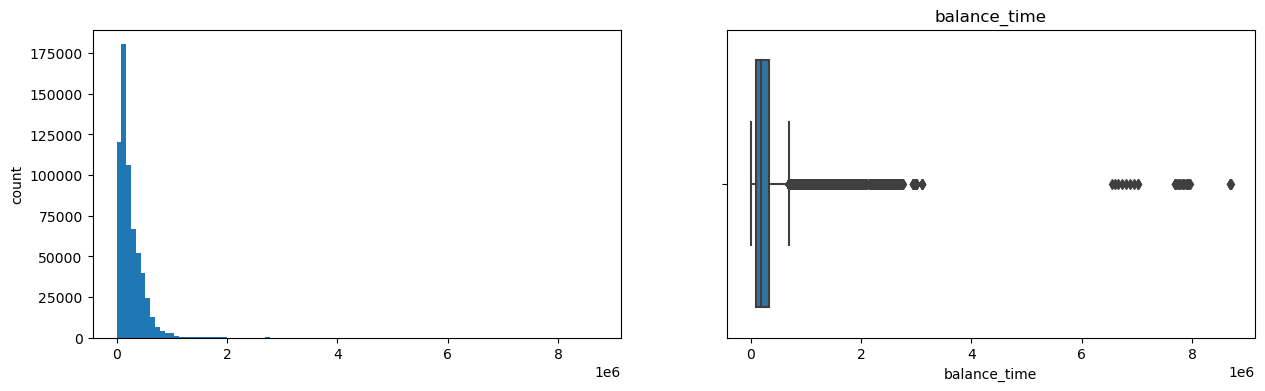

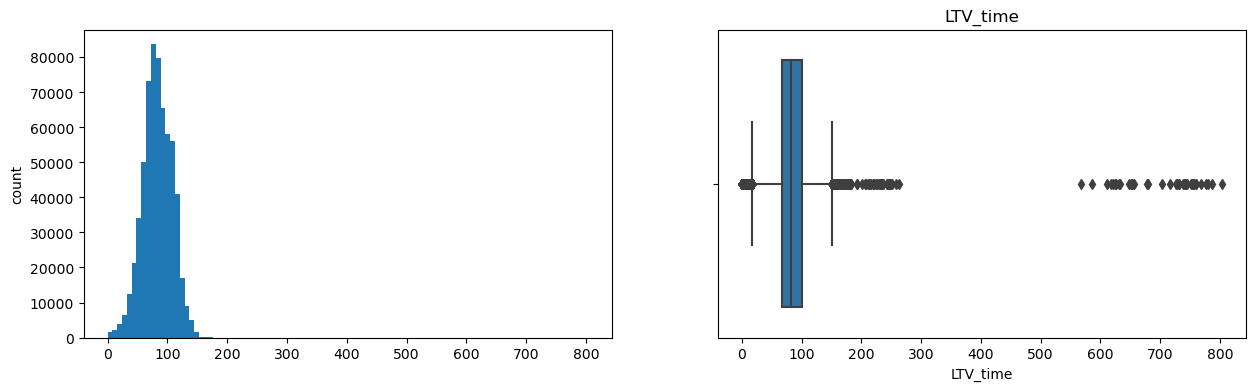

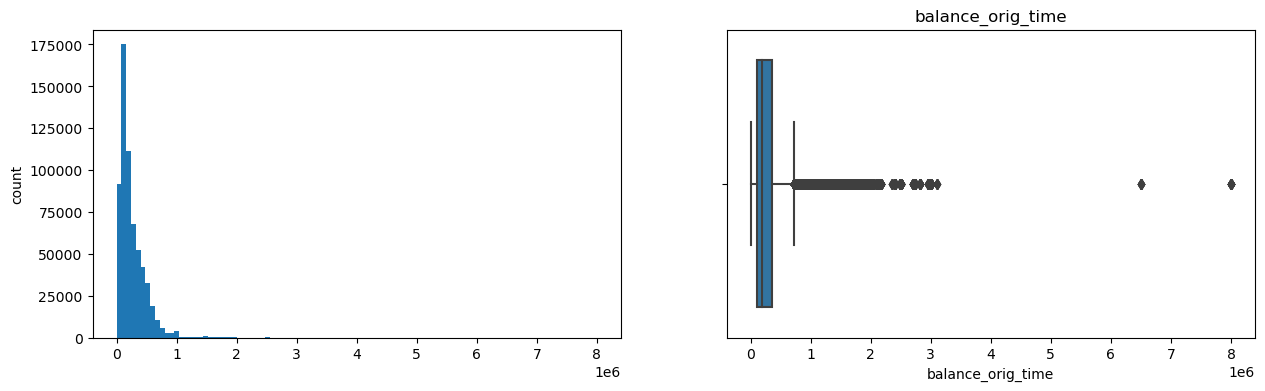

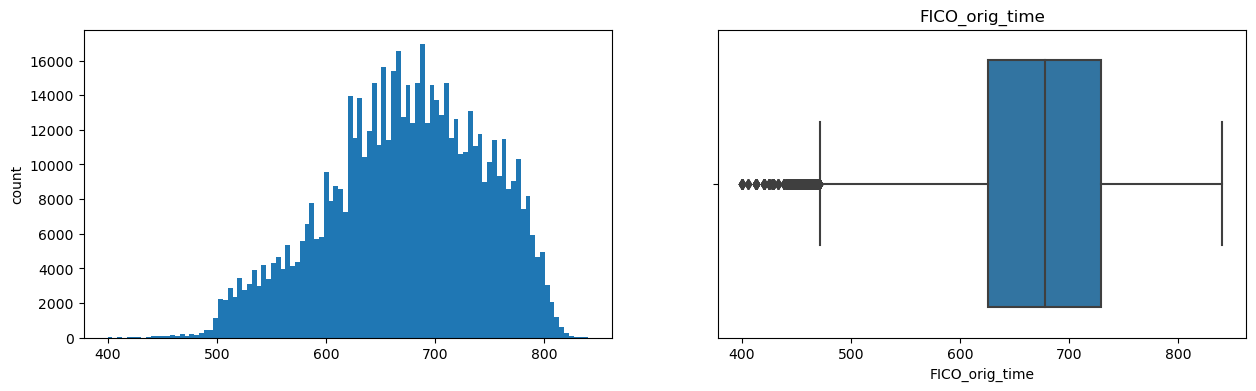

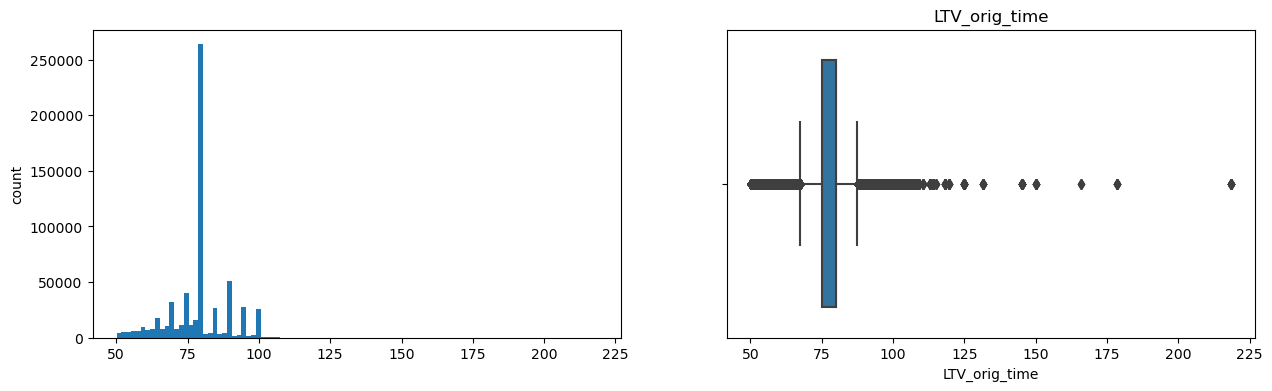

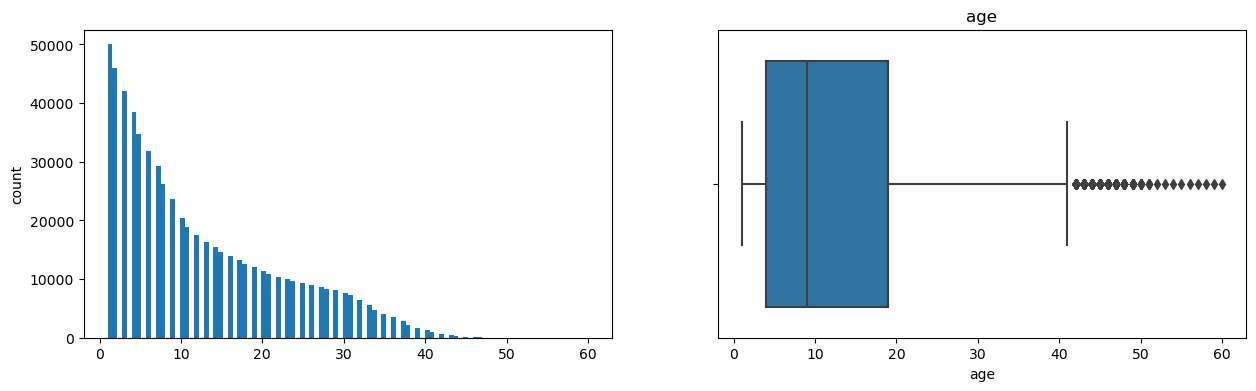

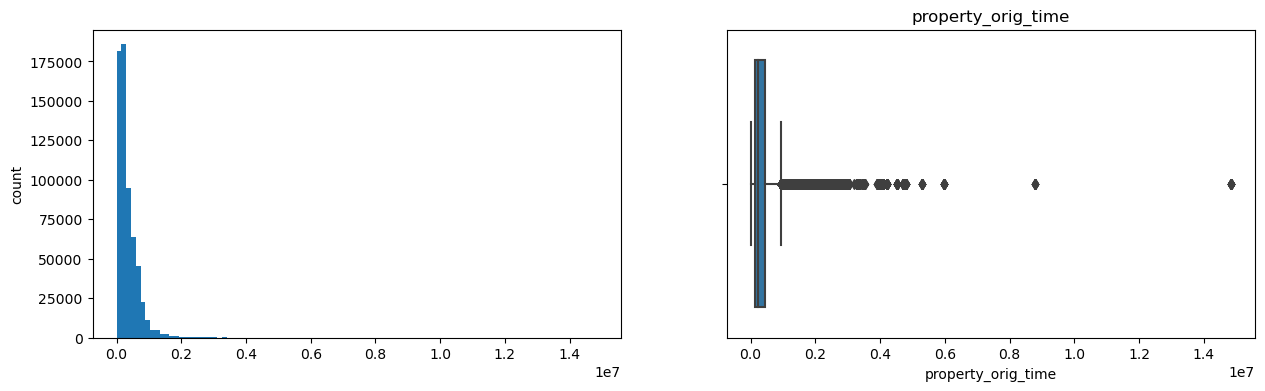

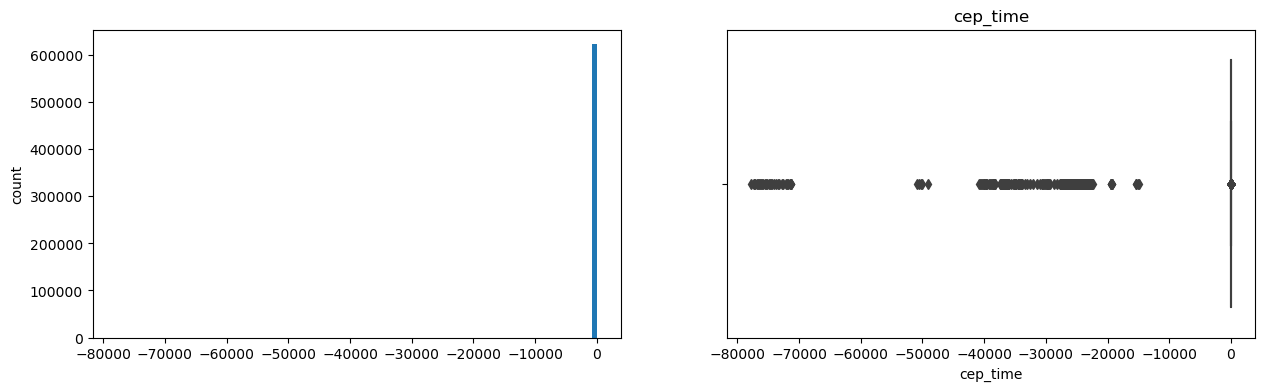

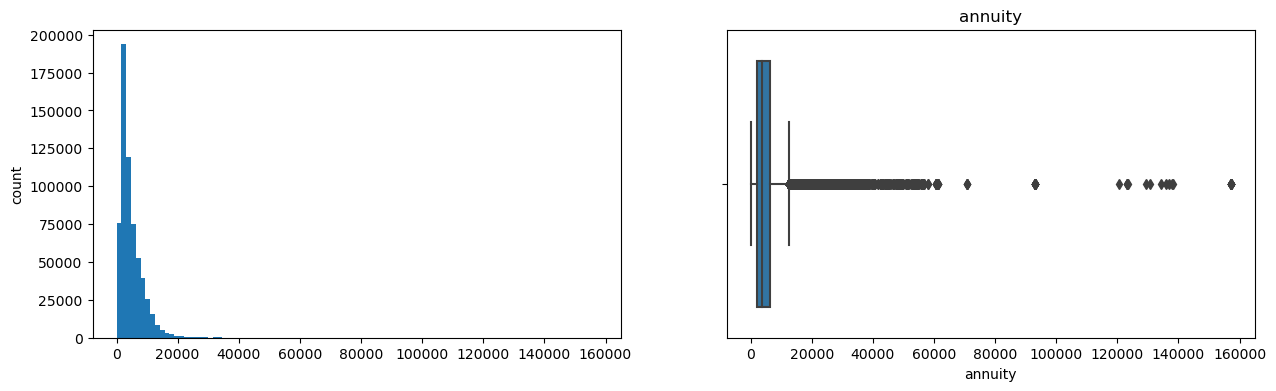

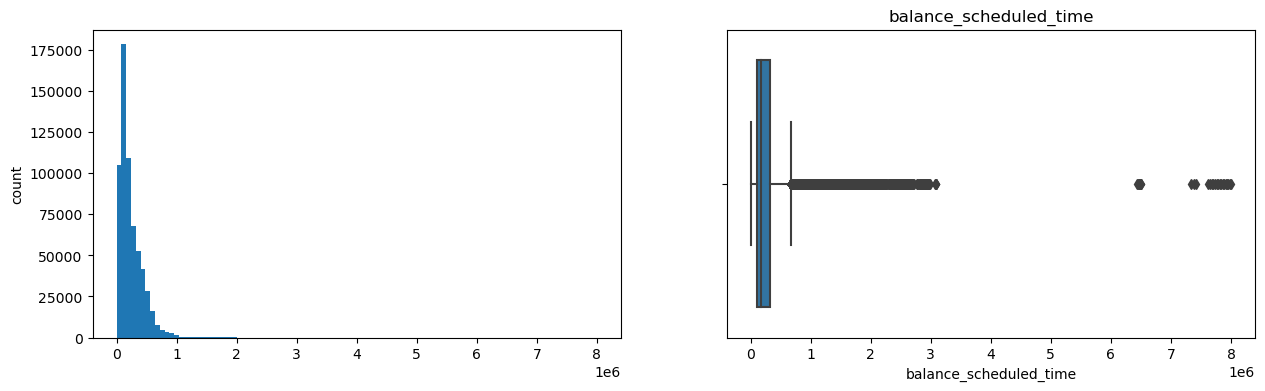

In [21]:
cols = ['balance_time', 'LTV_time', 'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'age'
        , 'property_orig_time', 'cep_time', 'annuity', 'balance_scheduled_time']

for col in cols:
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    data[col].hist(grid=False, bins=100)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.title(col)
    plt.show()
    

### Observation:
* Lognormal distribution is detected for several variables such as **balance_time, annuity, etc**. Due to the requirement of models selected for this project does not impose normally distributed explanatory variables, we opt for not transforming them to achieve distribution normality.
* Outliers are detected for the entire selected variables. This suggests data scaling technique that is robust to outliers.  

Perform feature clipping on **age** variable as there are only a few outliers beyond 40:

In [22]:
data_imputed.loc[data['age'] >= 40, 'age'] = 40

## 5. Create 5 different dataset (without replacement) from the original dataset:

In [23]:
data_imputed = pd.concat([data_imputed, id_col], axis=1)
remaining_loans = data_loan_id.copy()
remaining_loans = remaining_loans.tolist()
combination_size = 10000
dataset = []
random.seed(42)

while len(remaining_loans) != 0:
    current_combination = random.sample(remaining_loans, combination_size)       
    sub_dataset = data_imputed[data_imputed['id'].isin(current_combination)]
    dataset.append(sub_dataset)
    remaining_loans = [x for x in remaining_loans if x not in current_combination]
    print(len(remaining_loans))

40000
30000
20000
10000
0


Checking for the negative/positive class ratio of each newly created dataset:

In [24]:
for i in range(len(dataset)):
    dataset[i].reset_index(inplace = True)
    dataset[i].drop(['id', 'index'], axis = 1, inplace = True)
    print(dataset[i]['default_time'].value_counts(normalize = True)*100)

0    97.629888
1     2.370112
Name: default_time, dtype: float64
0    97.641355
1     2.358645
Name: default_time, dtype: float64
0    97.529093
1     2.470907
Name: default_time, dtype: float64
0    97.547102
1     2.452898
Name: default_time, dtype: float64
0    97.474563
1     2.525437
Name: default_time, dtype: float64


As seen from each dataset, the ratio **97.5/2.5** is well preserved  
### Create Training/Testing split for each dataset:

In [25]:
train_test_dict = {}

for i in range(len(dataset)):    
    X_train, X_test, y_train, y_test = train_test_split(dataset[i].drop(['default_time'], axis = 1), dataset[i][['default_time']], 
                                                        test_size=0.2, random_state=4)
    train_test_dict[f'X_train_{i}'] = X_train
    train_test_dict[f'X_test_{i}'] = X_test
    train_test_dict[f'y_train_{i}'] = y_train
    train_test_dict[f'y_test_{i}'] = y_test
    

X_train_df = pd.concat([train_test_dict['X_train_0'], train_test_dict['X_train_1'],
                      train_test_dict['X_train_2'], train_test_dict['X_train_3'], train_test_dict['X_train_4']], 
                     ignore_index=True)

y_train_df = pd.concat([train_test_dict['y_train_0'], train_test_dict['y_train_1'],
                      train_test_dict['y_train_2'], train_test_dict['y_train_3'], train_test_dict['y_train_4']], 
                     ignore_index=True)

## 6. Feature Selection:
Since we don't want to repeat feature selection on each dataset, we merge all the **training** datasets into 1 dataframe. The reason why we could perform such data merging is because each dataset is similar to each other in terms of negative/positive class ratio. Moreover, we would like to select features that has better generalization so performing feature selection on a combined training dataset is the way to achieve it.
### Selection of dichomotous explanatory variables:

In [26]:
df_dichotomous_variables = X_train_df[['REtype_CO_orig_time','REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time',
                                        'state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC',
                                        'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
                                        'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN',
                                        'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ',
                                        'state_NM', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_PR', 'state_RI',
                                        'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
                                        'state_WA', 'state_WI', 'state_WV', 'state_WY']]

df_dichotomous_variables.reset_index(inplace = True)
df_dichotomous_variables.drop(['index'], axis = 1, inplace = True)
combined_dichotomous = pd.concat([y_train_df, df_dichotomous_variables], axis=1)
chi_squared_df = pd.DataFrame(columns=['Variable', 'Chi2', 'P-value'])
for column in combined_dichotomous.columns:
    if column != 'default_time':
            # Create a contingency table
        contingency_table = pd.crosstab(combined_dichotomous['default_time'], combined_dichotomous[column])
            
            # Perform the chi-square test
        chi2, p, _, _ = chi2_contingency(contingency_table)
            
            # Store results in the DataFrame
        chi_squared_df = chi_squared_df.append({'Variable': column, 'Chi2': chi2, 'P-value': format(p, '.3f')}, ignore_index=True)

print(chi_squared_df)

               Variable        Chi2 P-value
0   REtype_CO_orig_time    0.105037   0.746
1   REtype_PU_orig_time    0.147407   0.701
2   REtype_SF_orig_time    6.392237   0.011
3    investor_orig_time    6.883044   0.009
4              state_AK    0.257697   0.612
5              state_AL    5.617397   0.018
6              state_AR    2.578158   0.108
7              state_AZ   43.340471   0.000
8              state_CA   24.522871   0.000
9              state_CO   10.436720   0.001
10             state_CT    3.447119   0.063
11             state_DC    2.200095   0.138
12             state_DE    9.700360   0.002
13             state_FL  253.516625   0.000
14             state_GA   10.408619   0.001
15             state_HI    0.527859   0.468
16             state_IA    3.199420   0.074
17             state_ID    0.113079   0.737
18             state_IL    3.359235   0.067
19             state_IN    1.079400   0.299
20             state_KS    7.016103   0.008
21             state_KY    0.288

We exclude **REtype_CO_orig_time** and **REtype_PU_orig_time** due to statistical insignificance. As for **state** variables, since majority of them are statistically significant, we will keep them to allow our model to reflect regional effect of PD. By allowing state variable in our model, we also address another <mark>**weakness**</mark> of our model which use *country-level GDP/Unemployment Rate instead of corresponding state/regional macros.*  
### Selection of continuous variables:

In [27]:
df_continuous_variables = X_train_df[['balance_time', 'LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'uer_time',
                                   'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time', 'annuity', 'balance_orig_time',
                                   'balance_scheduled_time', 'property_orig_time', 'cep_time', 'age', 'time_till_maturity', 'mat_time',
                                   'equity_time', 'gdp_time_lag_1', 'gdp_time_lag_2', 'uer_time_lag_1', 'uer_time_lag_2']]

combined_continuous = pd.concat([y_train_df, df_continuous_variables], axis=1)

point_biserial_df = pd.DataFrame(columns=['Variable', 'PointBiserialCorr', 'P-value'])

for column in combined_continuous.columns:
    if column != 'default_time':
        # Calculate point-biserial correlation
        corr, p_value = pointbiserialr(combined_continuous['default_time'], combined_continuous[column])
        
        # Store results in the DataFrame
        point_biserial_df = point_biserial_df.append({'Variable': column, 'PointBiserialCorr': corr, 'P-value': format(p_value, '.3f')}, ignore_index=True)

# Display the results
print(point_biserial_df)

                   Variable  PointBiserialCorr P-value
0              balance_time           0.004650   0.001
1                  LTV_time           0.088422   0.000
2        interest_rate_time           0.063583   0.000
3                 rate_time           0.031581   0.000
4                  hpi_time          -0.043195   0.000
5                  gdp_time          -0.067445   0.000
6                  uer_time           0.028151   0.000
7            FICO_orig_time          -0.054157   0.000
8             LTV_orig_time           0.031997   0.000
9   Interest_Rate_orig_time           0.012932   0.000
10            hpi_orig_time           0.052895   0.000
11                  annuity           0.013914   0.000
12        balance_orig_time          -0.002222   0.117
13   balance_scheduled_time           0.001947   0.169
14       property_orig_time          -0.009277   0.000
15                 cep_time           0.000673   0.635
16                      age          -0.025278   0.000
17       t

We exclude **balance_orig_time, balance_scheduled_time, cep_time** and **uer_time_lag_2** due to statistical insignificance.  
We also make use of **Weight of Evidence** to further check if additional continuous variables can be excluded:

In [29]:
woe_df = pd.DataFrame(columns=['Variable', 'Information_Value'])

for column in combined_continuous.columns:
    if column != 'default_time':
        # Calculate point-biserial correlation
        _, IV = woe(data_in = combined_continuous, target = 'default_time', variable = column, bins = 10, binning = 'True')
        
        # Store results in the DataFrame
        woe_df = woe_df.append({'Variable': IV['name'][0], 'Information_Value': IV['IV'][0]}, ignore_index=True)

woe_df = woe_df.sort_values(by='Information_Value', ascending=False)

woe_df

Variable  Information_Value
1                  LTV_time           0.407645
19              equity_time           0.407644
18                 mat_time           0.274380
2        interest_rate_time           0.262552
9   Interest_Rate_orig_time           0.239320
17       time_till_maturity           0.233629
10            hpi_orig_time           0.225608
5                  gdp_time           0.211054
20           gdp_time_lag_1           0.198232
15                 cep_time           0.185389
21           gdp_time_lag_2           0.178438
16                      age           0.164443
3                 rate_time           0.163120
7            FICO_orig_time           0.160499
4                  hpi_time           0.111681
6                  uer_time           0.095009
22           uer_time_lag_1           0.079644
8             LTV_orig_time           0.074721
23           uer_time_lag_2           0.073197
11                  annuity           0.044516
14       property_orig_time           0.042825
0              balance_time           0.038297
13   balance_scheduled_time           0.036222
12        balance_orig_time           0.033264

#### Selection rule:
* ***Less than 0.02:*** Information Value (IV) is too low to support inclusion of feature in the model;
* ***Between 0.02 and 0.1:*** IV suggests a weak relation between a feature and default → consider exclusion of feature in the model;
* ***Between 0.1 and 0.3:*** IV suggests a moderate relation between a feature and default → consider inclusion of feature in the model;
* ***Over 0.3:*** IV suggests a strong relation between a feature and default → inclusion of feature.  

We further remove the following variables due to weak relationship with default (IV < 0.1):
- **uer_time**
- **uer_time_lag_1**
- **property_orig_time**
- **LTV_orig_time**
- **annuity**
- **balance_time**

Checking **correlation** among remaining continuous variables to further exclude highly correlated variables:  

**Selection rules:**
* Favor current variable over at-origination variable and
* Favor variable with higher Information Value (based on weight of evidence ranking)

In [31]:
continuous_variables = ['LTV_time', 'interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'FICO_orig_time', 'Interest_Rate_orig_time', 
                        'hpi_orig_time', 'age', 'time_till_maturity', 'mat_time', 'equity_time', 'gdp_time_lag_1', 'gdp_time_lag_2', 
                        'uer_time_lag_1']
df_continuous_variables_after_selection = X_train[continuous_variables]
correlation_matrix, p_values = spearmanr(df_continuous_variables_after_selection, nan_policy='omit')     
correlation_df = pd.DataFrame(correlation_matrix, index=continuous_variables, columns=continuous_variables)
correlation_df

LTV_time  interest_rate_time  rate_time  hpi_time  \
LTV_time                 1.000000            0.032150   0.344094 -0.484790   
interest_rate_time       0.032150            1.000000   0.217956  0.072331   
rate_time                0.344094            0.217956   1.000000 -0.192022   
hpi_time                -0.484790            0.072331  -0.192022  1.000000   
gdp_time                -0.389703           -0.085439  -0.215852  0.418346   
FICO_orig_time           0.012204           -0.455105  -0.096061 -0.024051   
Interest_Rate_orig_time  0.087602            0.534955   0.204995 -0.081476   
hpi_orig_time            0.668033            0.005886   0.563523 -0.099838   
age                      0.181746           -0.296974  -0.003935 -0.575174   
time_till_maturity       0.078138            0.178922   0.051468  0.434679   
mat_time                 0.669102            0.000896   0.434138 -0.149566   
equity_time             -0.999997           -0.032140  -0.344088  0.484804   
gdp_time_lag_1          -0.409922           -0.051191  -0.224011  0.490204   
gdp_time_lag_2          -0.423845           -0.016580  -0.224620  0.544228   
uer_time_lag_1           0.381161           -0.237892   0.044399 -0.768010   

                         gdp_time  FICO_orig_time  Interest_Rate_orig_time  \
LTV_time                -0.389703        0.012204                 0.087602   
interest_rate_time      -0.085439       -0.455105                 0.534955   
rate_time               -0.215852       -0.096061                 0.204995   
hpi_time                 0.418346       -0.024051                -0.081476   
gdp_time                 1.000000       -0.040326                -0.100665   
FICO_orig_time          -0.040326        1.000000                -0.235060   
Interest_Rate_orig_time -0.100665       -0.235060                 1.000000   
hpi_orig_time           -0.288435        0.053309                 0.071963   
age                     -0.205749        0.117219                -0.041035   
time_till_maturity       0.110649       -0.055398                -0.050507   
mat_time                -0.282580        0.011898                 0.049651   
equity_time              0.389712       -0.012218                -0.087602   
gdp_time_lag_1           0.844788       -0.042103                -0.095400   
gdp_time_lag_2           0.662720       -0.046166                -0.088453   
uer_time_lag_1          -0.074509        0.063016                -0.017816   

                         hpi_orig_time       age  time_till_maturity  \
LTV_time                      0.668033  0.181746            0.078138   
interest_rate_time            0.005886 -0.296974            0.178922   
rate_time                     0.563523 -0.003935            0.051468   
hpi_time                     -0.099838 -0.575174            0.434679   
gdp_time                     -0.288435 -0.205749            0.110649   
FICO_orig_time                0.053309  0.117219           -0.055398   
Interest_Rate_orig_time       0.071963 -0.041035           -0.050507   
hpi_orig_time                 1.000000 -0.009376            0.225217   
age                          -0.009376  1.000000           -0.740790   
time_till_maturity            0.225217 -0.740790            1.000000   
mat_time                      0.768730 -0.026225            0.367904   
equity_time                  -0.668047 -0.181754           -0.078147   
gdp_time_lag_1               -0.291698 -0.295315            0.188615   
gdp_time_lag_2               -0.288353 -0.379993            0.255322   
uer_time_lag_1                0.053952  0.643574           -0.518149   

                         mat_time  equity_time  gdp_time_lag_1  \
LTV_time                 0.669102    -0.999997       -0.409922   
interest_rate_time       0.000896    -0.032140       -0.051191   
rate_time                0.434138    -0.344088       -0.224011   
hpi_time                -0.149566     0.484804        0.490204   
gdp_time                -0.282580     0.3897

* Almost perfect correlation between **LTV_time** and **equity_time** => discard **quity_time** due to lower IV compared to LTV_time
* High correlation between **interest_rate_time** and **Interest_Rate_orig_time** => discard **Interest_Rate_orig_time** due to having lower IV and being at-origination variable
* Discard **gdp_time_lag_1** and **gdp_time_lag_2** due to high correlation with **gdp_time** and lower IV

## 7. Data Exploration on Selected Variables:

This step is done to check if any meaningful relationship can be drawn from the selected variables in order to form new variables through:
* Interaction among features
* Transforming features

In [32]:
drop_variables = ['REtype_CO_orig_time', 'REtype_PU_orig_time','balance_time', 'balance_scheduled_time', 'balance_orig_time',
                  'LTV_orig_time', 'annuity', 'uer_time_lag_2', 'uer_time', 'property_orig_time', 'time',  'uer_time_lag_1',
                  'orig_time', 'first_time', 'gdp_time_lag_1', 'gdp_time_lag_2', 'Interest_Rate_orig_time', 
                  'annuity', 'cep_time', 'equity_time', 'orig_time', 'first_time', 'time']

selected_cont_variables = ['interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'FICO_orig_time',
                        'hpi_orig_time', 'age', 'time_till_maturity', 'mat_time', 'LTV_time']

selected_dichotomous_variables = ['state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_WA', 'state_WI',
                                  'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
                                  'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN',
                                  'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ',
                                  'state_NM', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_PR', 'state_RI',
                                  'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT', 'state_WV',
                                  'state_WY', 'state_CT', 'state_DC', 'state_NV', 'state_VI', 'REtype_SF_orig_time', 'investor_orig_time']

train_df = pd.concat([X_train_df, y_train_df], axis = 1)
train_cont_df = train_df[['interest_rate_time', 'rate_time', 'hpi_time', 'gdp_time', 'FICO_orig_time',
                        'hpi_orig_time', 'age', 'time_till_maturity', 'mat_time', 'LTV_time', 'default_time']]
X_train_selected = X_train_df.drop(drop_variables, axis = 1)

Plot distribution of default on selected continuous variables:

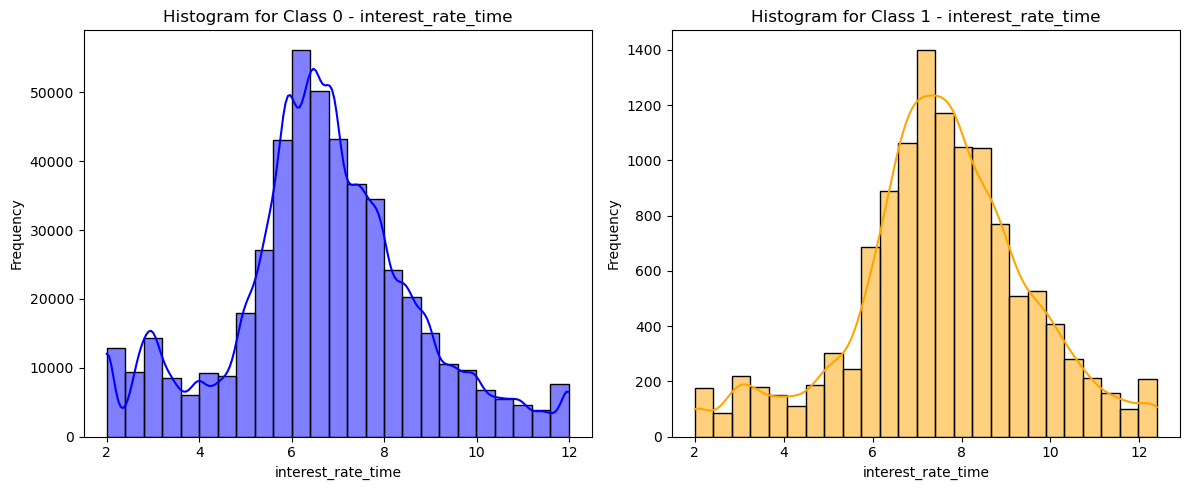

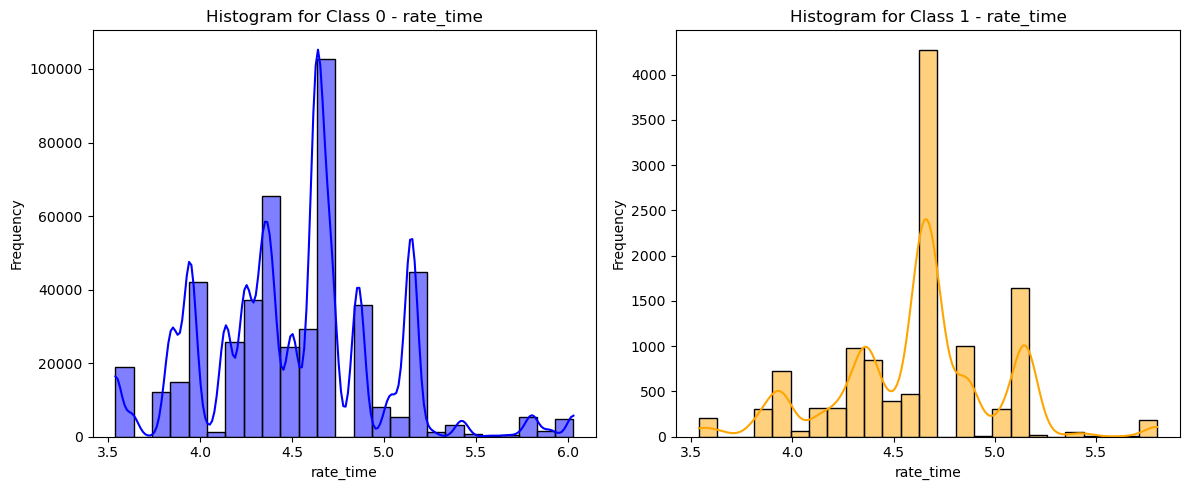

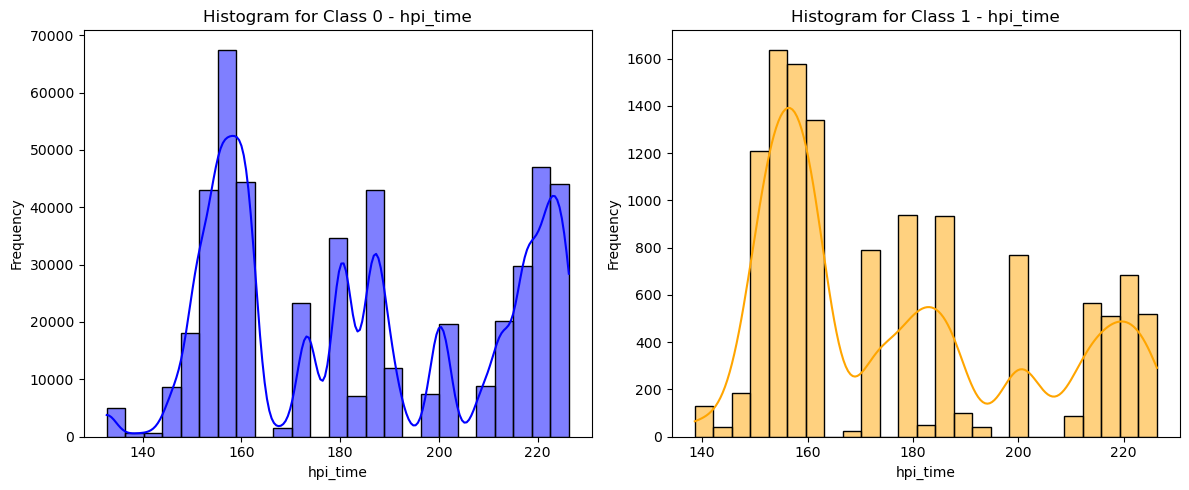

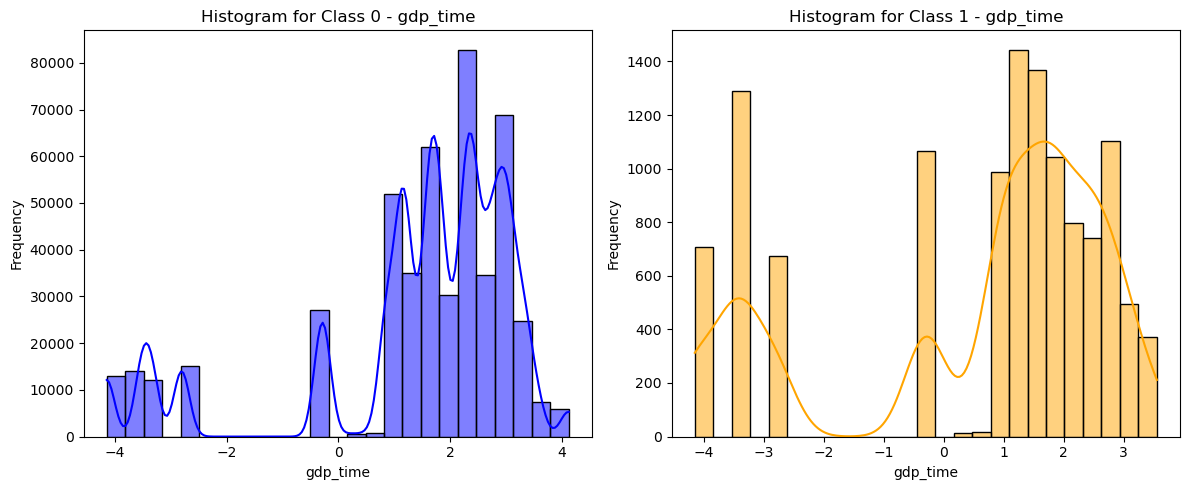

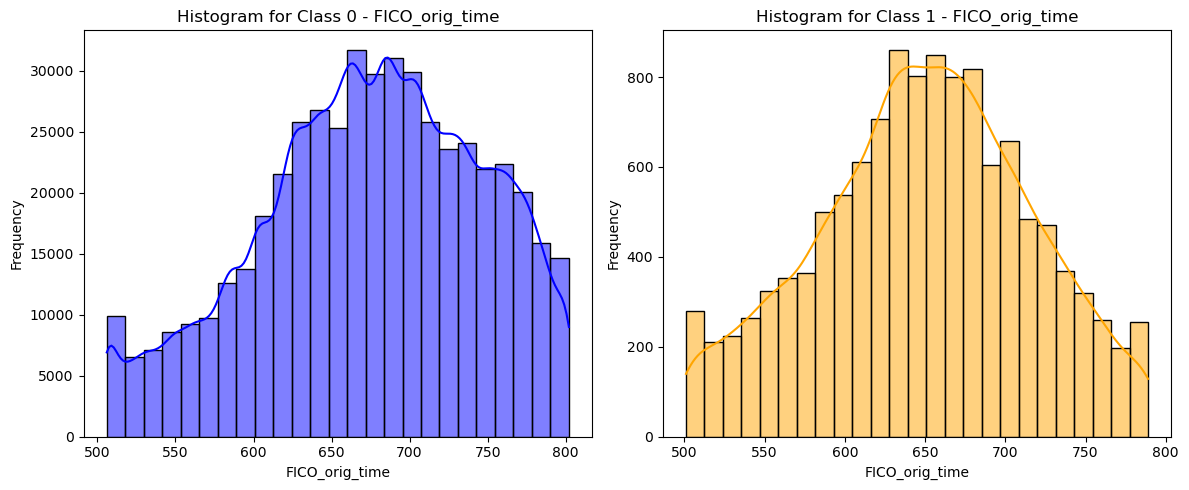

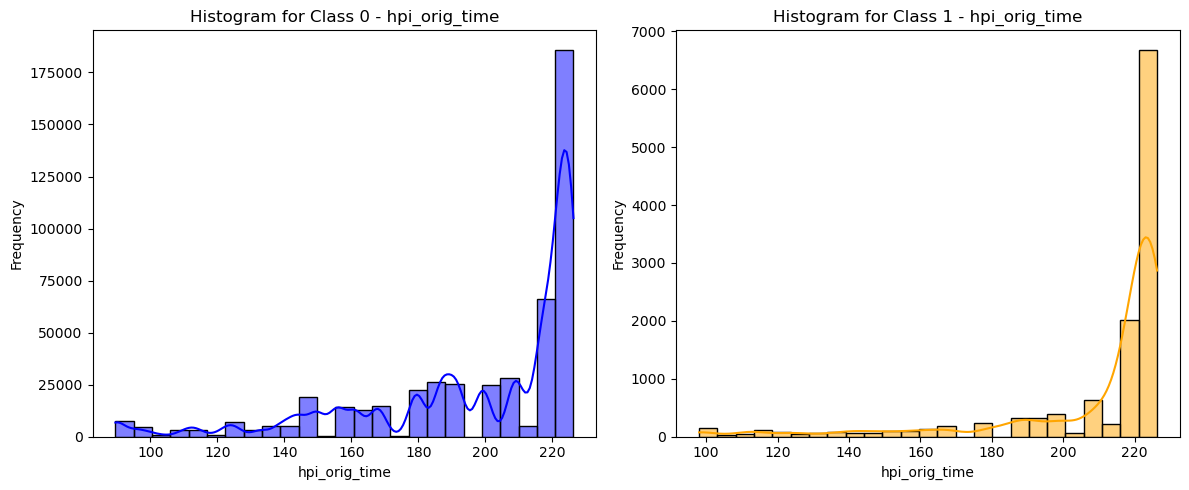

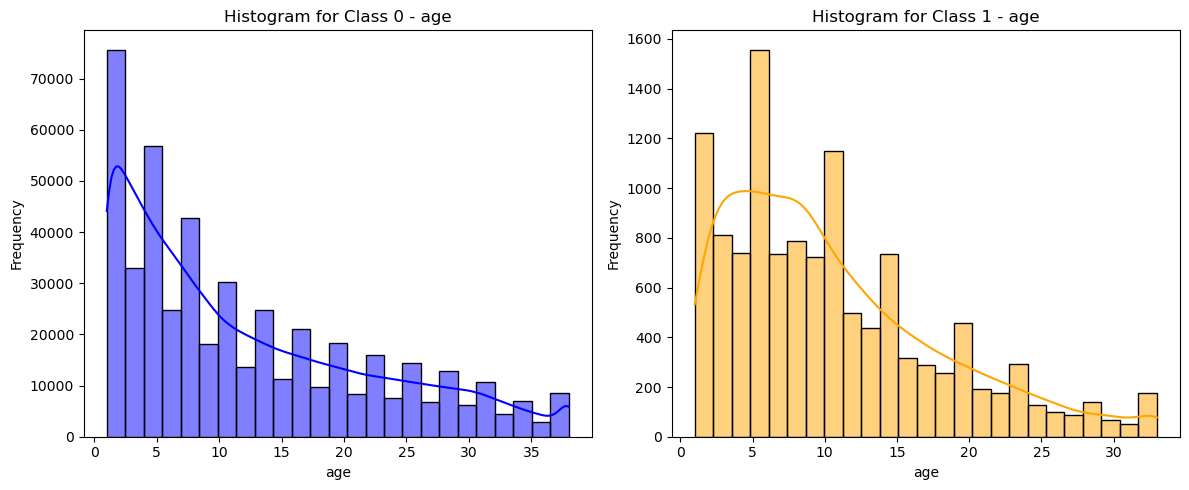

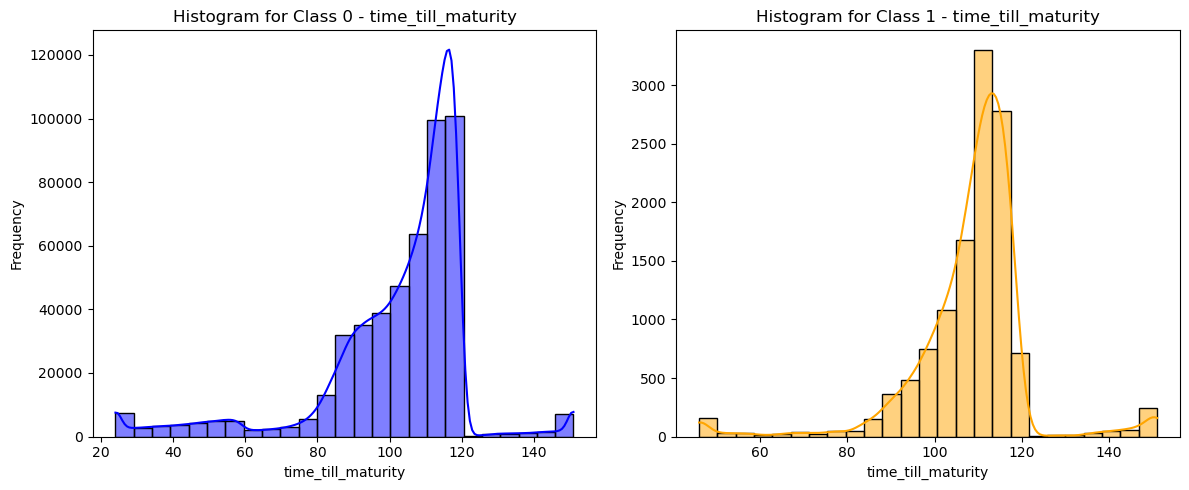

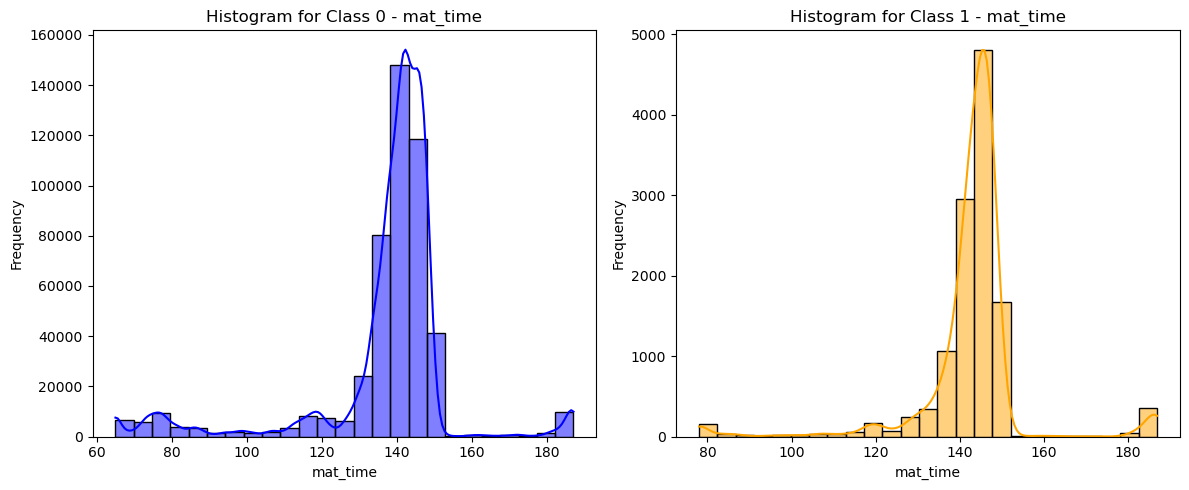

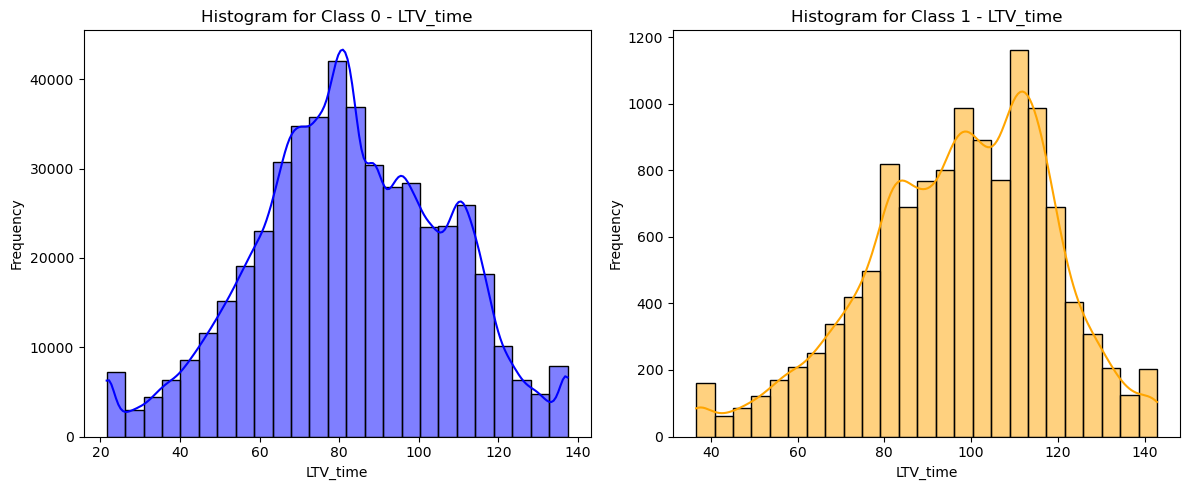

In [33]:
for i in X_train_selected[selected_cont_variables].columns:
    
    selected_feature = i
    
    class0 = train_df[train_df['default_time'] == 0][selected_feature]
    class1 = train_df[train_df['default_time'] == 1][selected_feature]
    
    # Clip the data at the 1st and 99th percentiles
    clipped_class0 = np.clip(class0, np.percentile(class0, 1), np.percentile(class0, 99))
    clipped_class1 = np.clip(class1, np.percentile(class1, 1), np.percentile(class1, 99))
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Plot histogram for Class 0
    sns.histplot(clipped_class0, kde=True, color='blue', ax=axes[0], bins = 25)
    axes[0].set_title(f'Histogram for Class 0 - {selected_feature}')
    axes[0].set_xlabel(selected_feature)
    axes[0].set_ylabel('Frequency')
    
    # Plot histogram for Class 1
    sns.histplot(clipped_class1, kde=True, color='orange', ax=axes[1], bins = 25)
    axes[1].set_title(f'Histogram for Class 1 - {selected_feature}')
    axes[1].set_xlabel(selected_feature)
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

### Observation:
* We could see that the distribution of negative class and positive class is very resembling.
* In all bins, observations of majority class outnumber those of majority class by a large margin. This suggests that we need to check for the distribution of default in a higher dimension (e.g. default distribution plot on 2 features)  

To plot the distribution of default on 2 features, we consider the combination of **LTV_time** with other selected continuous variables. The reason for such choice of combination is that **LTV_time** has the highest Information Value so it makes a better sense to consider only the combination between LTV and other variables. We could check for the distribution based on all possible combination but it is simply very time consuming.

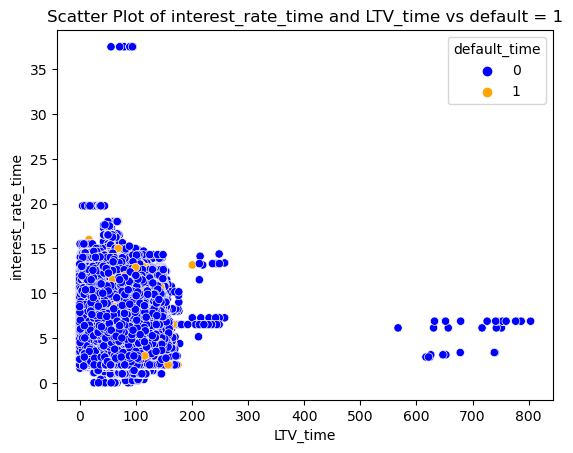

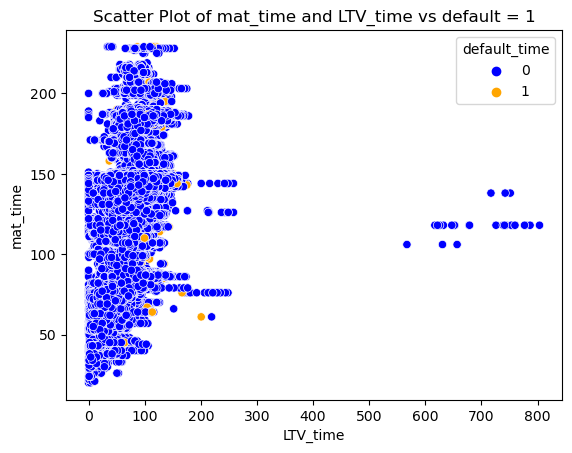

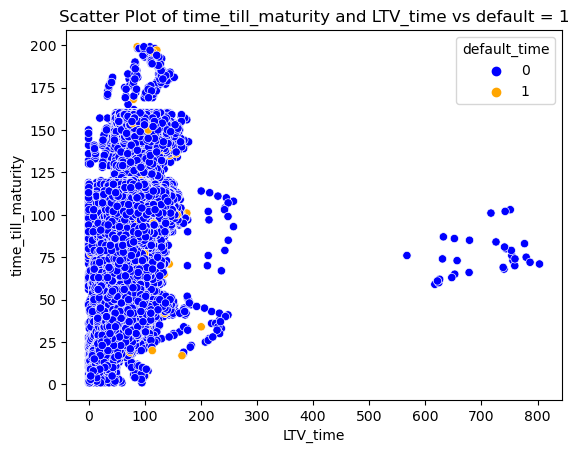

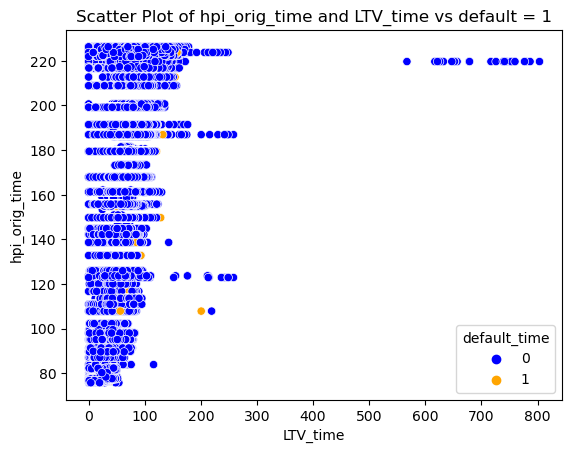

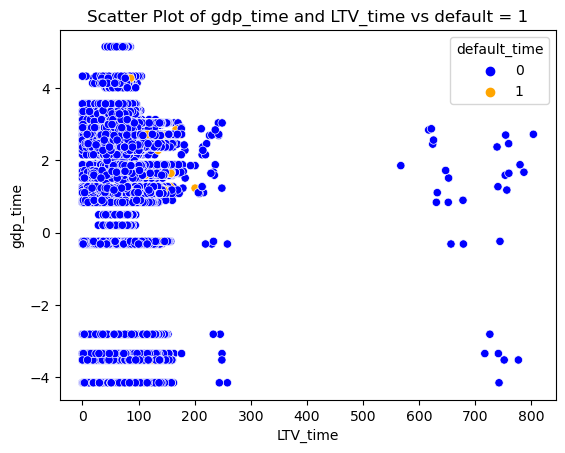

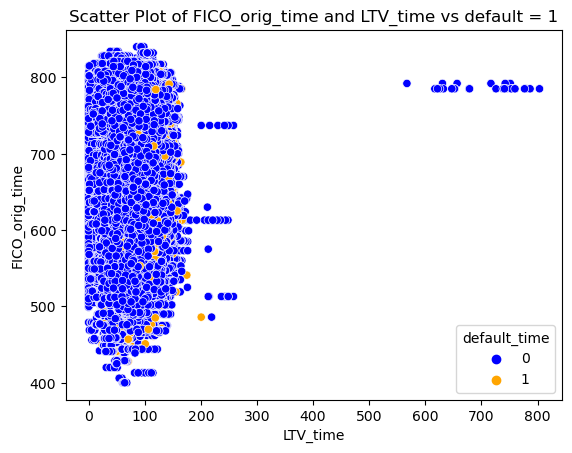

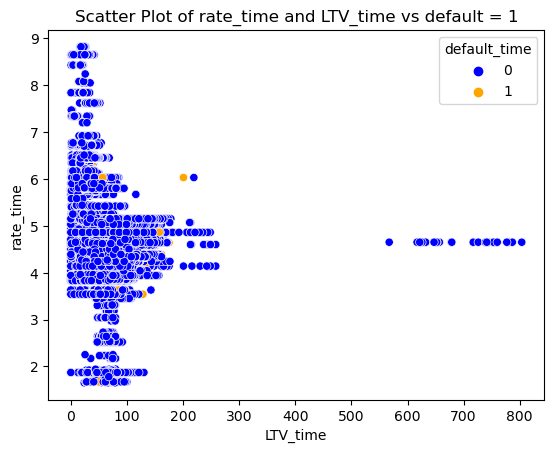

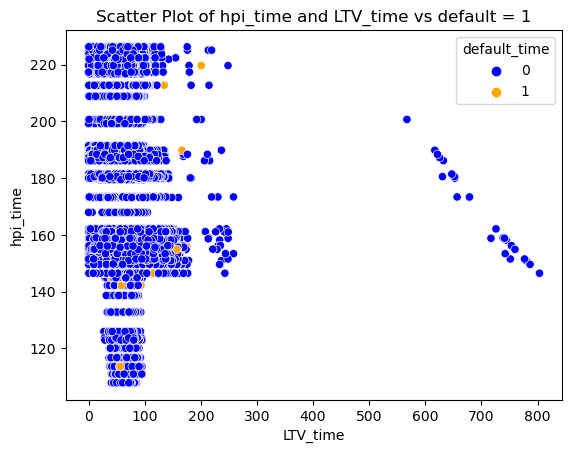

In [34]:
x_var = ['LTV_time']
for j in x_var:
    for i in ['interest_rate_time', 'mat_time', 'time_till_maturity', 'hpi_orig_time', 'gdp_time',
              'FICO_orig_time', 'rate_time', 'hpi_time']:
        sns.scatterplot(x = j, y = i, data = train_df, hue = 'default_time',
                        palette= {0: 'blue', 1: 'orange'})
        plt.title(f'Scatter Plot of {i} and {j} vs default = 1')
        plt.xlabel(f'{j}')
        plt.ylabel(f'{i}')
        plt.show()

As expected, on a 2 dimension level, we still see the majority class overpresents in most of the bins. There are some areas where the minority class overepresents but these areas/bins are scattered (or occur at random) without forming a cluster or any meaningful trend. We plot the distribution of case where default = 1 to see the general distribution of default  = 1 on 2 features  

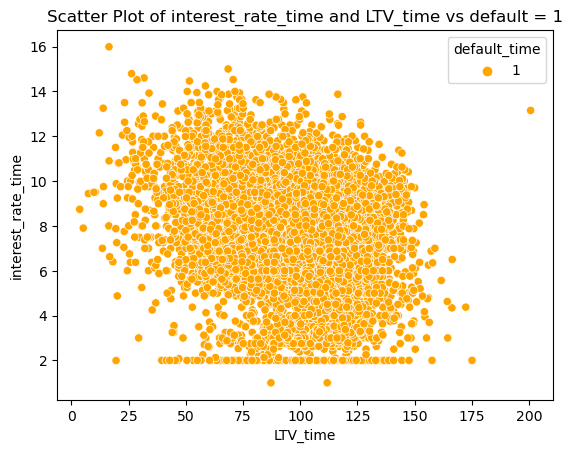

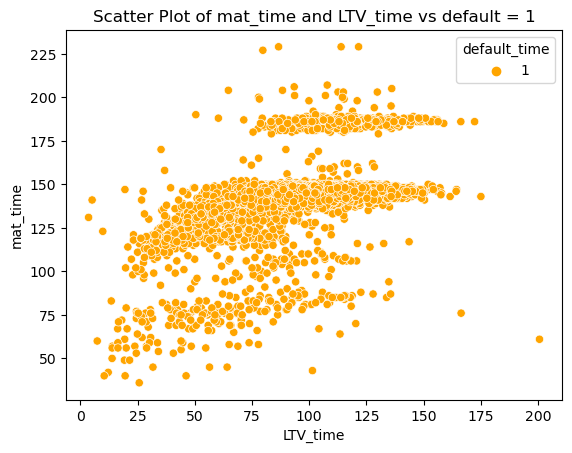

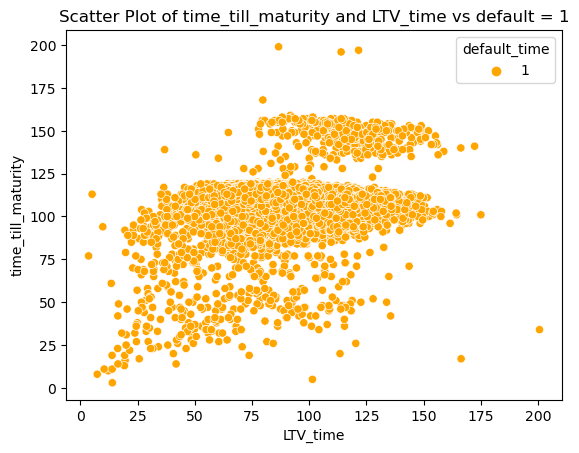

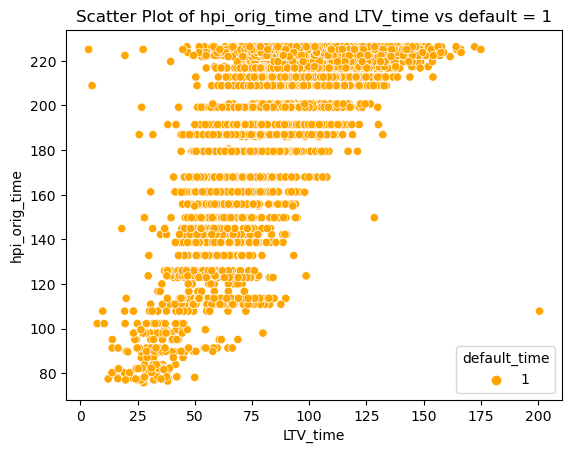

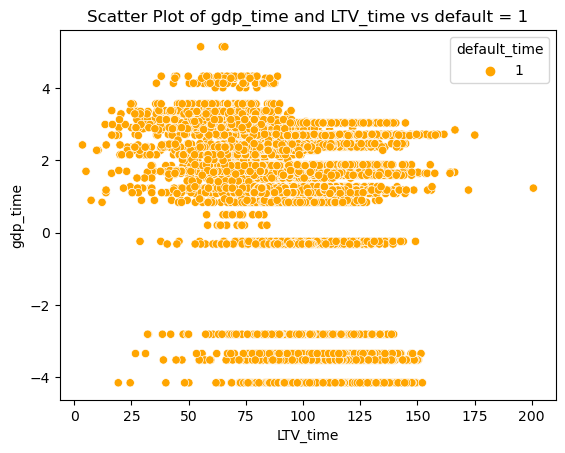

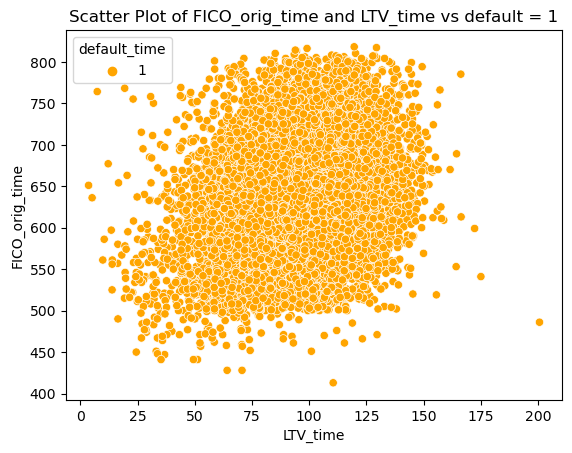

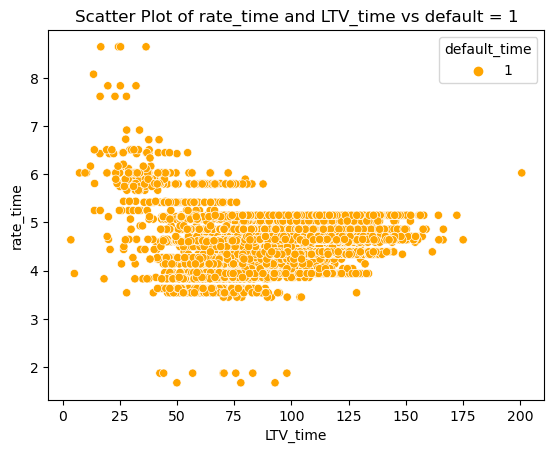

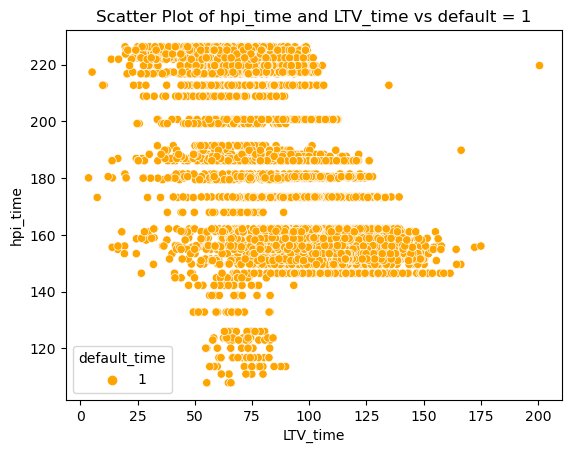

In [35]:
x_var = ['LTV_time']
for j in x_var:
    for i in ['interest_rate_time', 'mat_time', 'time_till_maturity', 'hpi_orig_time', 'gdp_time',
              'FICO_orig_time', 'rate_time', 'hpi_time']:
        sns.scatterplot(x = j, y = i, data = train_df[train_df['default_time']==1], hue = 'default_time',
                        palette= {0: 'blue', 1: 'orange'})
        plt.title(f'Scatter Plot of {i} and {j} vs default = 1')
        plt.xlabel(f'{j}')
        plt.ylabel(f'{i}')
        plt.show()

Nothing useful can be drawn from these graphs  

Checking for the default distribution on **LTV_time** vs. **REtype_SF_orig_time** and **investor_orig_time**: 

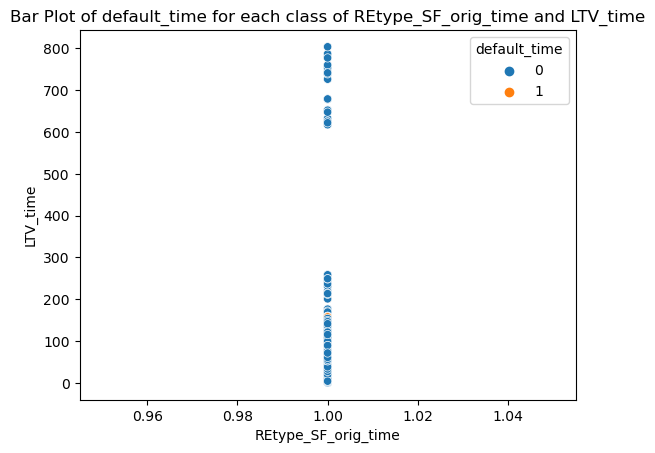

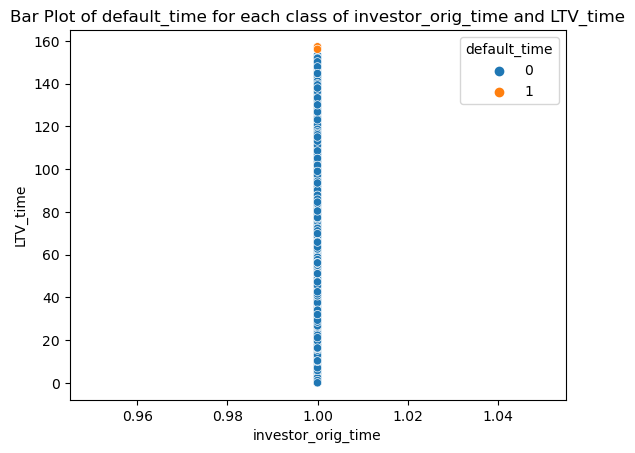

In [36]:
for i in ['REtype_SF_orig_time', 'investor_orig_time']:
    target_column = 'default_time'
    sns.scatterplot(x = i, y = 'LTV_time' , hue=target_column, data=train_df[train_df[i]==1])
    plt.title(f'Bar Plot of {target_column} for each class of {i} and {j}')
    plt.xlabel(i)
    plt.ylabel(j)
    plt.legend(title=target_column)
    plt.show()

Again, majority class overepresents at almost any LTV value.  

Based on the data exploration results, we could see that it is almost impossible to create any interaction or transforming the data in the way that tells which class apart from the other.

# MODEL TRAINING:

The models considered for this project are as follows:
* **Logistic Regression**
* **KNN**
* **Linear Support Vector Machine**
* **andom Forest**
* **XGBoost**
* **Light GBM**
* **Deep Neural Network**  

For hyperparameter tunning, **Bayesian** approach is utilized and the choice of python package for hyperparameter tunning is **optuna**.  

For model which is based on distance among observations, **Robust Scaler** is used to scale data. The reason for such choice is that majority of continuous observation is non normal so **Standard Scaler** is not an optimal choice, while **Min-Max Scaler**  doesn’t reduce the importance of outliers.  

Create a **Robust Scaler**:

In [37]:
rc = RobustScaler()

Create **optuna** study object with relevant hyperparameters and corresponding range of values being considered

#### Note:
Due to issue with highly imbalanced data, parameter **class_weight** is set as ***'balanced'*** whenever possible (some models support this feature). This treatment gives higher penalty to missclassification of minority class forcing the algorithm to select hyperparameters that give better accuracy in predicting minority class.

In [42]:
    # Logistic Regression:
def objective_lr(trial, X, y):
        params = {'solver': trial.suggest_categorical('solver', ['saga']), # only saga solver is considered due to its ability to work faster on large dataset and it can accommodate all type of regularization
              'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']), 
              'C': trial.suggest_float("C", 0.01, 100, log=True),
                 }
        clf = make_pipeline(LogisticRegression(**params, class_weight='balanced', random_state = 16))
        scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
        return np.mean(scores)

    # KNN Classifier:
def objective_knn(trial, X, y):
        params = {'n_neighbors': trial.suggest_int('n_neighbors', 1, 10),
                  'weights': trial.suggest_categorical('weights', ['uniform', 'distance']), 
                  'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
                  'p': trial.suggest_int("p",1,2)
                 }
        clf = make_pipeline(KNeighborsClassifier(**params, random_state = 16))
        scores = cross_val_score(clf, X, y, cv=5)
        return np.mean(scores)

    # Linear SVC:
def objective_linear_svc(trial, X, y):
        params = {'C': trial.suggest_loguniform('C', 1e-4, 1e4), 
                 }
        clf = make_pipeline(LinearSVC(**params, class_weight="balanced", random_state = 16))
        scores = cross_val_score(clf, X, y, cv=5)
        return np.mean(scores)

    # Random Forest:
def objective_rf(trial, X, y):
        params = {'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
                  'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']), 
                  'max_depth': trial.suggest_int('max_depth', 2, 100, log=True),
                  'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
                  'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, log=True),
                  'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10, log=True),              
                 }
        clf = make_pipeline(RandomForestClassifier(**params, class_weight = 'balanced', random_state = 16))
        scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
        return np.mean(scores)

    # XG Boost Classifier:
def objective_xgbc(trial, X, y):
        params = {"objective": "binary:logistic",
                      'random_state': trial.suggest_int('random_state', 0, 0), 
                      'n_estimators': trial.suggest_int('n_estimators', 10, 1000), # num_boosting_round
                      'max_depth': trial.suggest_int('max_depth', 1, 10), 
                      'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0), 
                      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 1e+0), # eta
                      'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0), 
                      'min_split_loss': trial.suggest_float('min_split_loss', 1e-8, 1.0, log=True), # gamma
                      'booster': trial.suggest_categorical('booster', ['gbtree']), # , excluding 'gblinear' (less accurate than gbtree), 'dart' (time consuming)
                      'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True), # lambda
                      'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0)# alpha
                     }
        clf = make_pipeline(XGBClassifier(**params, use_label_encoder=False, n_jobs = 8, random_state = 16))
        scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
        return np.mean(scores)

    # Neural Network Classifier:
def objective_nnc(trial, X, y):
        params = {
            "hidden_layer_sizes": trial.suggest_int('hidden_layer_sizes', 2, 100, log=True),
            "activation": trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
            "alpha": trial.suggest_float("alpha", 1e-4, 1, log=True),
            'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
            "max_iter": trial.suggest_int('max_iter', 100, 500)       
            }
        clf = make_pipeline(MLPClassifier(**params, random_state = 16))
        scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
        return np.mean(scores)

    # Light GBM Classifier:
def objective_lgbc(trial, X, y):
        params = {
            "objective": "binary",
            'verbose':-1,
            'boosting': trial.suggest_categorical('boosting', ['gbdt', 'dart']),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1, log=True),
            'max_depth': trial.suggest_int('max_depth', 1, 20),
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000, log=True),
            "lambda_l1": trial.suggest_float("lambda_l1", 3, 30.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 3, 30.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }
        clf = make_pipeline(LGBMClassifier(**params, class_weight = 'balanced', n_jobs = 8, random_state = 12))
        scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
        return np.mean(scores)

## 1. Perform hyperparameter tunning and save best parameters for every dataset:  
#### Note:
***SMOTEENN*** is employed to resample data as this technique possesses the ability to reduce majority class while synthetically populate minority class. This treatment is advised for highly imbalanced data.

<mark>**WARNING !!!!!**</mark>  - Running the block of code below will take more than a day to finish. Outputs are the best hyperparameters for each model on every dataset. Unless you really want to perform sanity check, <mark>*it is advisable to skip the below part*</mark> as the subsequent block of code will load the saved best hyperparameters (I have run the block of code below and saved the best hyperparameters).

<mark>**BEGINNING**</mark> OF SKIPPABLE PART:

In [ ]:
best_param_dict = {}

for i in range(len(dataset)):    
    
    X_train = train_test_dict[f'X_train_{i}'].copy()
    X_train.reset_index(inplace = True)
    X_train.drop(['index'], axis = 1, inplace = True)
    
    y_train = train_test_dict[f'y_train_{i}'].copy()
    y_train.reset_index(inplace = True)
    y_train.drop(['index'], axis = 1, inplace = True)

    X_train_selected = X_train.drop(drop_variables, axis = 1)

    # Create SMOTEENN instance for training data sampling

    sampler = SMOTEENN(sampling_strategy= 0.1, n_jobs = 8, random_state= 10)
    X_resampled, y_resampled = sampler.fit_resample(X_train_selected, y_train)
    
    # Scaled data is used for svc and knn since these models' fitting mechanism based on distance among observations
    X_train_scaled = pd.DataFrame(
        rc.fit_transform(X_train_selected[selected_cont_variables]),
        columns = X_train_selected[selected_cont_variables].columns
    )
    
    X_train_scaled = pd.concat([X_train_selected[selected_dichotomous_variables], X_train_scaled], axis=1)
    
    X_scaled_resampled, y_scaled_resampled = sampler.fit_resample(X_train_scaled, y_train)

    study_lr = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
    study_lr.optimize(functools.partial(objective_lr, X=X_resampled, y=y_resampled), n_trials=30, n_jobs=8)
    
    study_knn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
    study_knn.optimize(functools.partial(objective_knn, X=X_scaled_resampled, y=y_scaled_resampled), n_trials=30, n_jobs=8)
    
    study_svc = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
    study_svc.optimize(functools.partial(objective_linear_svc, X=X_scaled_resampled, y=y_scaled_resampled), n_trials=30, n_jobs=8)
    
    study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
    study_rf.optimize(functools.partial(objective_rf, X=X_resampled, y=y_resampled), n_trials=30, n_jobs=8)
    
    study_xgbc = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
    study_xgbc.optimize(functools.partial(objective_xgbc, X=X_resampled, y=y_resampled), n_trials=30)
    
    study_nnc = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
    study_nnc.optimize(functools.partial(objective_nnc, X=X_resampled, y=y_resampled), n_trials=30, n_jobs=8)
    
    study_lgbc = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
    study_lgbc.optimize(functools.partial(objective_lgbc, X=X_resampled, y=y_resampled), n_trials=30, n_jobs= 8)
    
    
    best_param_dict[f'study_lr_{i}'] = study_lr
    best_param_dict[f'study_knn_{i}'] = study_knn
    best_param_dict[f'study_svc_{i}'] = study_svc
    best_param_dict[f'study_rf_{i}'] = study_rf
    best_param_dict[f'study_xgbc_{i}'] = study_xgbc
    best_param_dict[f'study_nnc_{i}'] = study_nnc
    best_param_dict[f'study_lgbc_{i}'] = study_lgbc
    
    print (f'dataset {i} is done')

model_params = ['lr', 'knn', 'svc', 'rf', 'xgbc', 'nnc', 'lgbc']

# save best params obtained from hyperparameter tunning as a pickle object
for i in range(len(dataset)):
    for j in model_params:
        study = best_param_dict[f'study_{j}_{i}']
        with open(f'study_{j}_{i}.pkl', 'wb') as study_file:
            pickle.dump(study, study_file)

<mark>**ENDING**</mark> OF SKIPPABLE PART  

<mark>**NOTE:**</mark> If you have run the previous block of code (which takes more than a day to finish) to get the best parameters, please skip the subsequent block of code as it simply imports the best parameters obtained from the previous step.  

<mark>**BEGINNING**</mark> OF SKIPPABLE PART

In [45]:
best_param_dict = {}
model_params = ['lr', 'knn', 'svc', 'rf', 'xgbc', 'nnc', 'lgbc']
for i in range(len(dataset)):
    for j in model_params:
        study = joblib.load(f'study_{j}_{i}.pkl')
        best_param_dict[f'study_{j}_{i}'] = study

<mark>**ENDING**</mark> OF SKIPPABLE PART  
## 2. Calculating In-sample and Out-of-sample AUC and MAE for each model on each dataset:

<mark>**WARNING !!!!!**</mark> Running the loop below will take several hours. Unless necessary, this part can be skipped as the outputs of it can be imported by running the code subsequent to the block of code below:  

<mark>**BEGINNING**</mark> OF SKIPPABLE PART

In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Test_Set', 'In_Sample_ROC_AUC', 'Out_of_Sample_ROC_AUC', 
                                   'In_Sample_MAE', 'Out_of_Sample_MAE'])

out_sample_df = {}

drop_variables_interim = ['REtype_CO_orig_time', 'REtype_PU_orig_time','balance_time', 'balance_scheduled_time', 'balance_orig_time',
                          'LTV_orig_time', 'annuity', 'uer_time_lag_2', 'uer_time', 'property_orig_time', 'uer_time_lag_1',
                          'orig_time', 'first_time', 'gdp_time_lag_1', 'gdp_time_lag_2', 'Interest_Rate_orig_time', 
                          'annuity', 'cep_time', 'equity_time', 'orig_time', 'first_time']

for i in range(len(dataset)):
    for j in model_params:
        
        if j == 'lr':
            model = LogisticRegression(**best_param_dict[f'study_{j}_{i}'].best_params)
        elif j == 'knn':
            model = KNeighborsClassifier(**best_param_dict[f'study_{j}_{i}'].best_params)
        elif j == 'svc':
            model = CalibratedClassifierCV(LinearSVC(**best_param_dict[f'study_{j}_{i}'].best_params))
        elif j == 'rf':
            model = RandomForestClassifier(**best_param_dict[f'study_{j}_{i}'].best_params)
        elif j == 'xgbc':
            model = XGBClassifier(**best_param_dict[f'study_{j}_{i}'].best_params)
        elif j == 'nnc':
            model = MLPClassifier(**best_param_dict[f'study_{j}_{i}'].best_params)
        else:
            model = LGBMClassifier(**best_param_dict[f'study_{j}_{i}'].best_params)
        
        # Train data:
        
        X_train = train_test_dict[f'X_train_{i}'].copy()
        X_train.reset_index(inplace = True)
        X_train.drop(['index'], axis = 1, inplace = True)
        
        y_train = train_test_dict[f'y_train_{i}'].copy()
        y_train.reset_index(inplace = True)
        y_train.drop(['index'], axis = 1, inplace = True)

        X_train_selected = X_train.drop(drop_variables_interim, axis = 1)

        # Test data:
        
        X_test = train_test_dict[f'X_test_{i}'].copy()
        X_test.reset_index(inplace = True)
        X_test.drop(['index'], axis = 1, inplace = True)
        
        y_test = train_test_dict[f'y_test_{i}'].copy()
        y_test.reset_index(inplace = True)
        y_test.drop(['index'], axis = 1, inplace = True)

        X_test_selected = X_test.drop(drop_variables, axis = 1)
        out_sample_time = X_test['time'].values
        
        # Create SMOTEENN instance
        # I could have saved the resampled training data in previous step. However, I just realized it after running the hyperparameter tunning.
        # Although this step is repeated, the resampled dataset is the same as the one used for hyperparameter tunning.
        sampler = SMOTEENN(sampling_strategy= 0.1, n_jobs = 8, random_state= 10)
        X_resampled, y_resampled = sampler.fit_resample(X_train_selected, y_train)
        in_sample_time = X_resampled['time'].values
        X_resampled.drop(['time'], axis = 1, inplace = True)
        
        X_train_scaled = pd.DataFrame(
            rc.fit_transform(X_train_selected[selected_cont_variables]),
            columns = X_train_selected[selected_cont_variables].columns
        )
        
        X_test_scaled = pd.DataFrame(
            rc.transform(X_test_selected[selected_cont_variables]),
            columns = X_test_selected[selected_cont_variables].columns
        )
        
        X_train_scaled = pd.concat([X_train_selected[selected_dichotomous_variables], X_train_scaled], axis=1)
        X_test_scaled = pd.concat([X_test_selected[selected_dichotomous_variables], X_test_scaled], axis=1)
        
        X_scaled_resampled, y_scaled_resampled = sampler.fit_resample(X_train_scaled, y_train)
        
        # predict probability of each model on testing data
        if j not in ['knn', 'svc']:    
            model.fit(X_resampled, y_resampled)
            in_sample_prob_pred = model.predict_proba(X_resampled)[:,1].T
            out_sample_prob_pred = model.predict_proba(X_test_selected)[:,1].T
            out_sample_pred = model.predict(X_test_selected)
            in_sample_auc = roc_auc_score(y_resampled, in_sample_prob_pred)
            out_sample_auc = roc_auc_score(y_test, out_sample_prob_pred)
            in_sample_test_result = test_result(in_sample_prob_pred, y_resampled['default_time'].values, in_sample_time)
            out_sample_test_result = test_result(out_sample_prob_pred, y_test['default_time'].values, out_sample_time)
        else:
            model.fit(X_scaled_resampled, y_scaled_resampled)
            in_sample_prob_pred = model.predict_proba(X_scaled_resampled)[:,1].T
            out_sample_prob_pred = model.predict_proba(X_test_scaled)[:,1].T
            out_sample_pred = model.predict(X_test_scaled)
            in_sample_auc = roc_auc_score(y_scaled_resampled, in_sample_prob_pred)
            out_sample_auc = roc_auc_score(y_test, out_sample_prob_pred)
            in_sample_test_result = test_result(in_sample_prob_pred, y_resampled['default_time'].values, in_sample_time)
            out_sample_test_result = test_result(out_sample_prob_pred, y_test['default_time'].values, out_sample_time)
        
        # calculating average fitted probability and actual probability on period level
        in_sample_means = in_sample_test_result.groupby('time')[['fit', 'outcome']].mean().reset_index(drop=False)
        out_sample_means = out_sample_test_result.groupby('time')[['fit', 'outcome']].mean().reset_index(drop=False)
        
        # calculating in-sample and out-of-sample mean absolute error
        mae_in_sample = mean_absolute_error(in_sample_means['outcome'], in_sample_means['fit'])
        mae_out_sample = mean_absolute_error(out_sample_means['outcome'], out_sample_means['fit'])
        
        # saving in-sample and out-of-sample auc and mae for each test set
        results_df = results_df.append({'Model':j, 'Test_Set': i, 'In_Sample_ROC_AUC': in_sample_auc,
                                       'Out_of_Sample_ROC_AUC': out_sample_auc, 'In_Sample_MAE': mae_in_sample,
                                       'Out_of_Sample_MAE': mae_out_sample}, ignore_index = True)
        
        # saving out-of-sample probability prediction and actual values
        out_sample_df[f'model_{j}_prob_prediction_{i}'] = out_sample_prob_pred
        out_sample_df[f'model_{j}_prediction_{i}'] = out_sample_pred
        out_sample_df[f'model_{j}_y_test_{i}'] = y_test['default_time'].values
        out_sample_df[f'model_{j}_time_{i}'] = out_sample_time
        
        print (f'model {j} dataset {i} is done')
        
# Save the calculation to "pickle" file and "csv" file:
    
with open('out_sample_df.pkl', 'wb') as out_sample_data:
    pickle.dump(out_sample_df, out_sample_data)

results_df.to_csv('in_out_sample_results.csv', index=False)

<mark>**ENDING**</mark> OF SKIPPABLE PART

<mark>**WARNING !!!!**</mark> If you skip the block above, you need to run the block below to load the out-of-sample test data and model predicted values  

<mark>**BEGINNING**</mark> OF SKIPPABLE PART (only run when previous block of code isn't)

In [46]:
out_sample_df = joblib.load('out_sample_df.pkl')

<mark>**ENDING**</mark> OF SKIPPABLE PART

## 3. Aggregating out-of-sample results from 5 testing dataset into 1 dataframe for each model:

In [47]:
lr_results = pd.DataFrame(columns = ['fit', 'outcome', 'time'])
knn_results = pd.DataFrame(columns = ['fit', 'outcome', 'time'])
svc_results = pd.DataFrame(columns = ['fit', 'outcome', 'time'])
rf_results = pd.DataFrame(columns = ['fit', 'outcome', 'time'])
xgbc_results = pd.DataFrame(columns = ['fit', 'outcome', 'time'])
nnc_results = pd.DataFrame(columns = ['fit', 'outcome', 'time'])
lgbc_results = pd.DataFrame(columns = ['fit', 'outcome', 'time'])
ada_results = pd.DataFrame(columns = ['fit', 'outcome', 'time'])

for i in range(len(dataset)):
    
    lr_df = pd.DataFrame({'fit': out_sample_df[f'model_lr_prob_prediction_{i}'].tolist(),
               'outcome': out_sample_df[f'model_lr_y_test_{i}'].tolist(),
               'time': out_sample_df[f'model_lr_time_{i}'].tolist()})
    lr_results = pd.concat([lr_results, lr_df])

    knn_df = pd.DataFrame({'fit': out_sample_df[f'model_knn_prob_prediction_{i}'].tolist(),
                'outcome': out_sample_df[f'model_knn_y_test_{i}'].tolist(),
                'time': out_sample_df[f'model_knn_time_{i}'].tolist()})
    knn_results = pd.concat([knn_results, knn_df])
    
    svc_df = pd.DataFrame({'fit': out_sample_df[f'model_svc_prob_prediction_{i}'].tolist(),
                'outcome': out_sample_df[f'model_svc_y_test_{i}'].tolist(),
                'time': out_sample_df[f'model_svc_time_{i}'].tolist()})
    svc_results = pd.concat([svc_results, svc_df])
    
    rf_df = pd.DataFrame({'fit': out_sample_df[f'model_rf_prob_prediction_{i}'].tolist(),
               'outcome': out_sample_df[f'model_rf_y_test_{i}'].tolist(),
                'time': out_sample_df[f'model_rf_time_{i}'].tolist()})
    rf_results = pd.concat([rf_results, rf_df])
    
    xgbc_df = pd.DataFrame({'fit': out_sample_df[f'model_xgbc_prob_prediction_{i}'].tolist(),
                 'outcome': out_sample_df[f'model_xgbc_y_test_{i}'].tolist(),
                 'time': out_sample_df[f'model_xgbc_time_{i}'].tolist()})
    xgbc_results = pd.concat([xgbc_results, xgbc_df])
    
    nnc_df = pd.DataFrame({'fit': out_sample_df[f'model_nnc_prob_prediction_{i}'].tolist(),
                'outcome': out_sample_df[f'model_nnc_y_test_{i}'].tolist(),
                'time': out_sample_df[f'model_nnc_time_{i}'].tolist()})
    nnc_results = pd.concat([nnc_results, nnc_df])
    
    lgbc_df = pd.DataFrame({'fit': out_sample_df[f'model_lgbc_prob_prediction_{i}'].tolist(),
                 'outcome': out_sample_df[f'model_lgbc_y_test_{i}'].tolist(),
                 'time': out_sample_df[f'model_lgbc_time_{i}'].tolist()})
    lgbc_results = pd.concat([lgbc_results, lgbc_df])

# Performance Assessment:
## 1. Calculating aggregated forecast results:

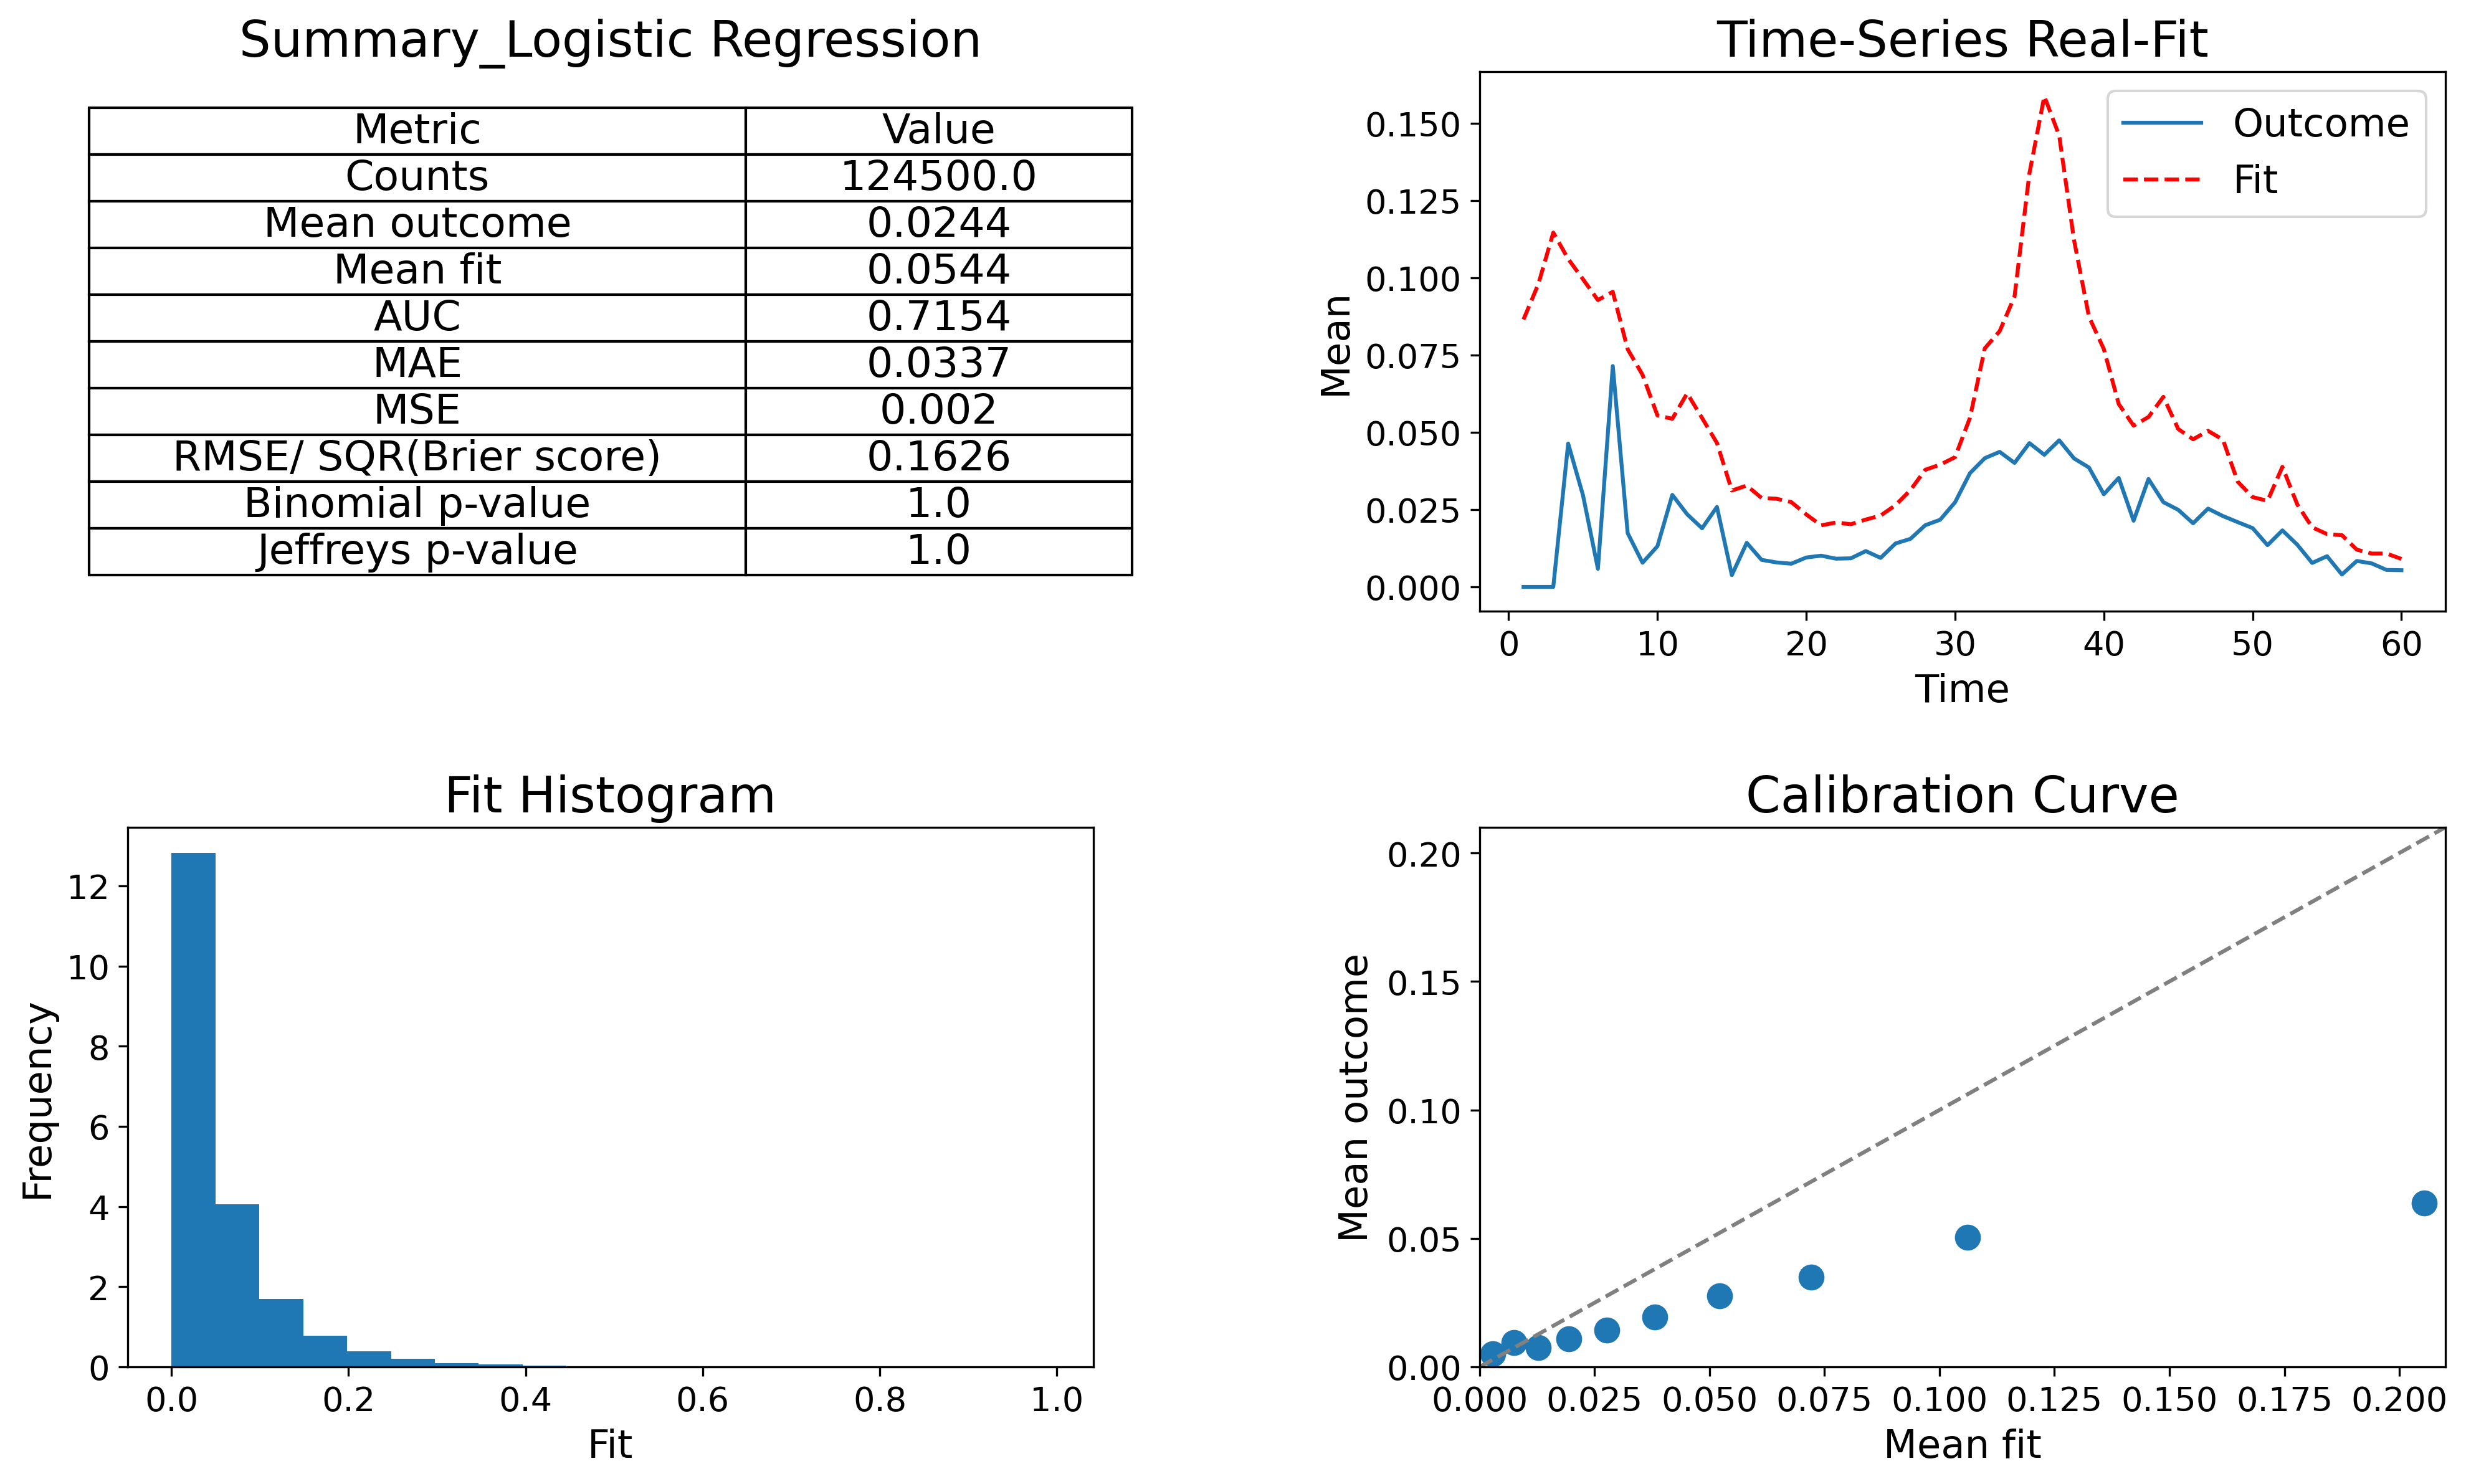

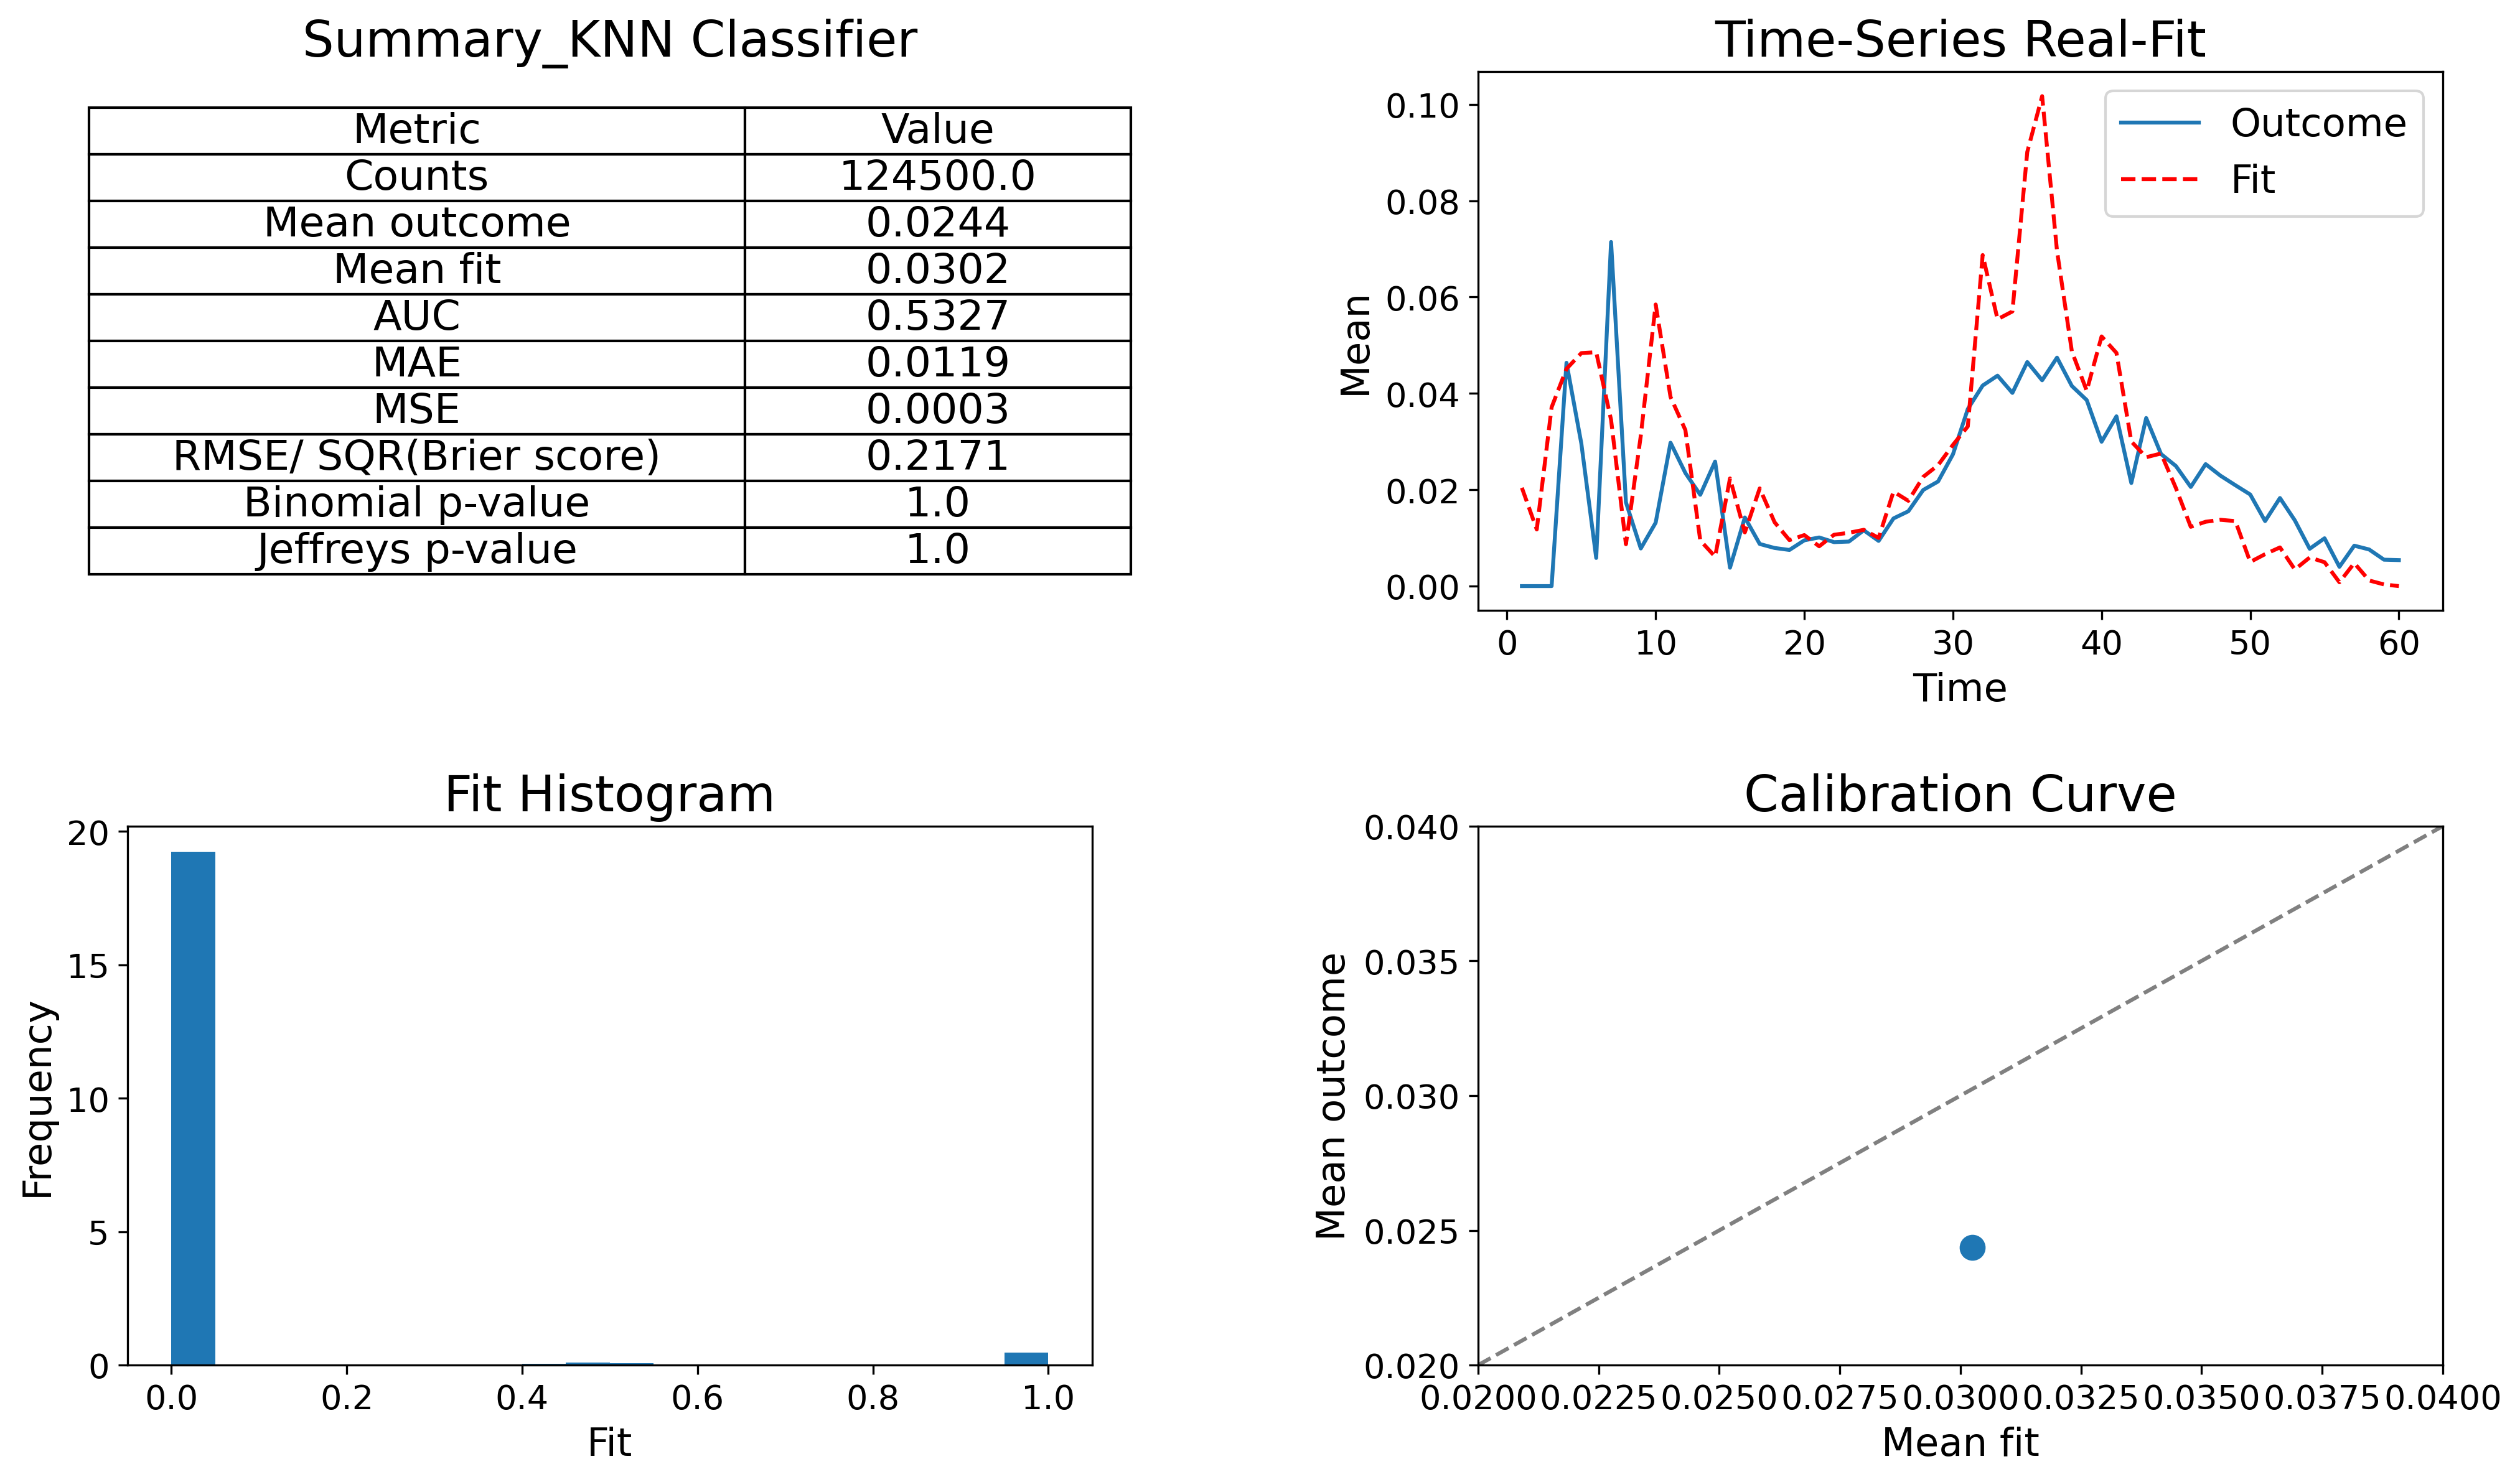

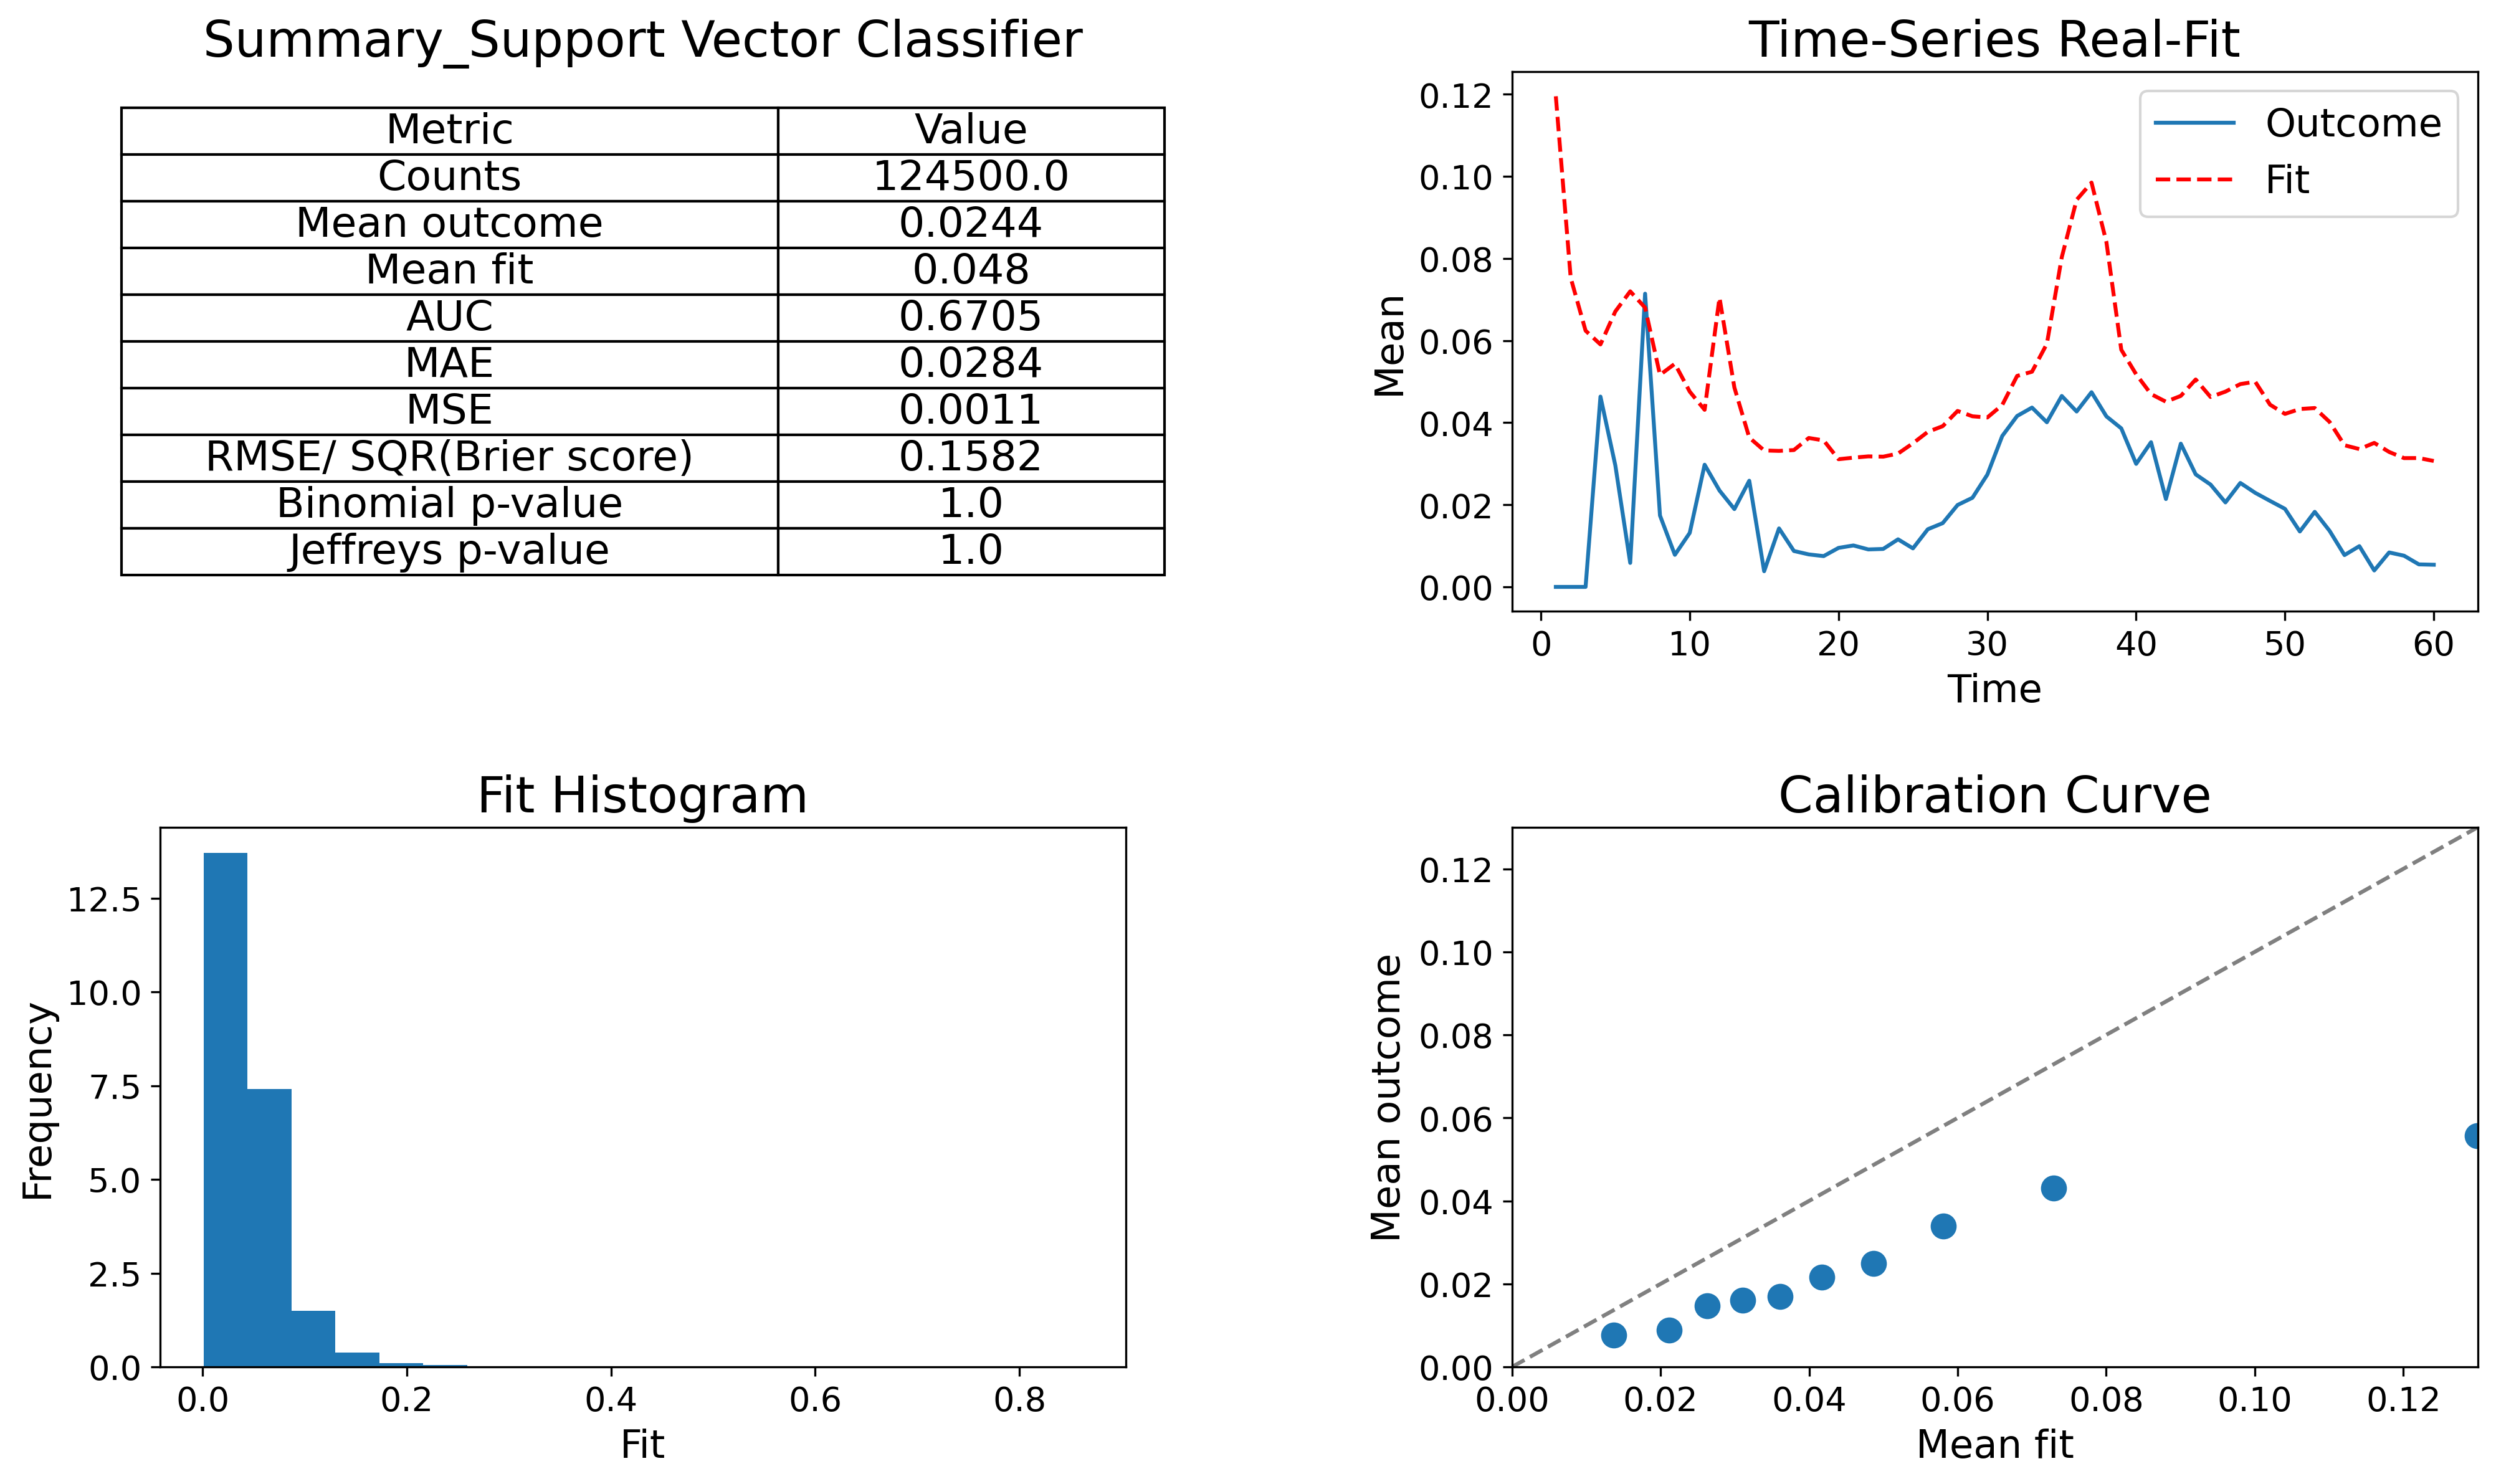

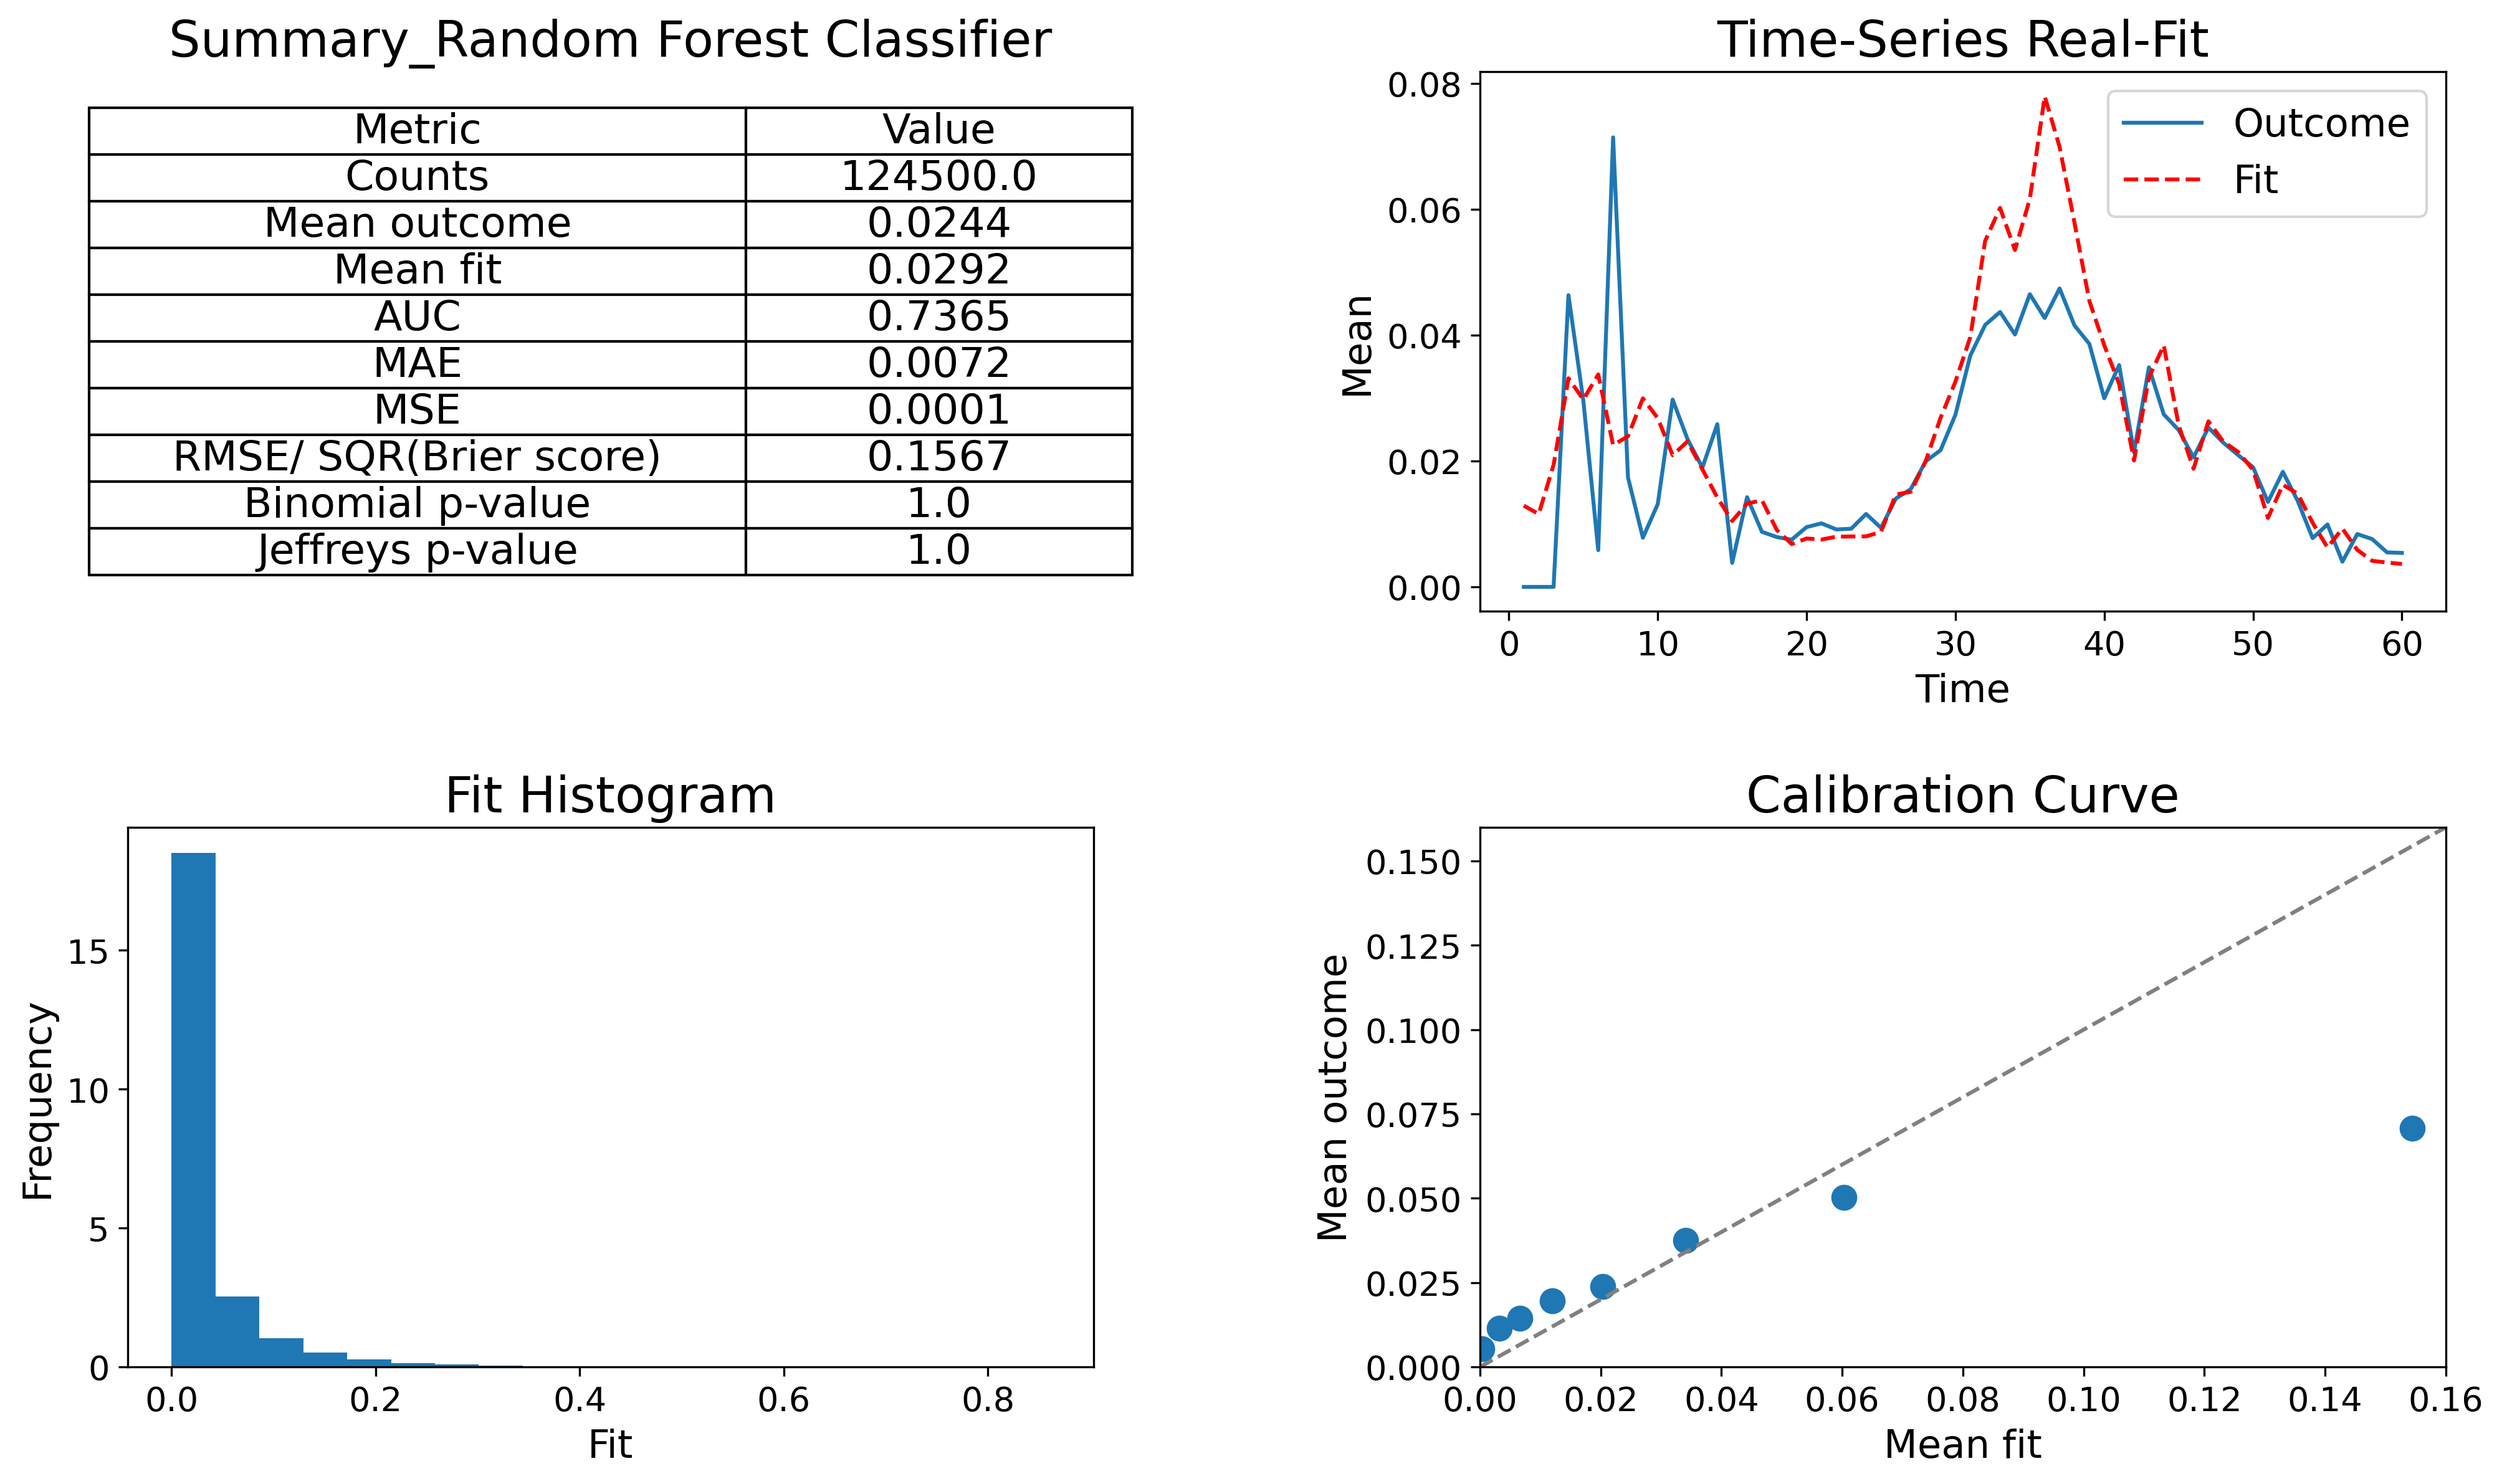

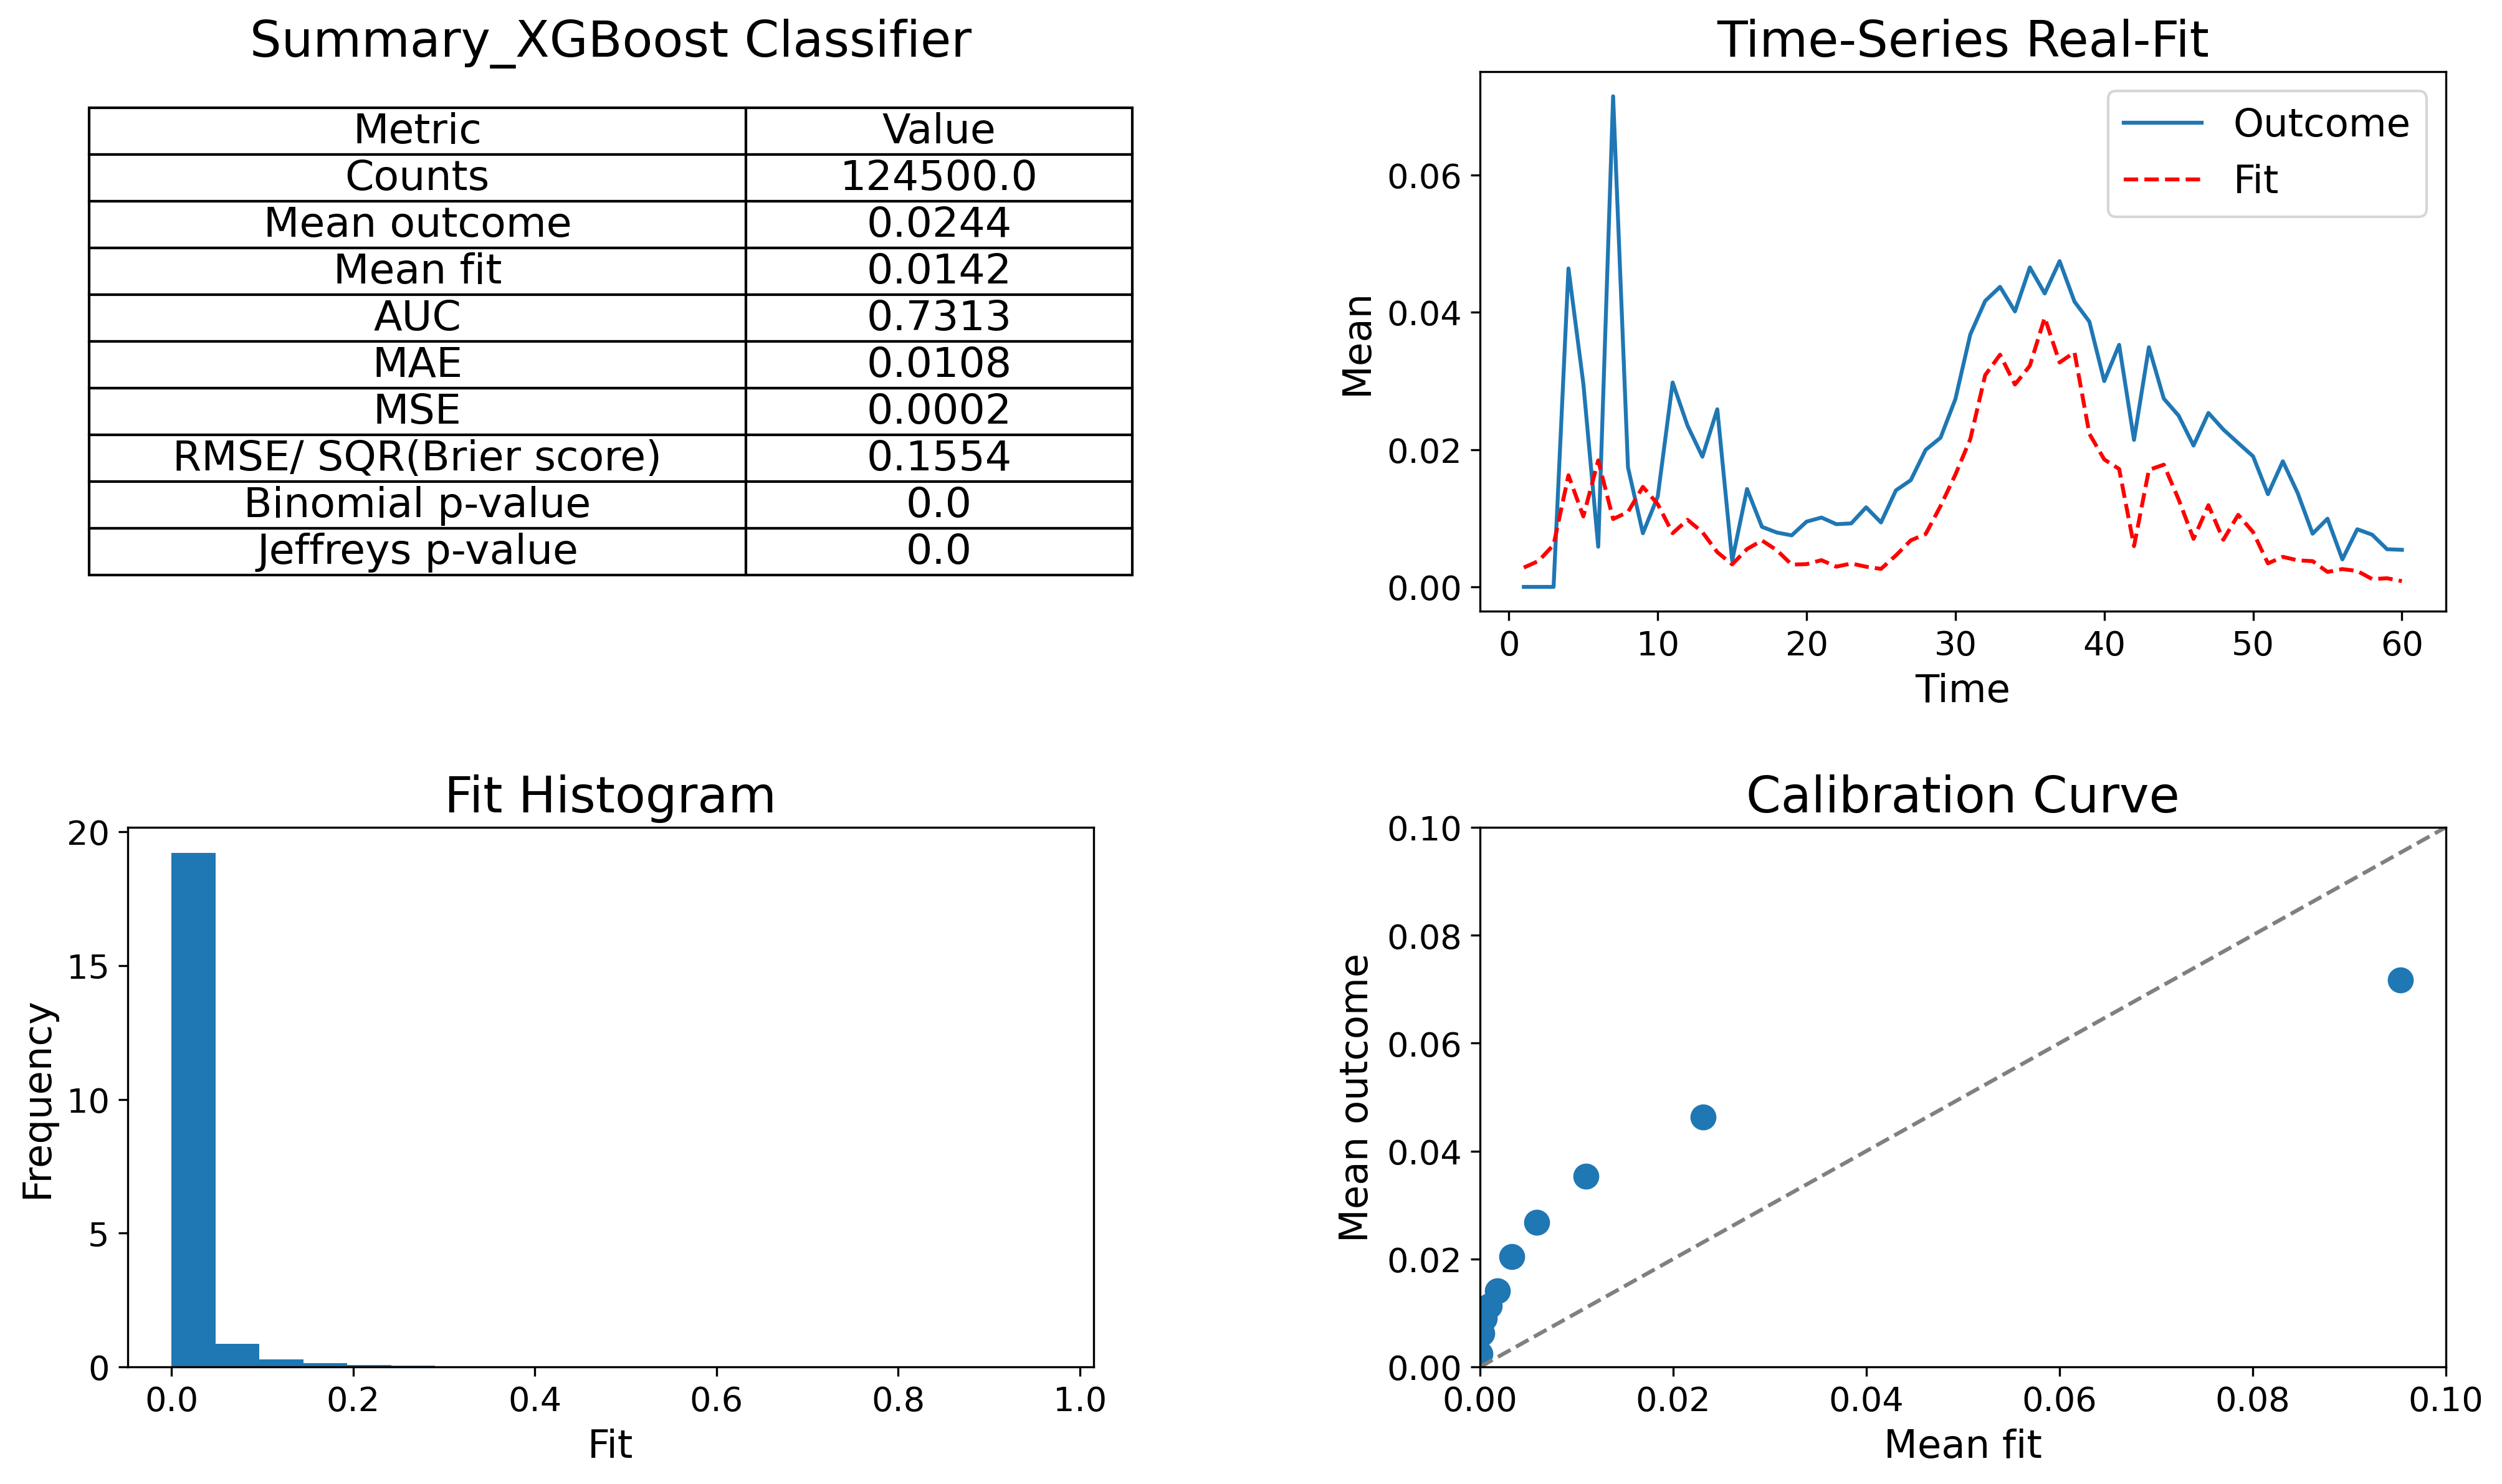

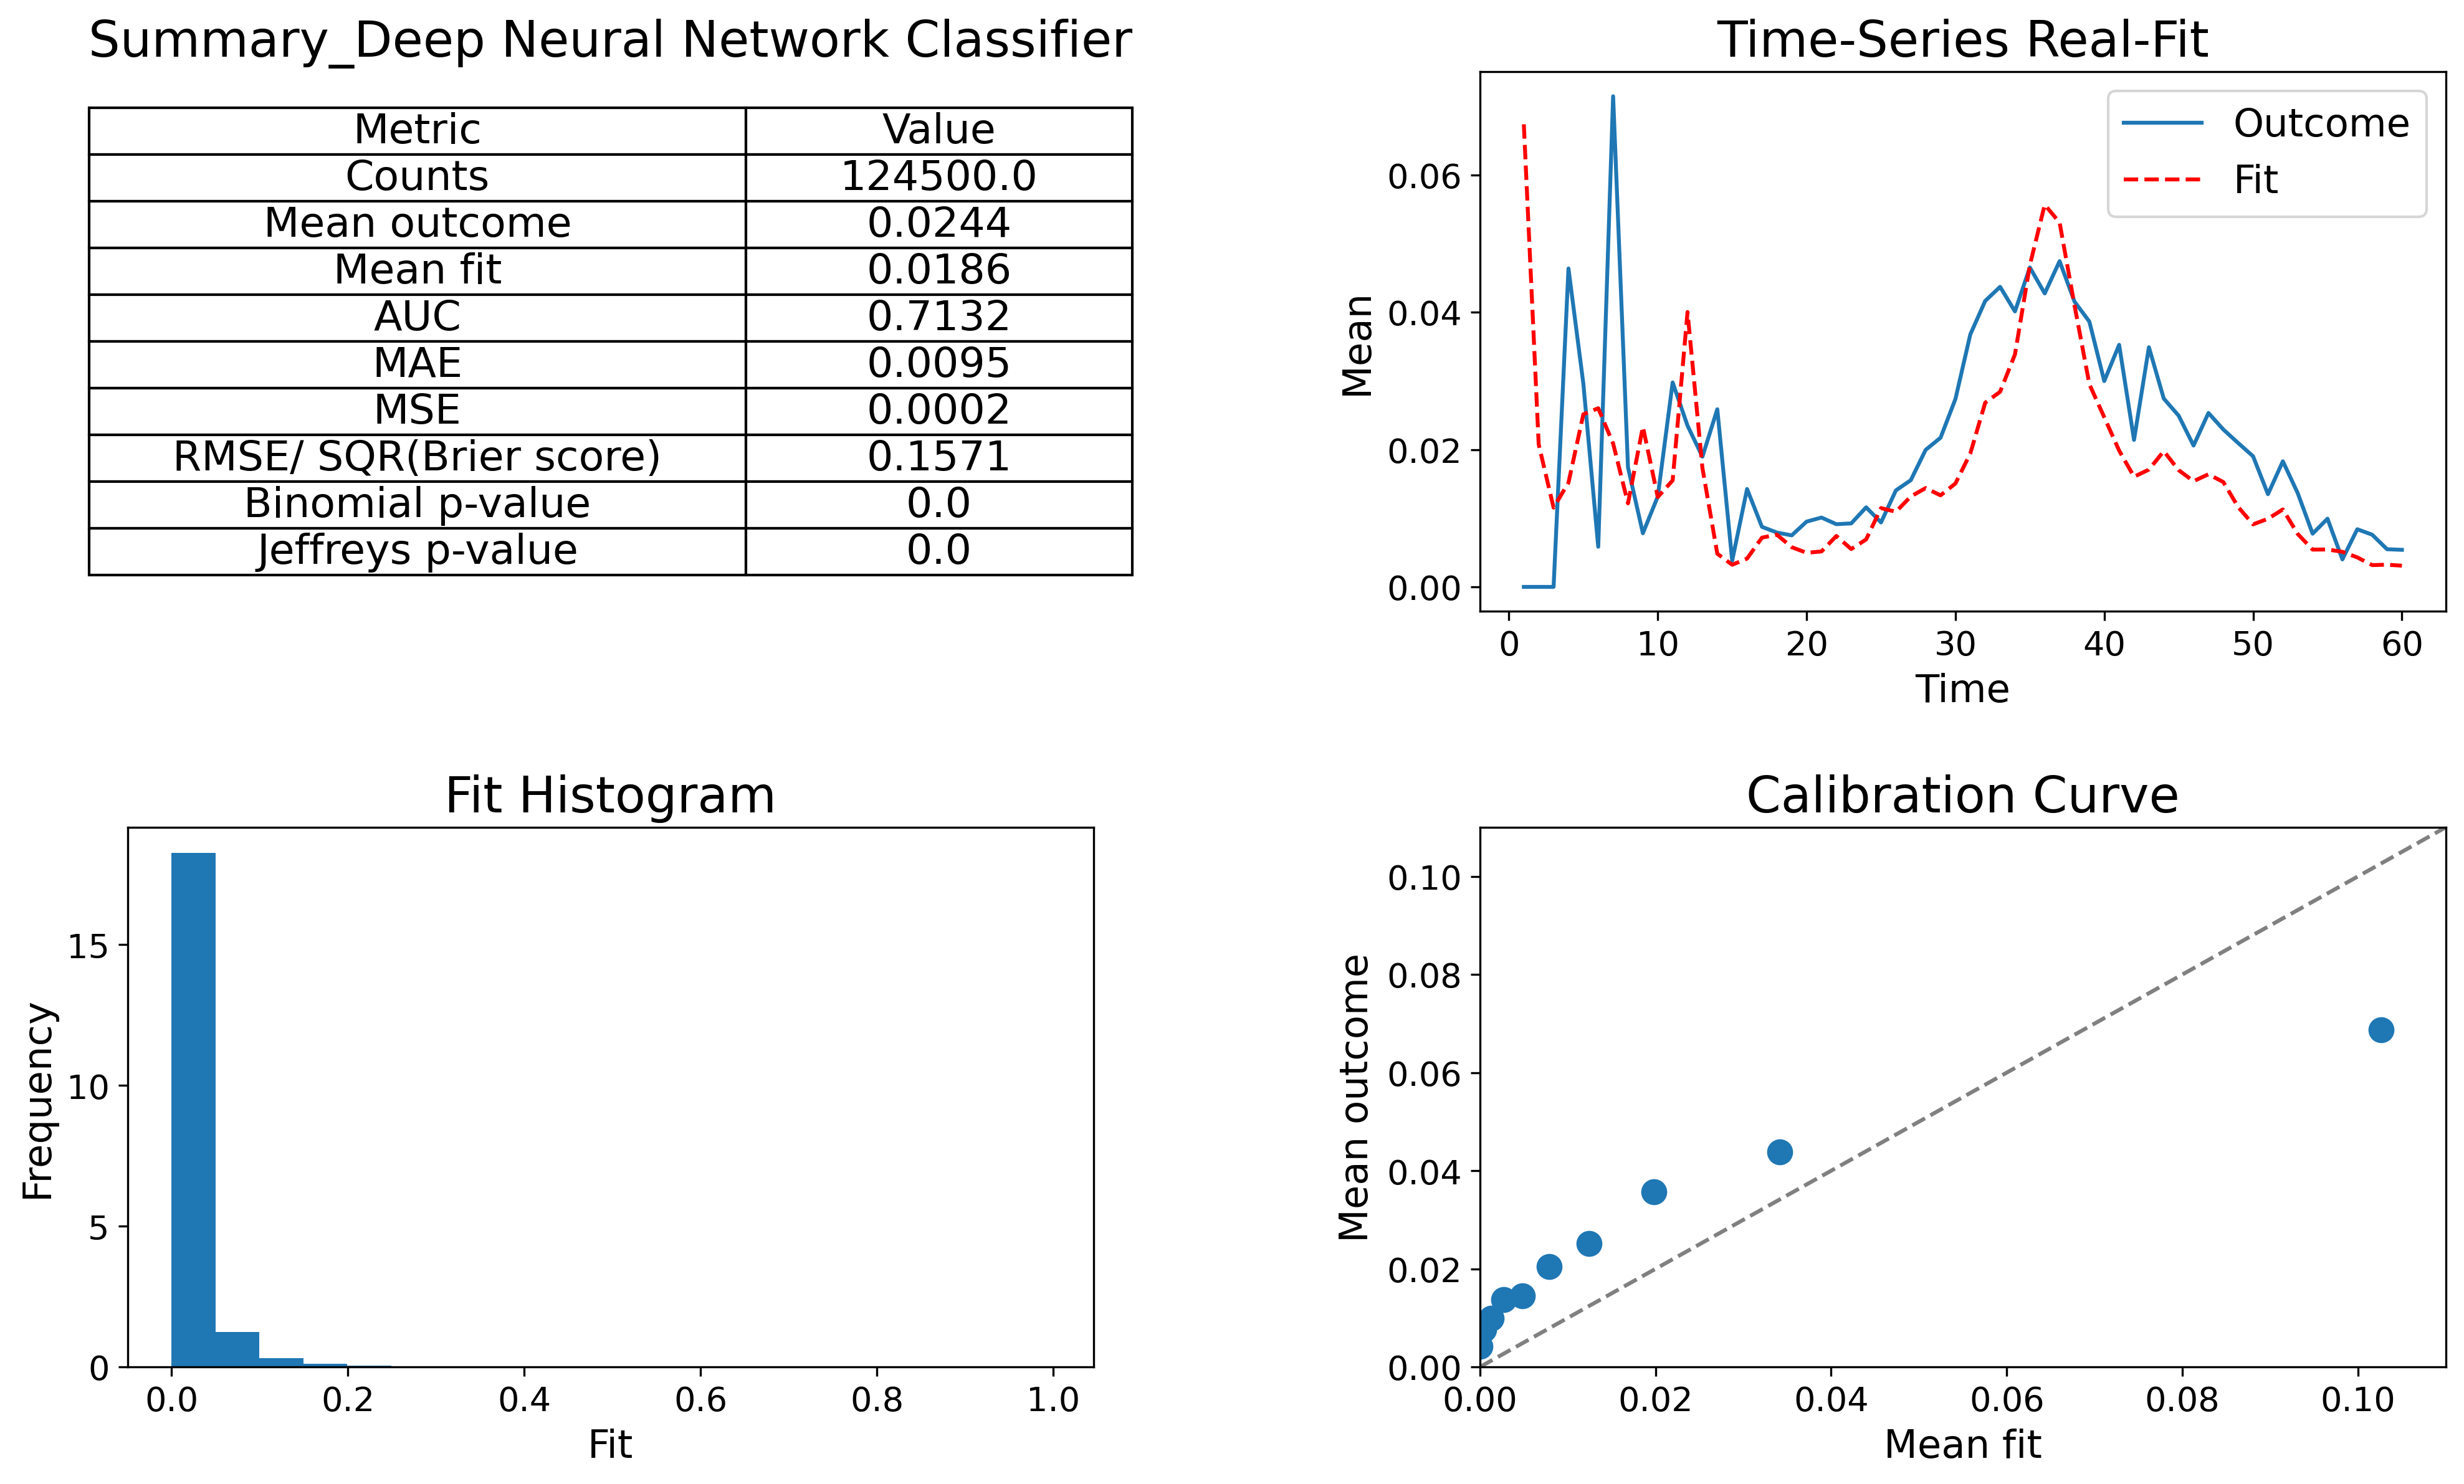

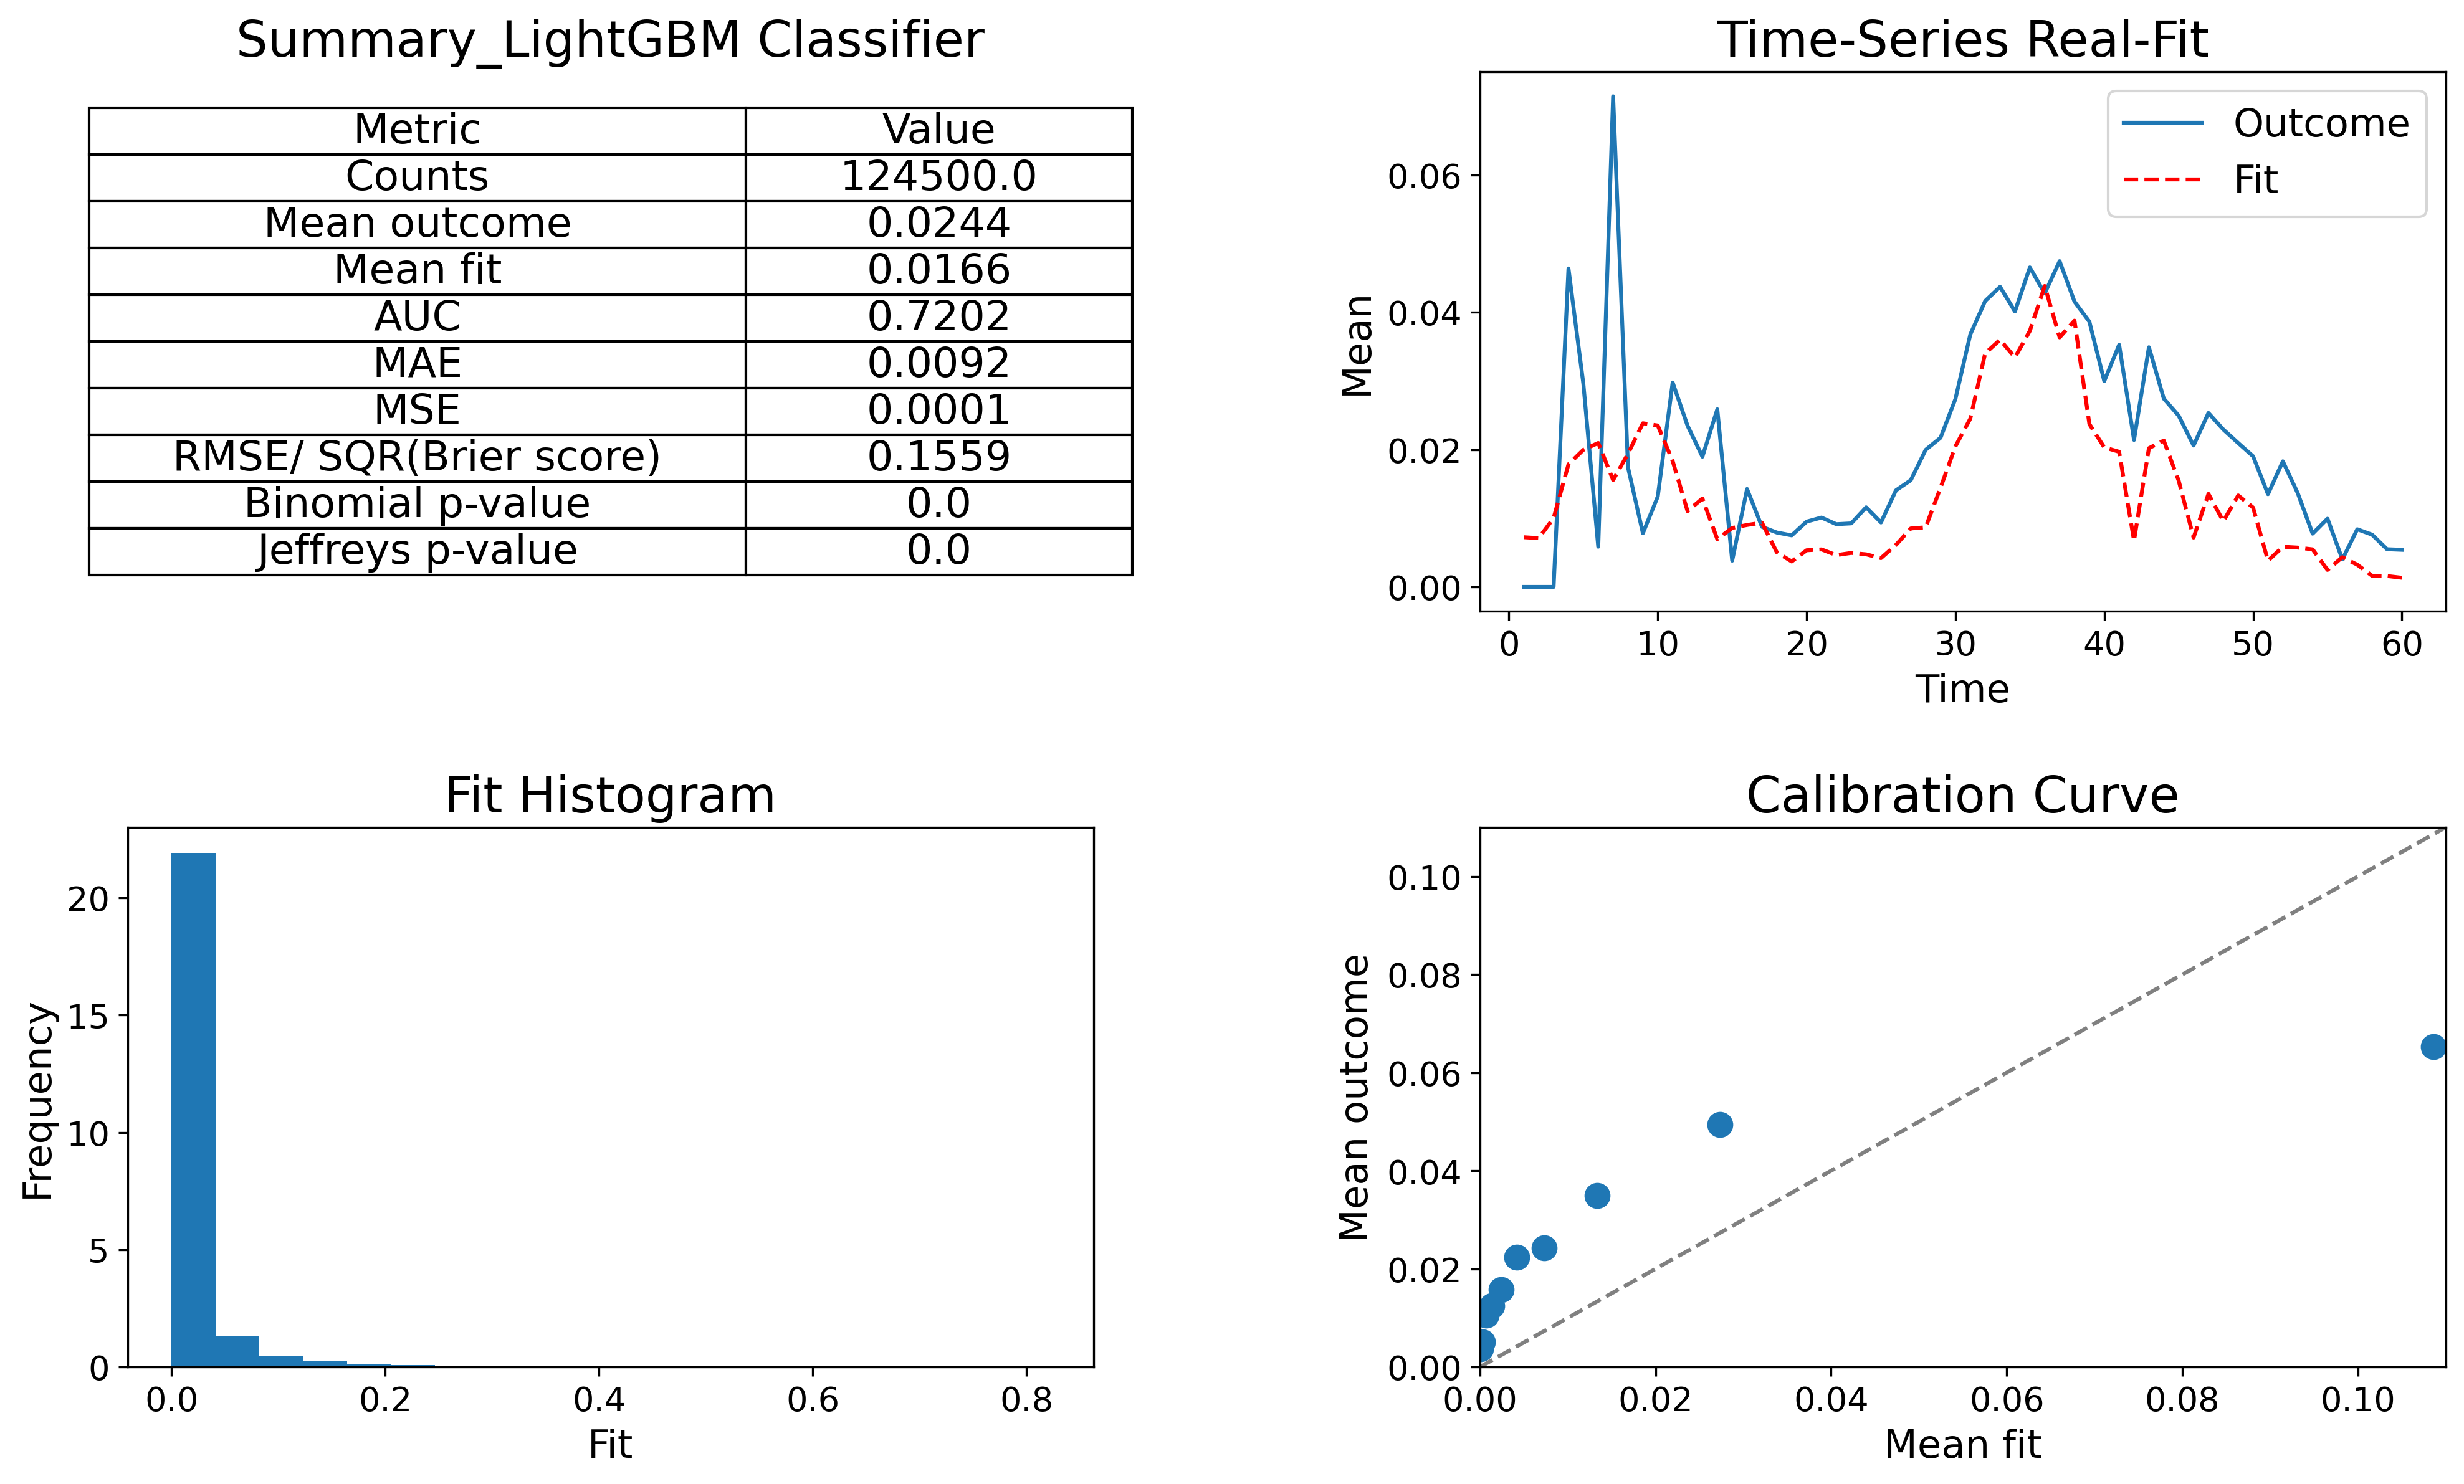

In [49]:
validation(lr_results['fit'].values, lr_results['outcome'].values, lr_results['time'].values, 'Logistic Regression')
validation(knn_results['fit'].values, knn_results['outcome'].values, knn_results['time'].values, 'KNN Classifier')
validation(svc_results['fit'].values, svc_results['outcome'].values, svc_results['time'].values, 'Support Vector Classifier')
validation(rf_results['fit'].values, rf_results['outcome'].values, rf_results['time'].values, 'Random Forest Classifier')
validation(xgbc_results['fit'].values, xgbc_results['outcome'].values, xgbc_results['time'].values, 'XGBoost Classifier')
validation(lgbc_results['fit'].values, lgbc_results['outcome'].values, lgbc_results['time'].values, 'LightGBM Classifier')
validation(nnc_results['fit'].values, nnc_results['outcome'].values, nnc_results['time'].values, 'Deep Neural Network Classifier')

### Notes:
* For this project, the main goal is to predict probability of default at aggregated level (period level), thus the model perfomance must be compared by aggregating probability of default on period level.
* In order to test for performance of selected models, out-of-sample performance results of each dataset are combined into 1 dataset to see which model perform better overall.
* **MAE, MSE**, **Calibration Curve** and **Time-Series Real-Fit** of each model are computed by combining out-of-sample predicted probability and actual observations of all datasets (5 in total) aggregated at period level. These are the key measurements for performance comparison of this project.
* **AUC** and **Brier score** are performance measurement at observation level so it is used to provide user the inution into model's accuracy on individual observation basis. These 2 measures are chosen since they are very often used for performance comparison as industry standard in Credit Risk. However, for this project they are regarded as complementary rather ultimate performance measurement due to our project goal.
* **Binomial p-value** and **Jeffreys p-value** are not of the interest of this project and are not proper performance comparers so we can ignore them.

### Observation:
* Best performer is **Random Forest** based on overall performance on various metrics. However, it tends to overact during stressed periods.
* **Logistic Regression** and **Support Vector Machine** overshoots PD projection in their entirety of prediction.
* **Deep Neural Network, XGBoost** and **LightGBM** do a decent job at forecasting but tend to underpredict PD.
* **KNN's** AUC suffers from its overfitting on training data (as a result of n_neighbors = 1 – obtained from tunning) resulting in too many actual negative cases labelled as positive and vice versa (please check the confusion matrix below for more info about this behavior of KNN).  

## 2. Confusion matrix for aggregated results:

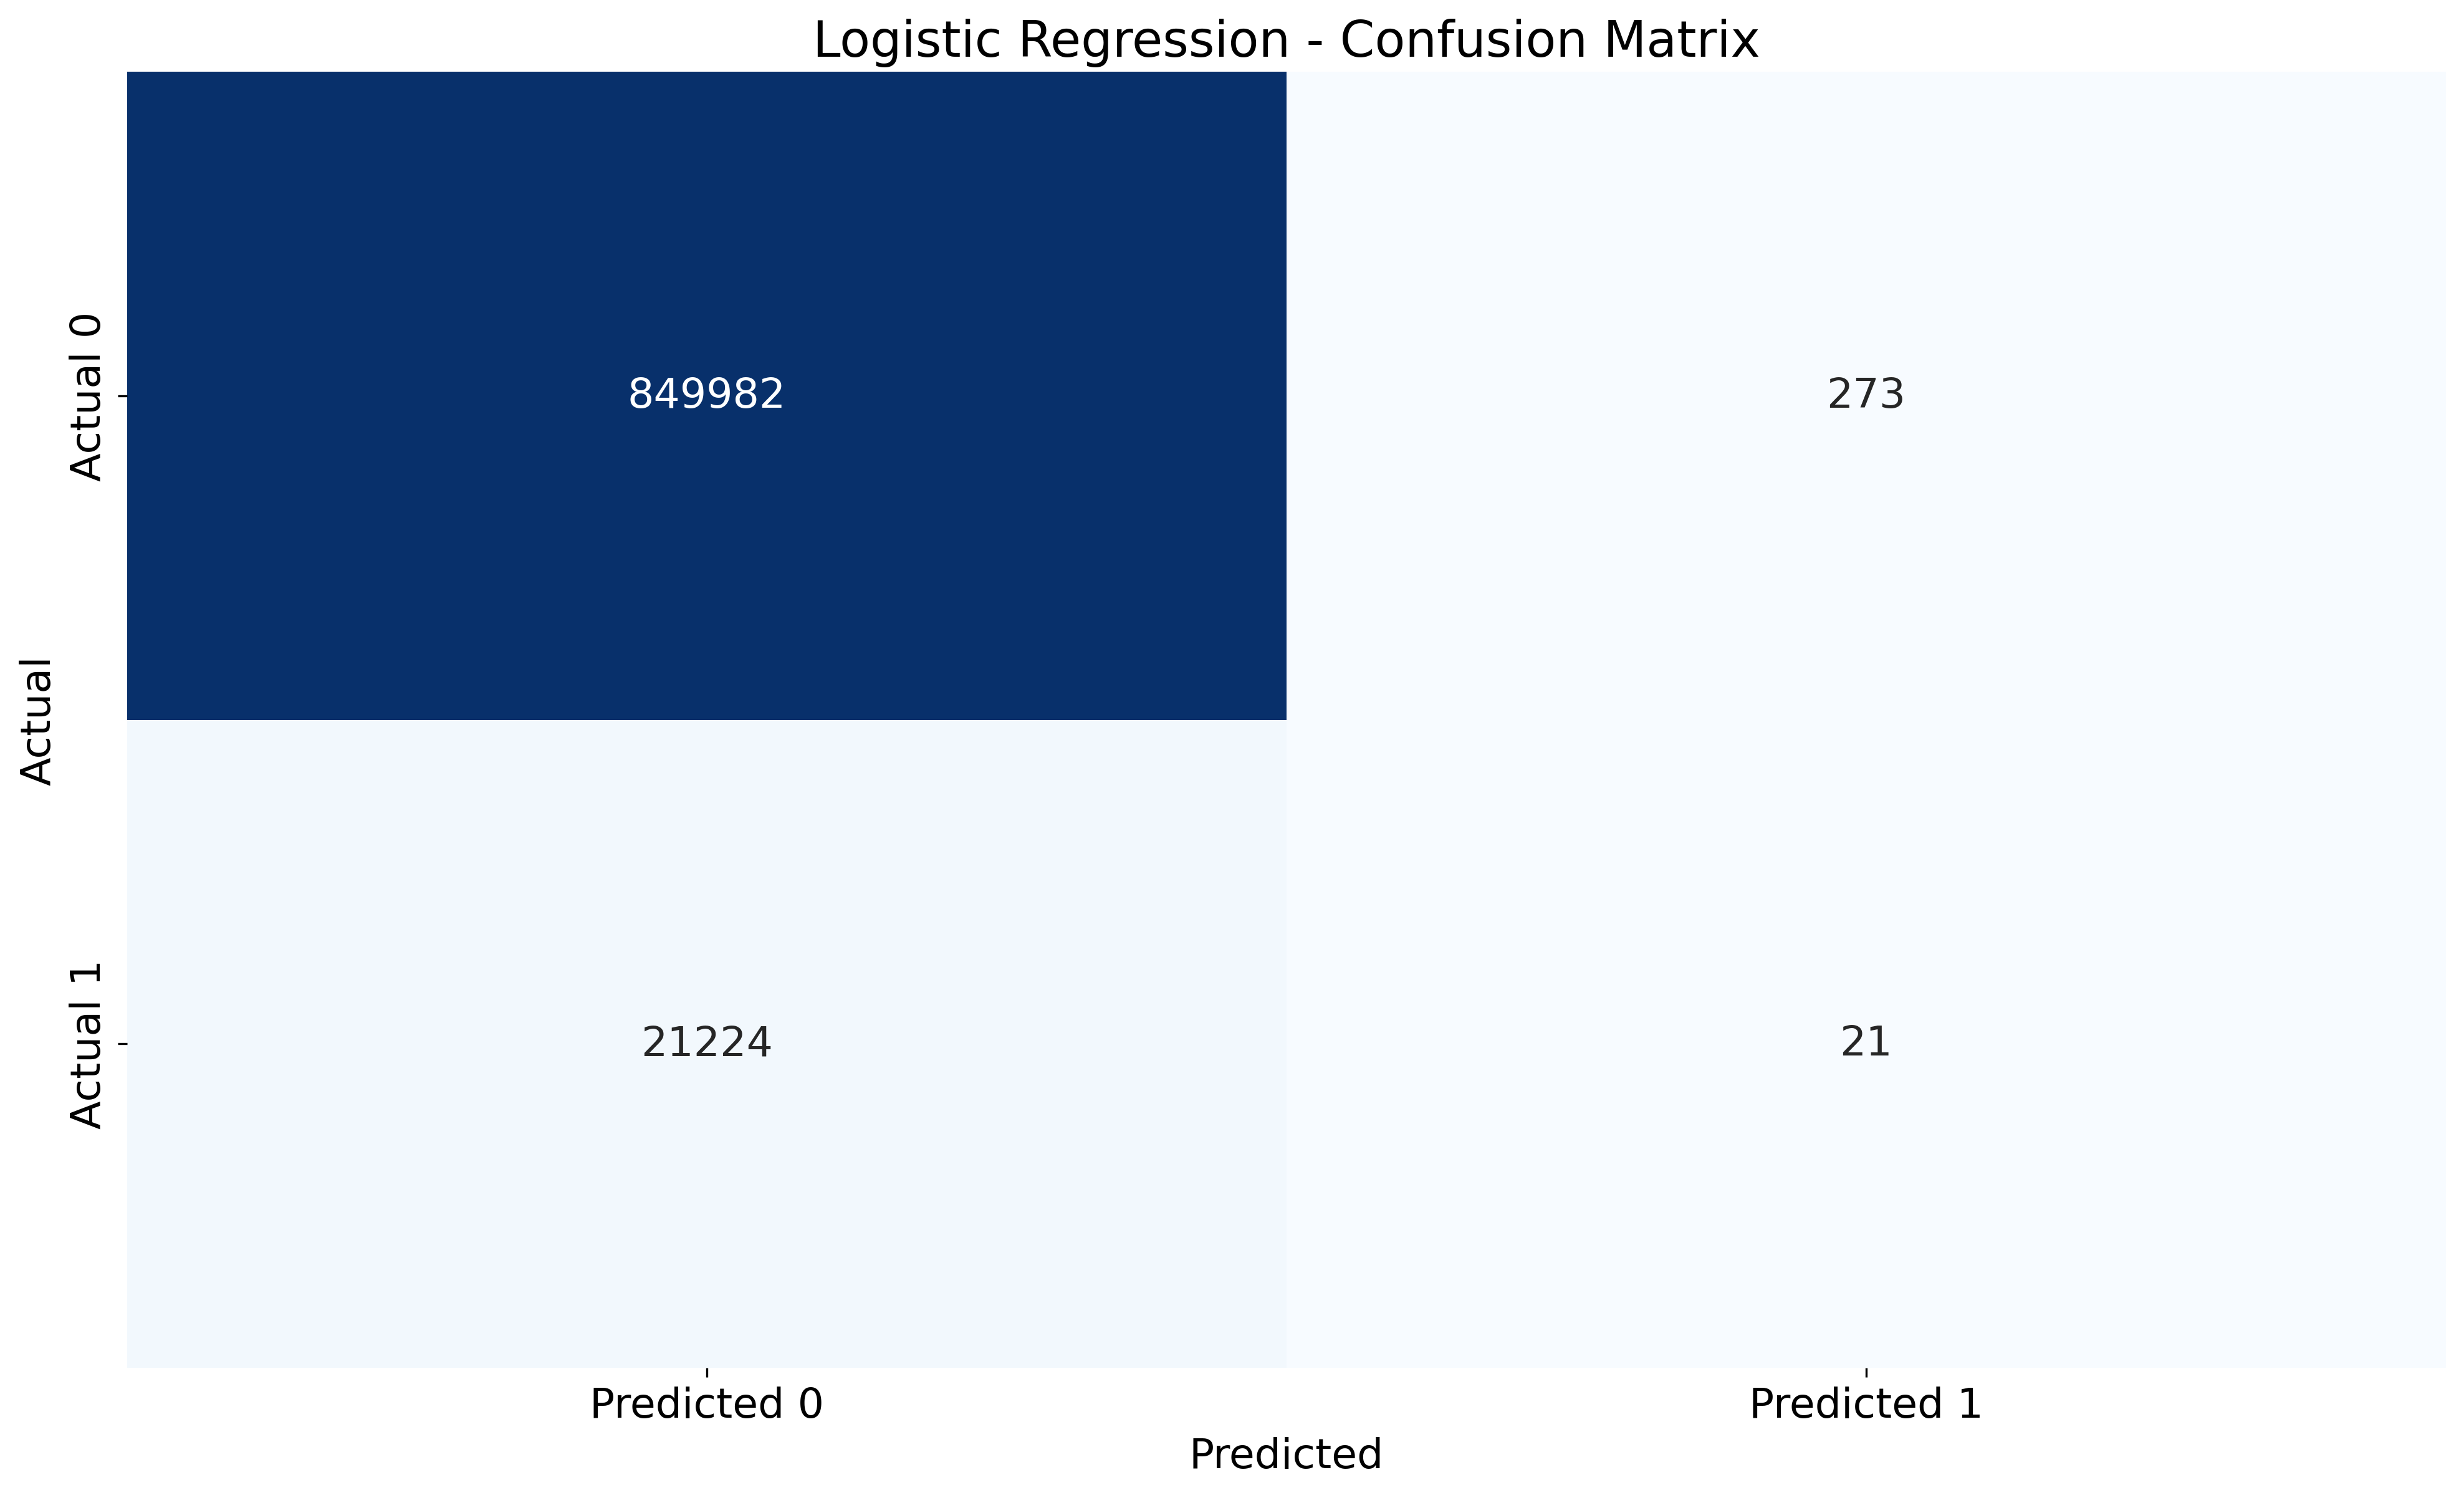

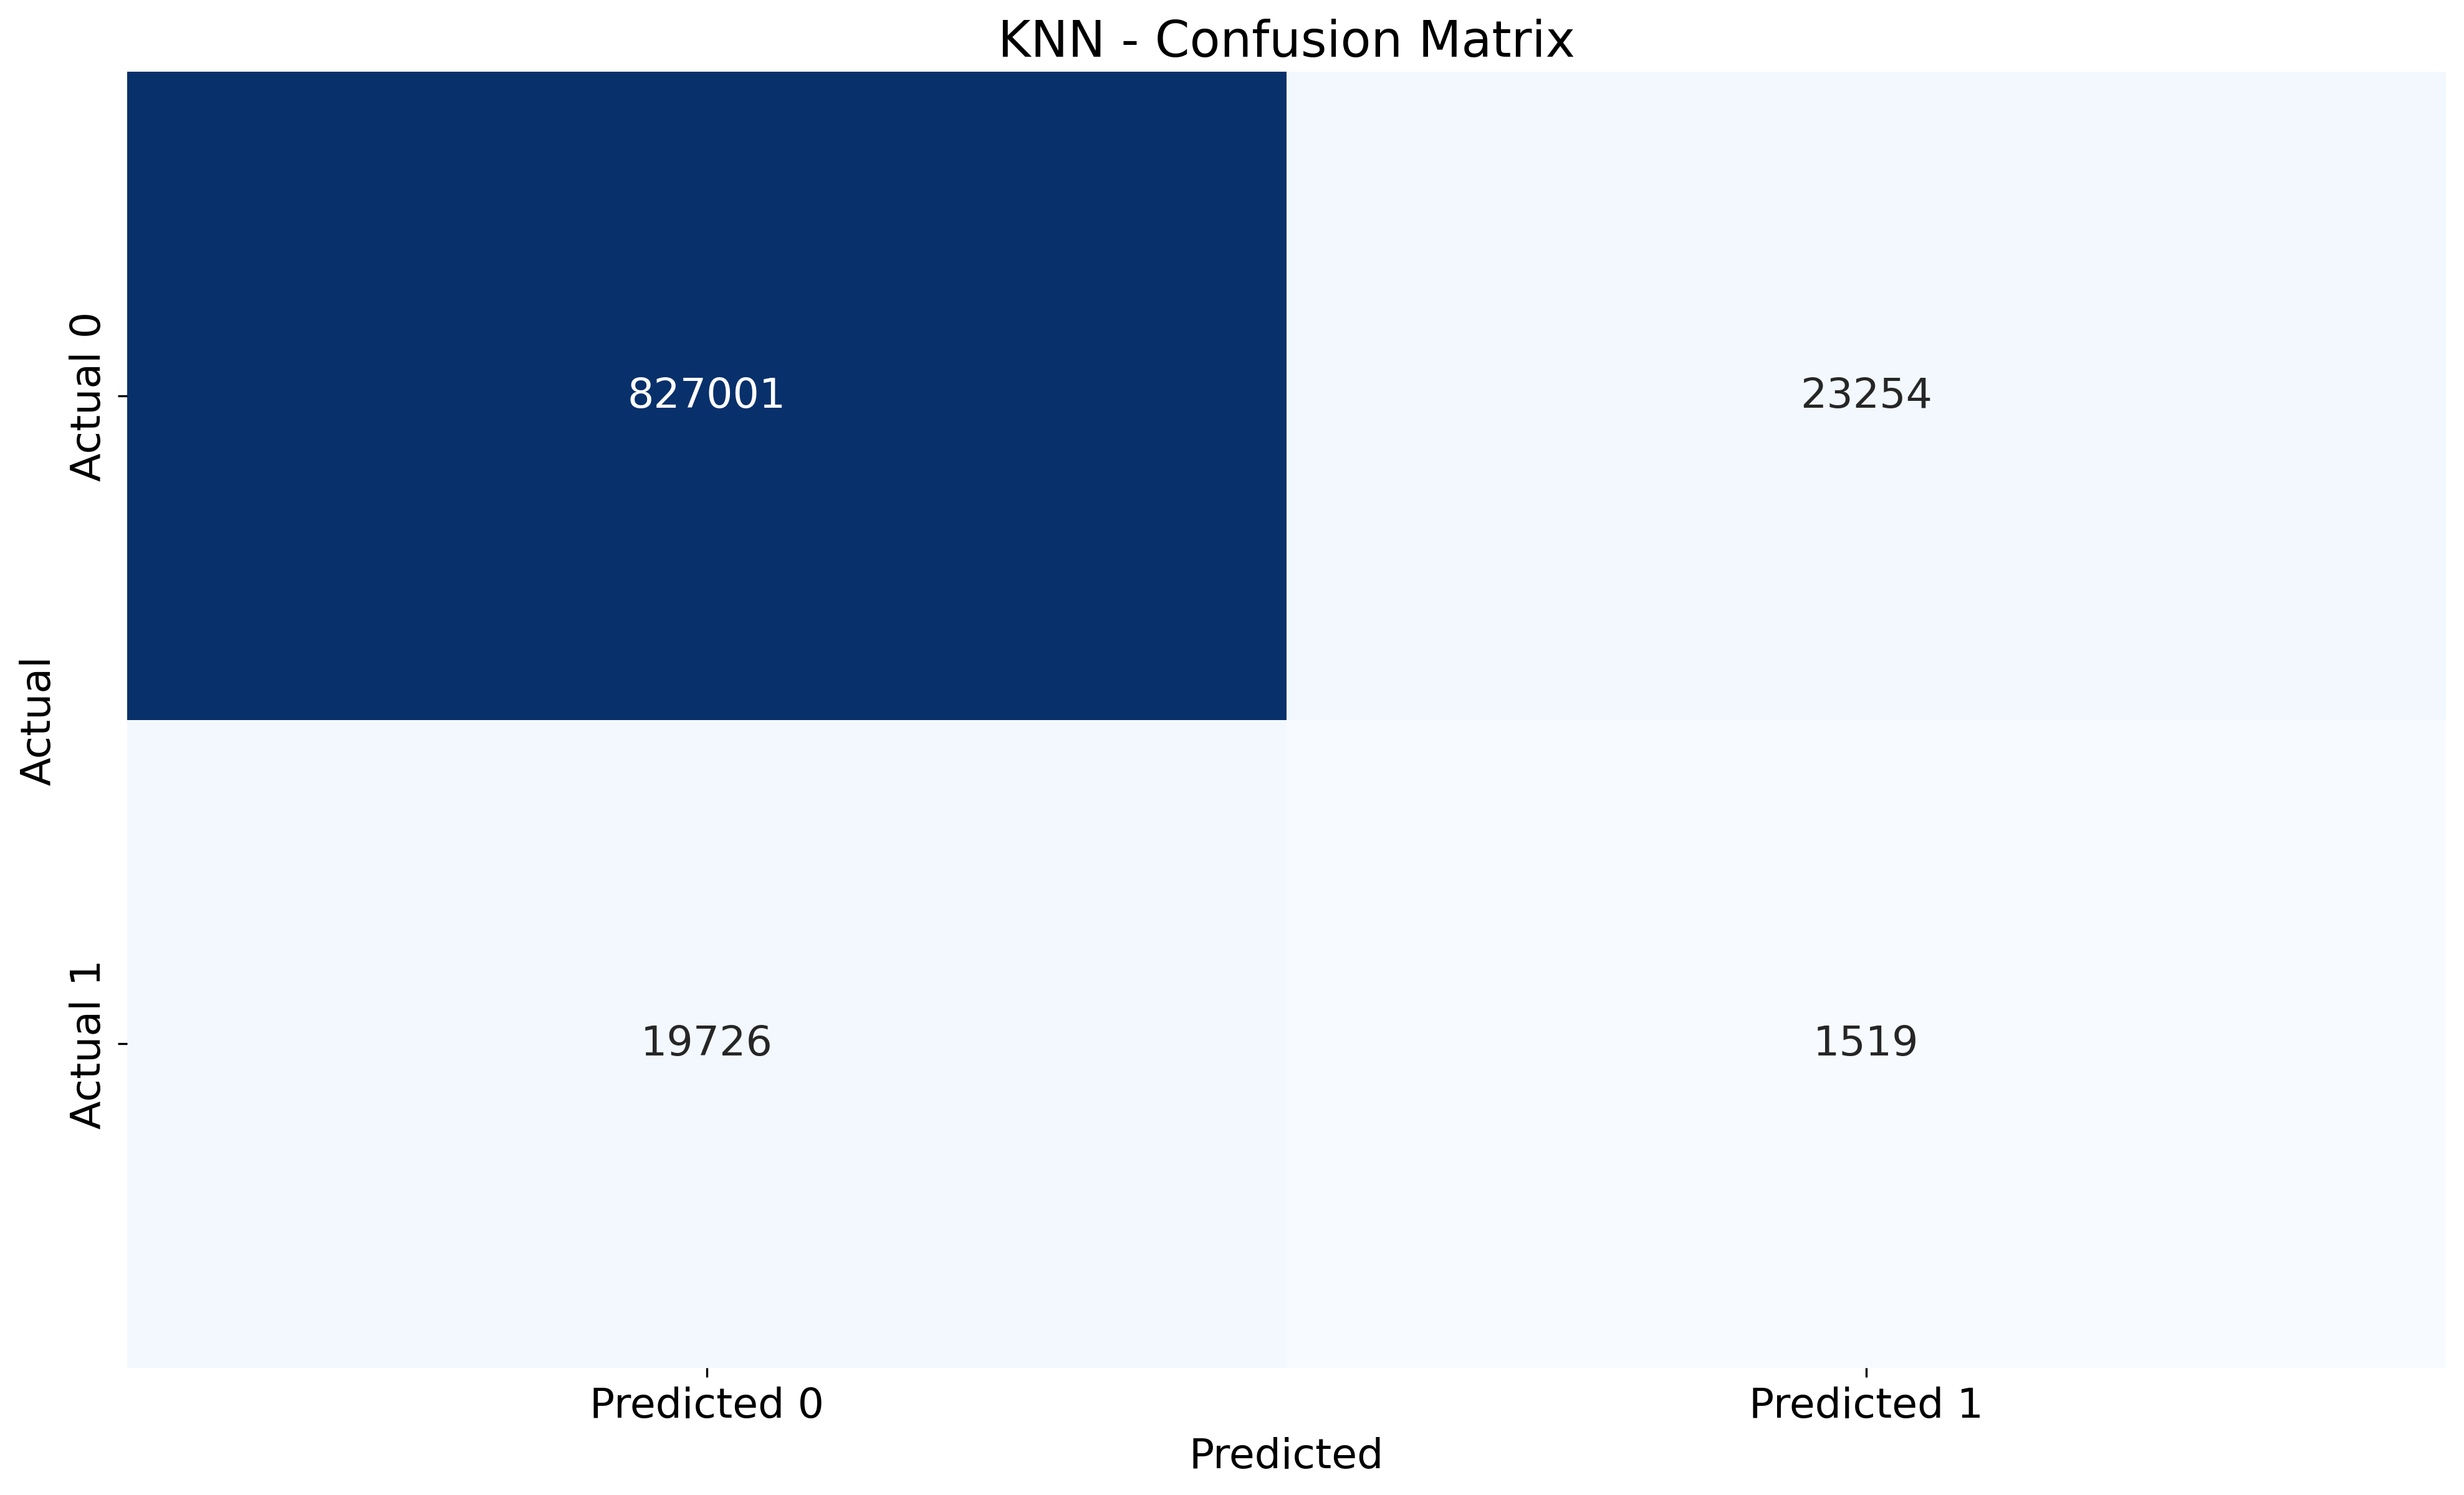

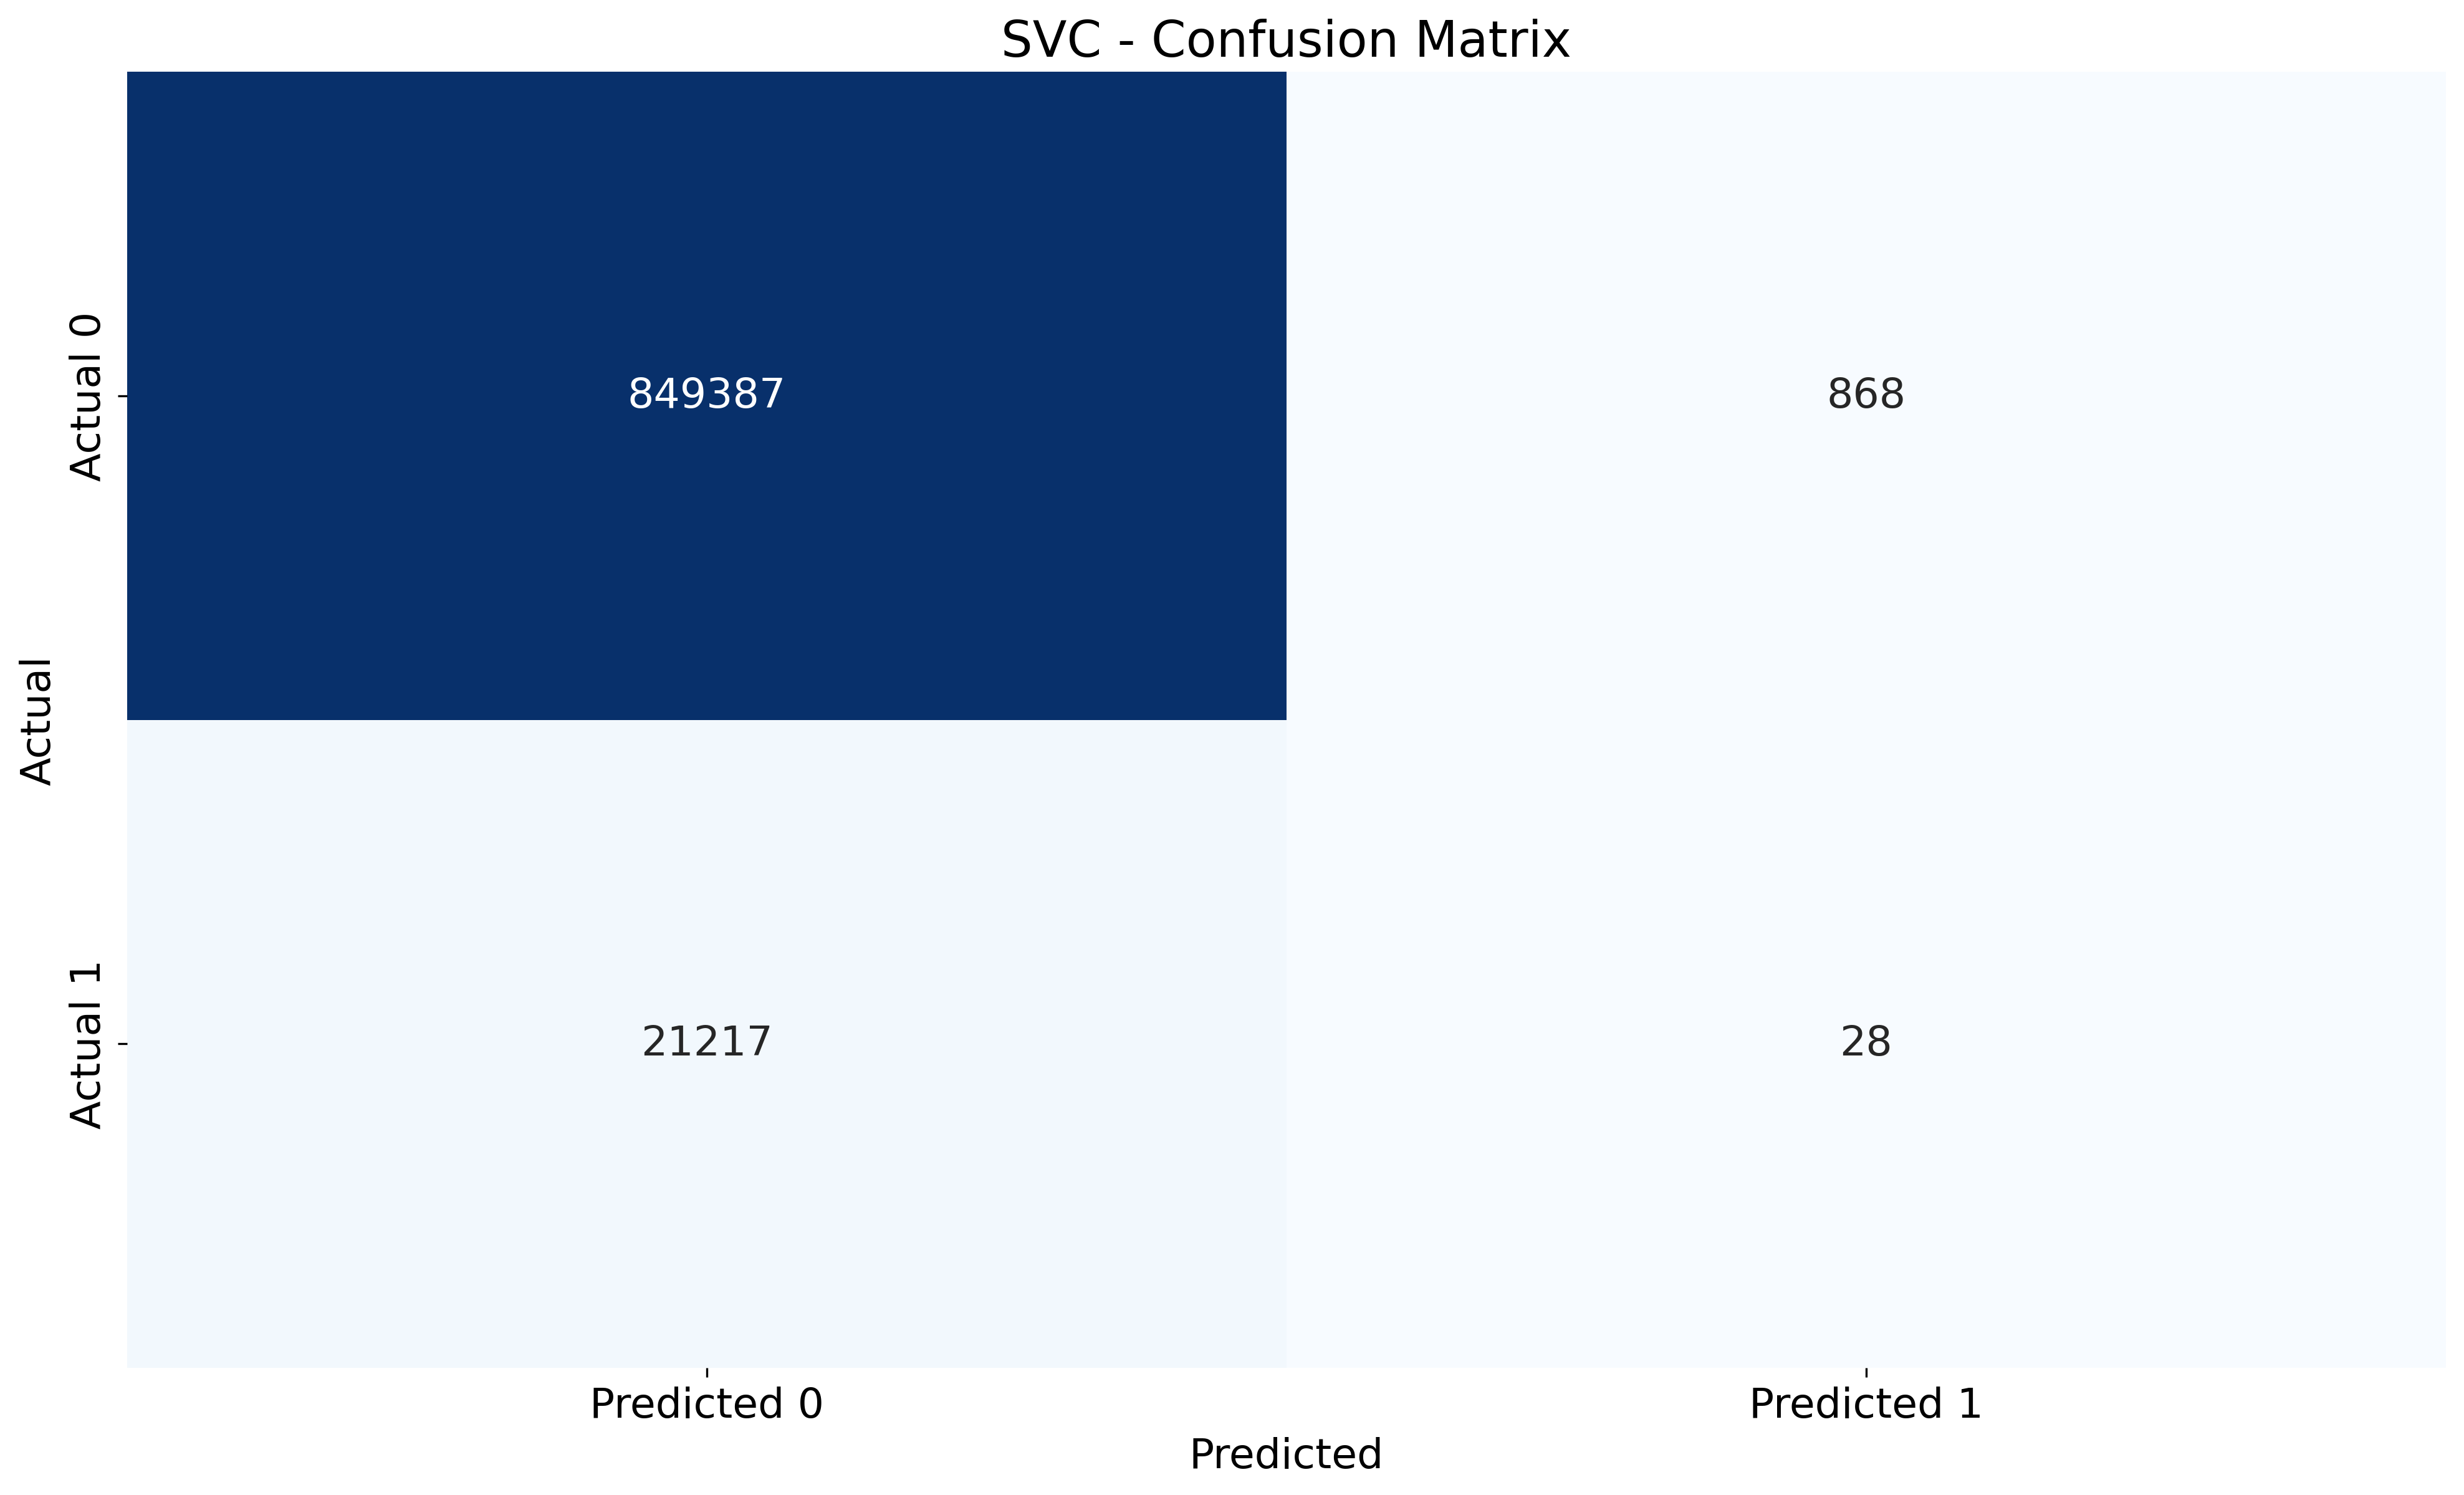

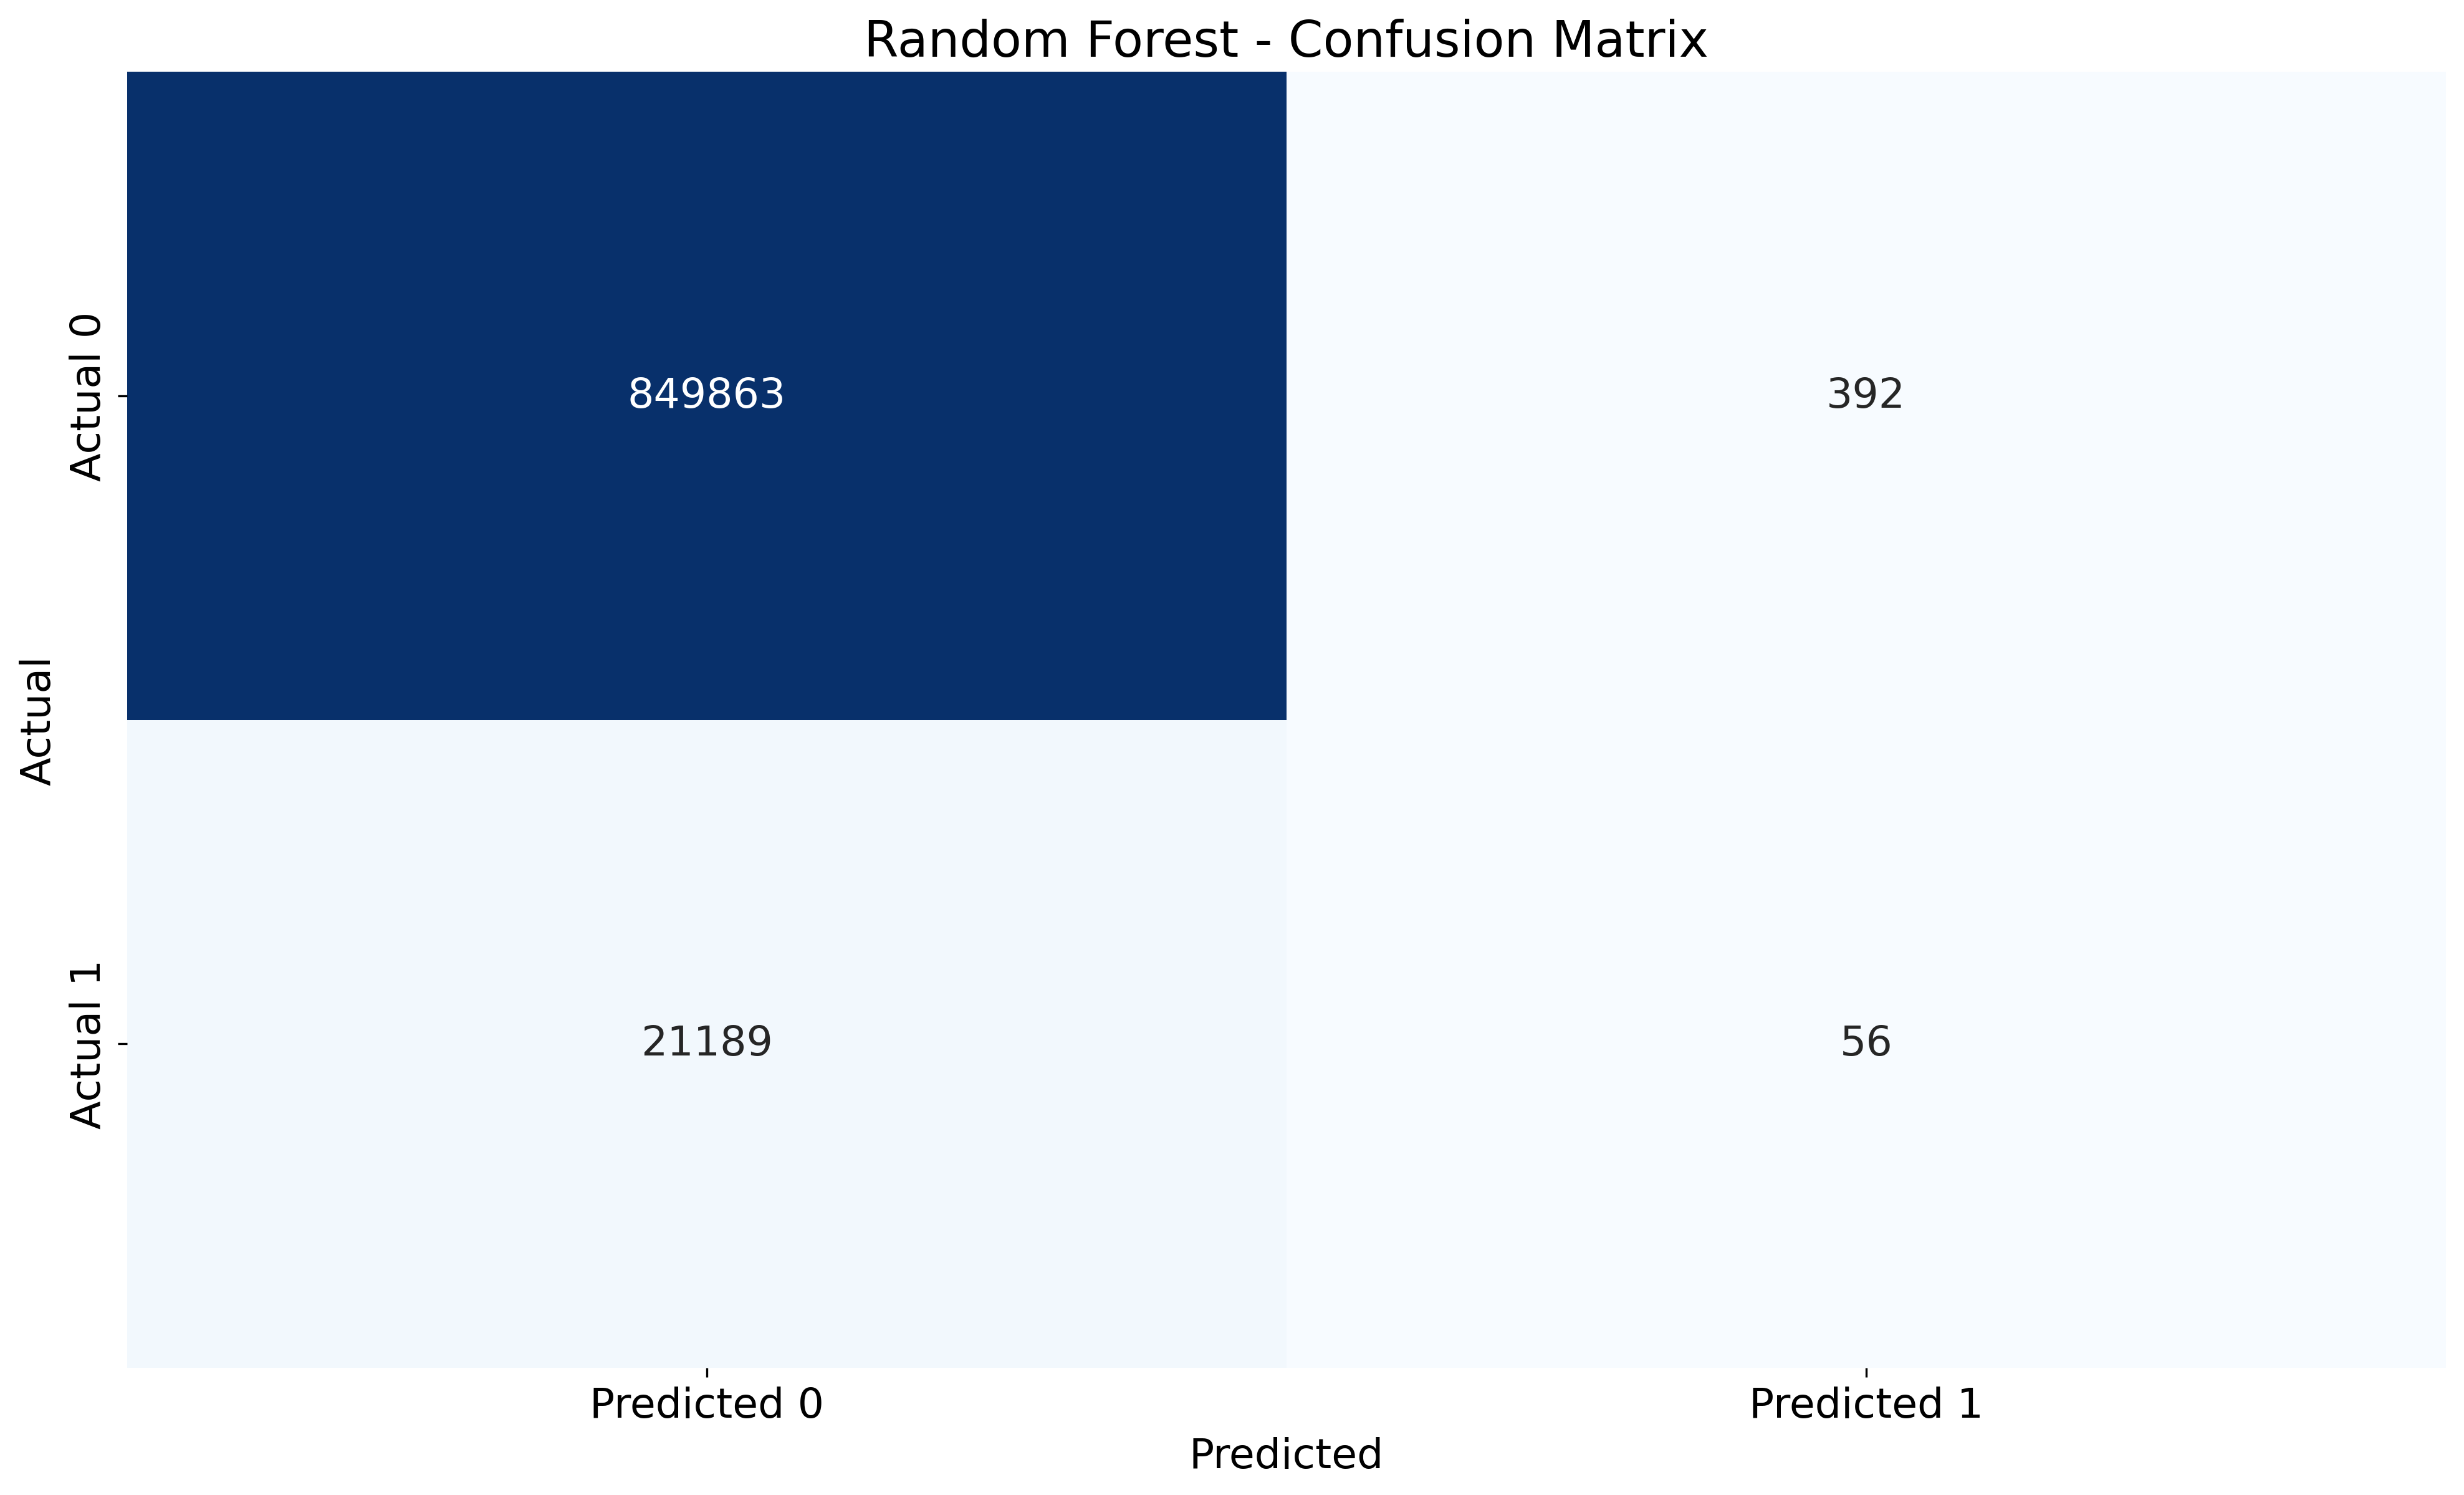

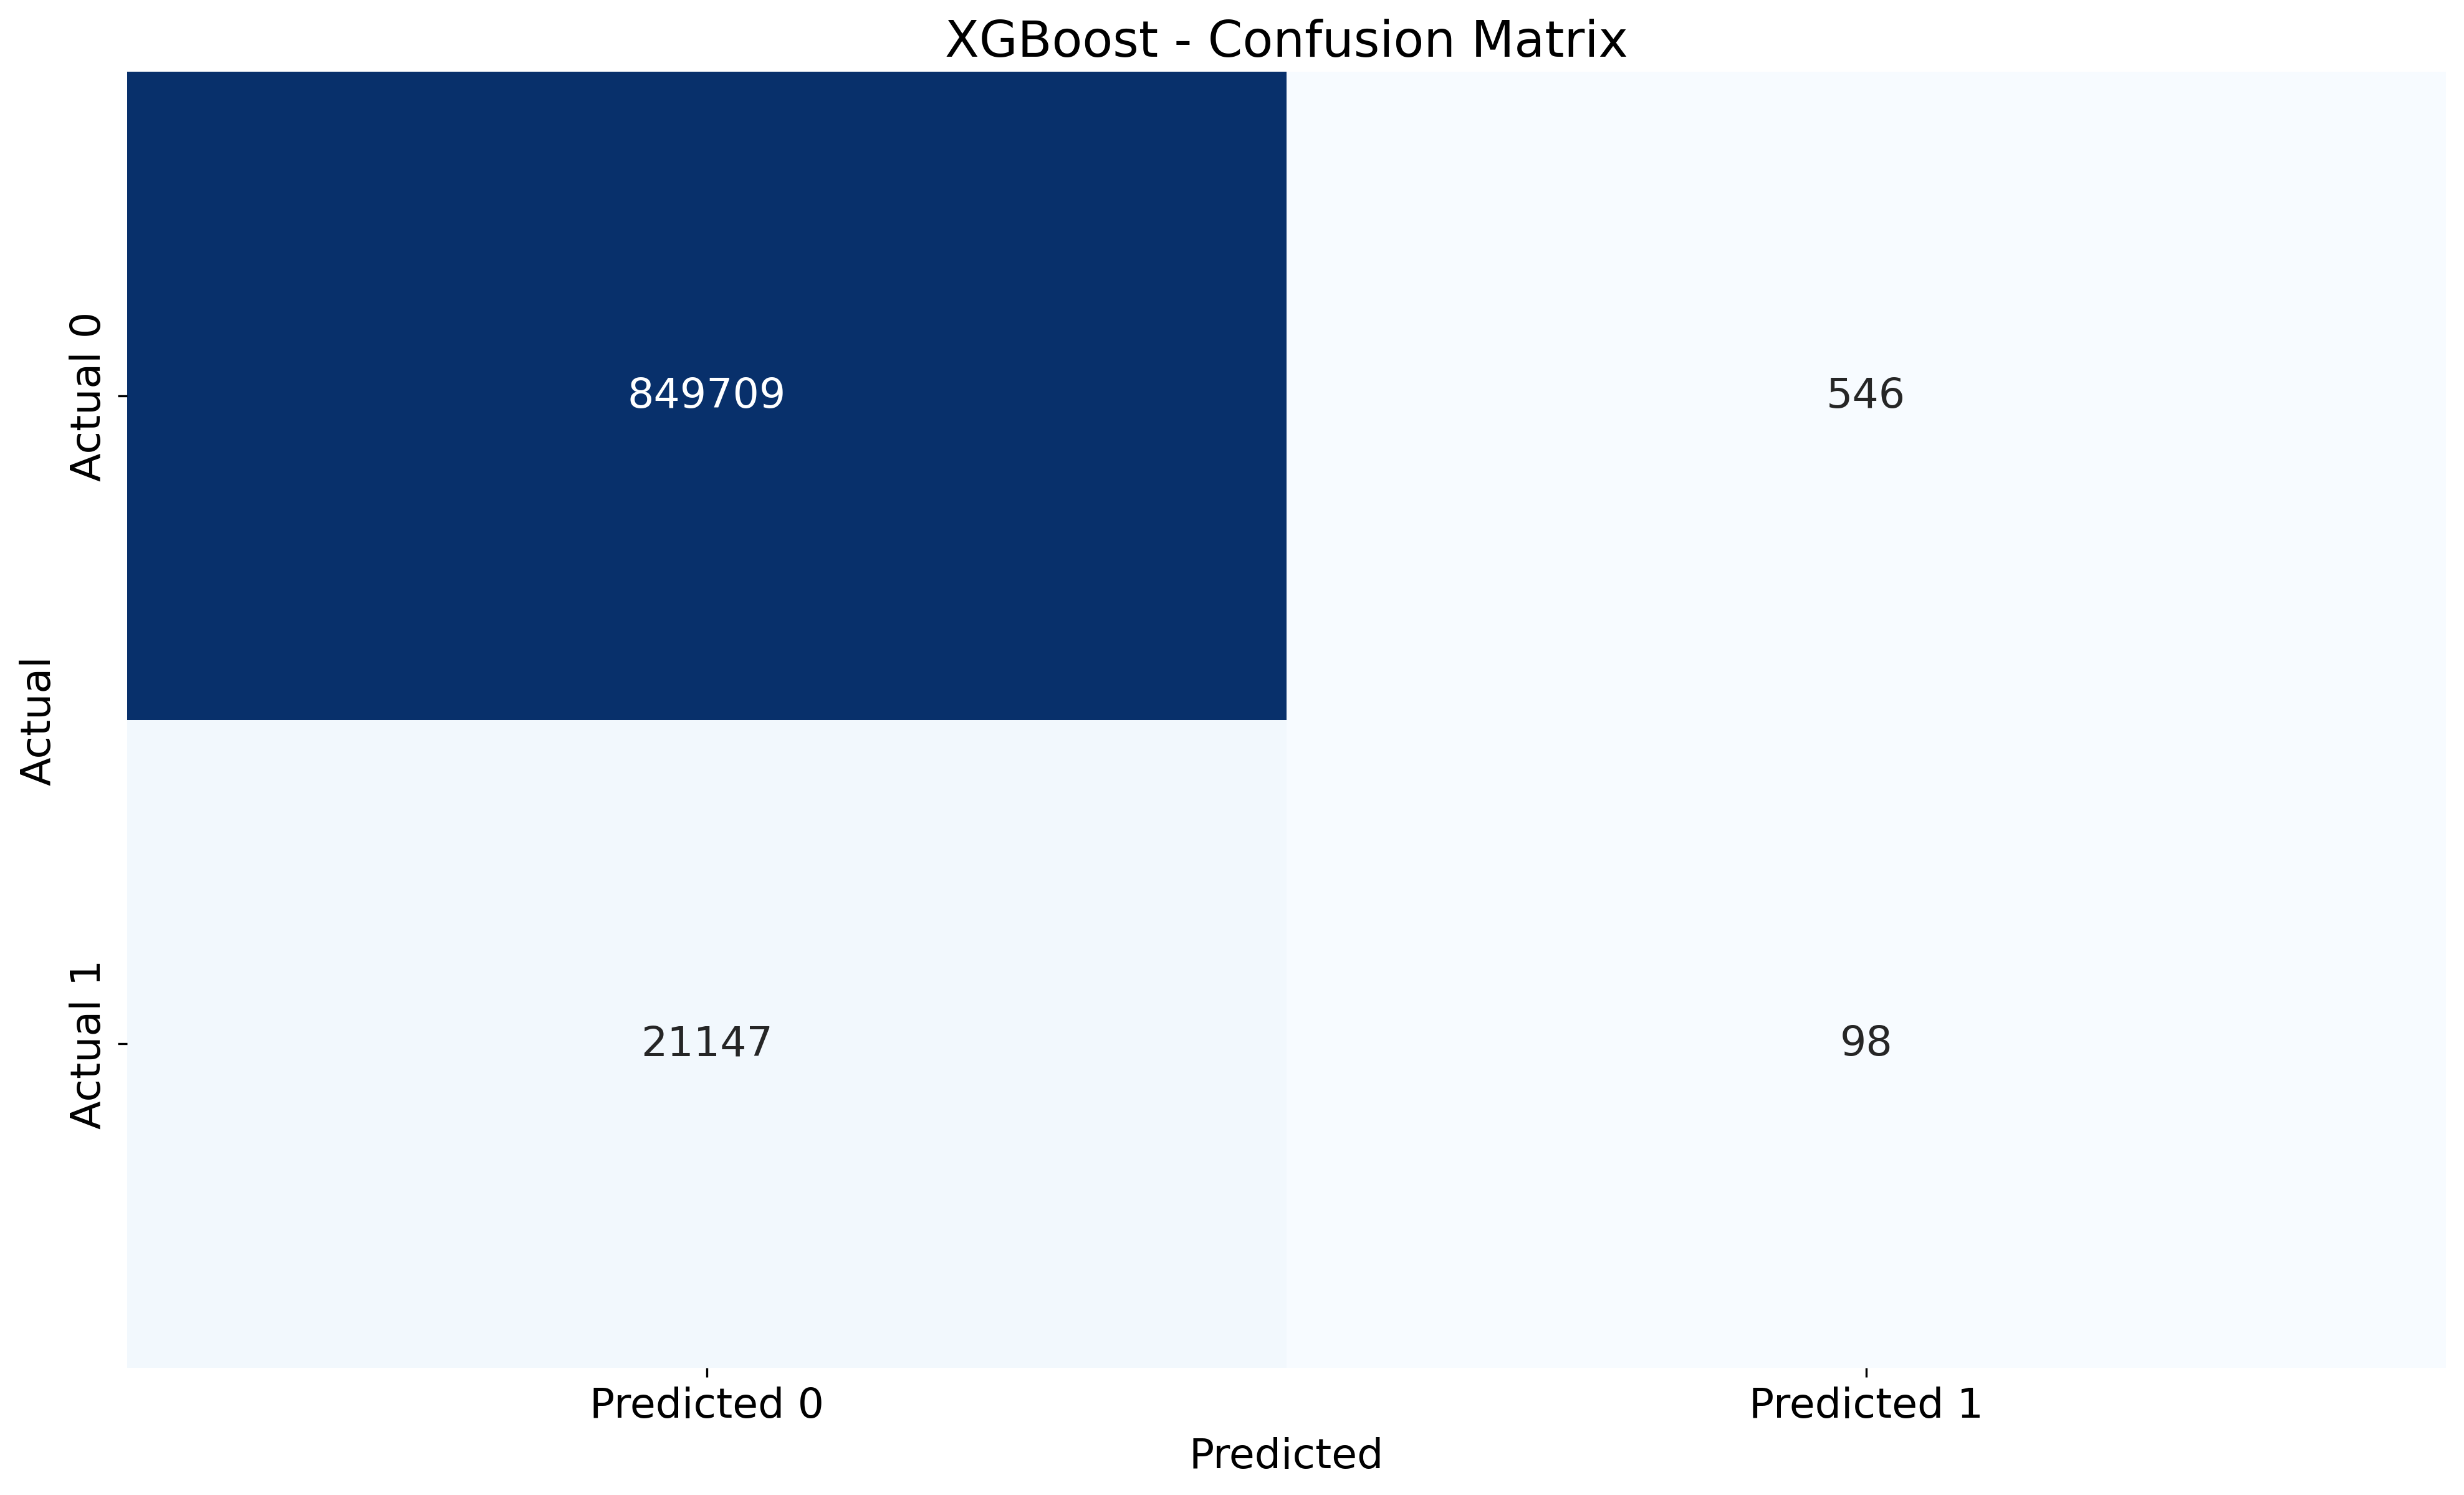

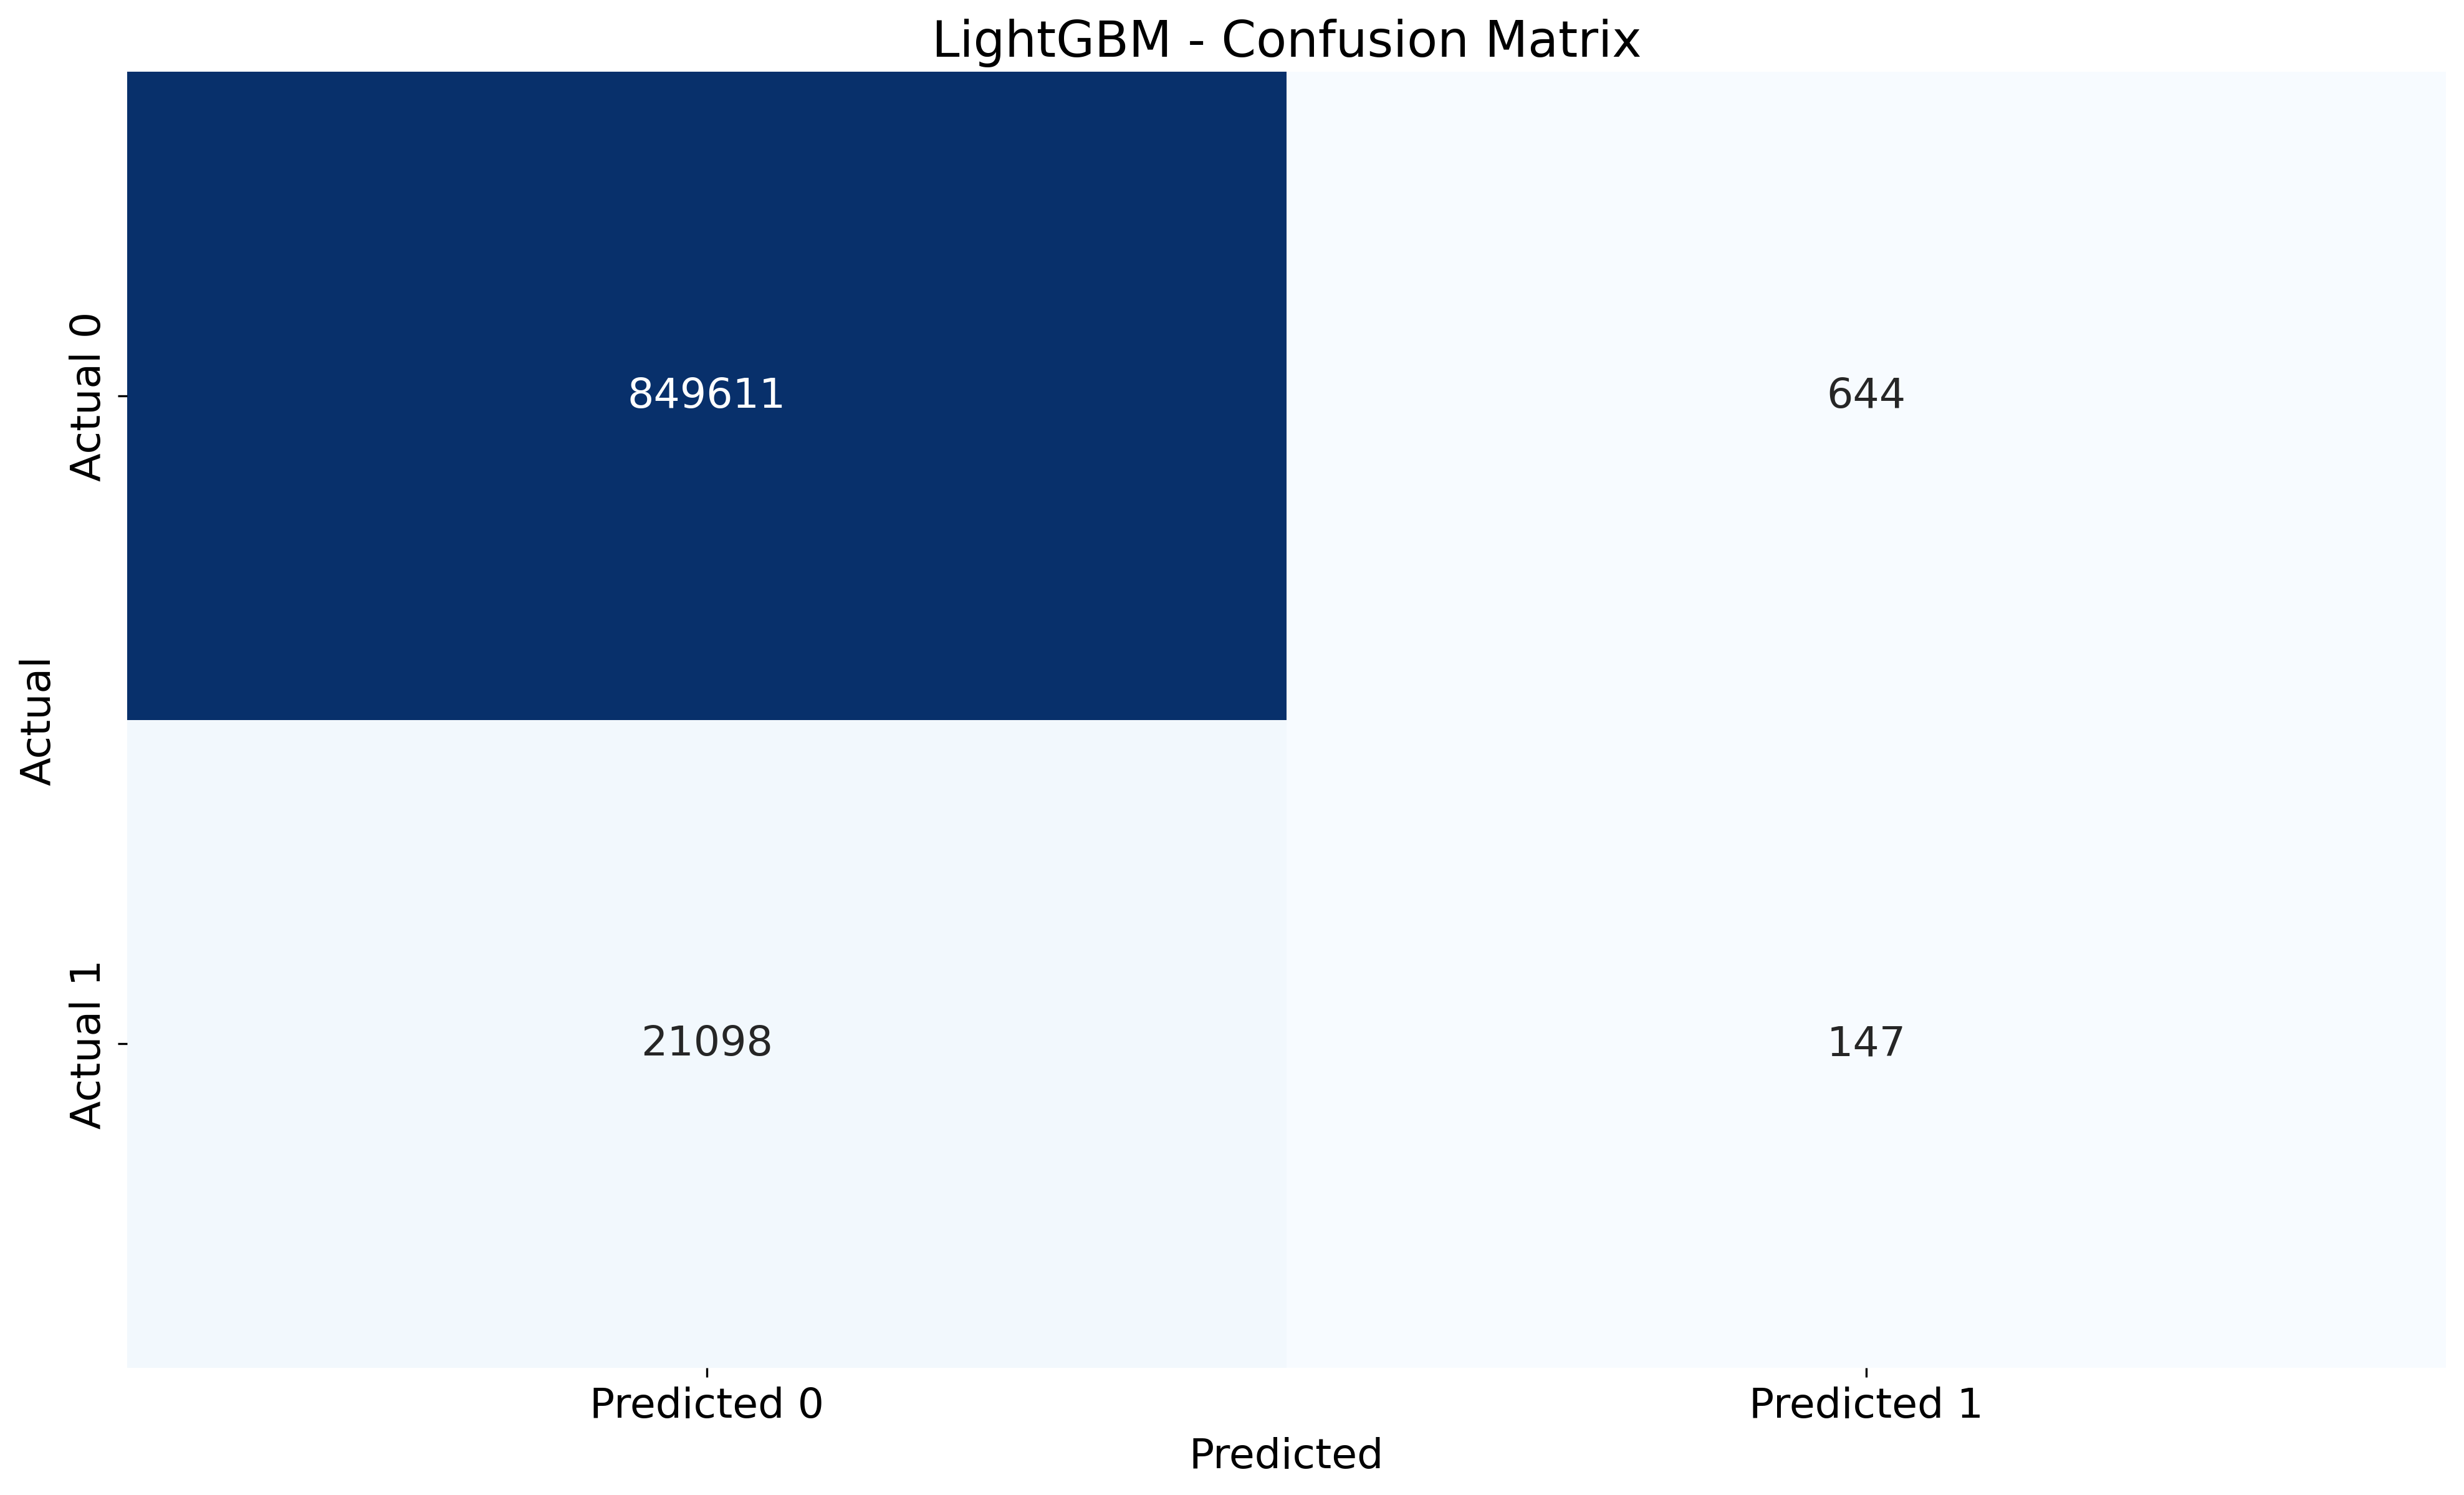

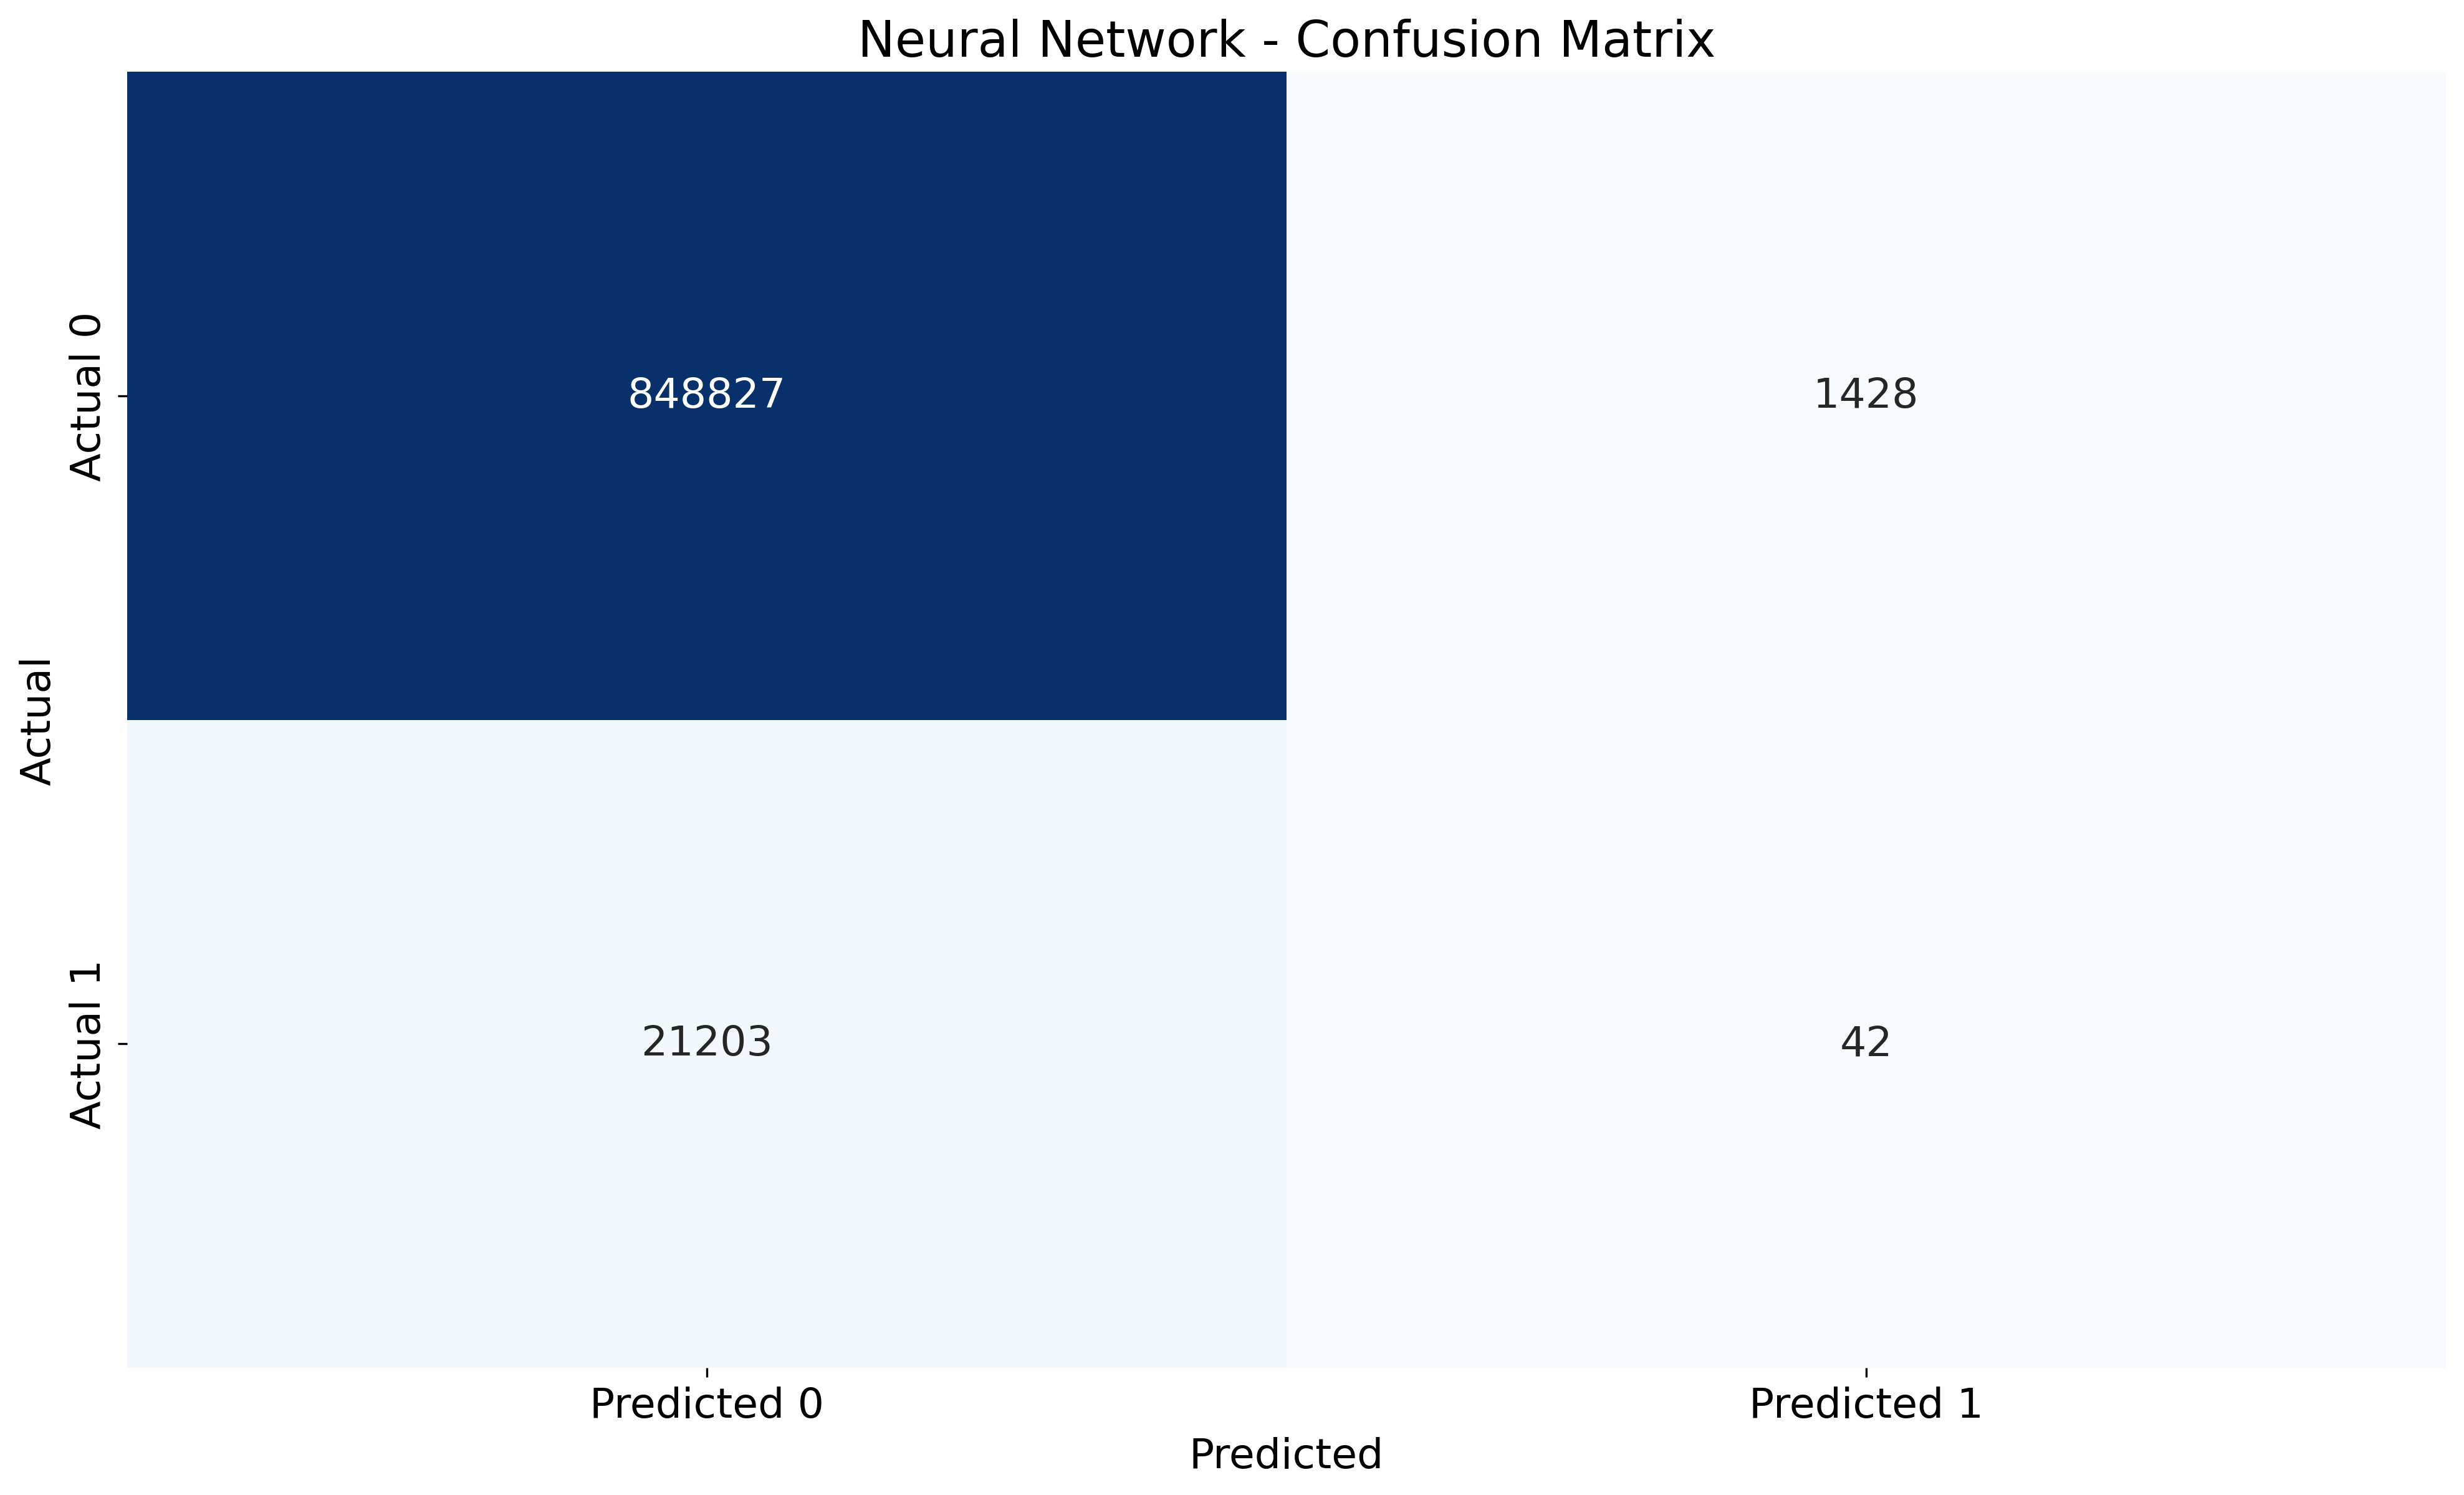

In [50]:
lr_confusion_matrix = pd.DataFrame(columns = ['fit', 'outcome'])
knn_confusion_matrix = pd.DataFrame(columns = ['fit', 'outcome'])
svc_confusion_matrix = pd.DataFrame(columns = ['fit', 'outcome'])
rf_confusion_matrix = pd.DataFrame(columns = ['fit', 'outcome'])
xgbc_confusion_matrix = pd.DataFrame(columns = ['fit', 'outcome'])
lgbc_confusion_matrix = pd.DataFrame(columns = ['fit', 'outcome'])
nnc_confusion_matrix = pd.DataFrame(columns = ['fit', 'outcome'])

for i in range(len(dataset)):
    for j in model_params:
        
        lr_df = pd.DataFrame({'fit': out_sample_df[f'model_lr_prediction_{i}'].tolist(),
                   'outcome': out_sample_df[f'model_lr_y_test_{i}'].tolist()})
        lr_confusion_matrix = pd.concat([lr_confusion_matrix, lr_df])
        
        knn_df = pd.DataFrame({'fit': out_sample_df[f'model_knn_prediction_{i}'].tolist(),
                   'outcome': out_sample_df[f'model_knn_y_test_{i}'].tolist()})
        knn_confusion_matrix = pd.concat([knn_confusion_matrix, knn_df])
        
        svc_df = pd.DataFrame({'fit': out_sample_df[f'model_svc_prediction_{i}'].tolist(),
                   'outcome': out_sample_df[f'model_svc_y_test_{i}'].tolist()})
        svc_confusion_matrix = pd.concat([svc_confusion_matrix, svc_df])
        
        rf_df = pd.DataFrame({'fit': out_sample_df[f'model_rf_prediction_{i}'].tolist(),
                   'outcome': out_sample_df[f'model_rf_y_test_{i}'].tolist()})
        rf_confusion_matrix = pd.concat([rf_confusion_matrix, rf_df])
        
        xgbc_df = pd.DataFrame({'fit': out_sample_df[f'model_xgbc_prediction_{i}'].tolist(),
                   'outcome': out_sample_df[f'model_xgbc_y_test_{i}'].tolist()})
        xgbc_confusion_matrix = pd.concat([xgbc_confusion_matrix, xgbc_df])
        
        lgbc_df = pd.DataFrame({'fit': out_sample_df[f'model_lgbc_prediction_{i}'].tolist(),
                   'outcome': out_sample_df[f'model_lgbc_y_test_{i}'].tolist()})
        lgbc_confusion_matrix = pd.concat([lgbc_confusion_matrix, lgbc_df])
        
        nnc_df = pd.DataFrame({'fit': out_sample_df[f'model_nnc_prediction_{i}'].tolist(),
                   'outcome': out_sample_df[f'model_nnc_y_test_{i}'].tolist()})
        nnc_confusion_matrix = pd.concat([nnc_confusion_matrix, nnc_df])

# Visualizing confusion matrix in a tabular form:
lr_matrix = confusion_matrix(lr_confusion_matrix['outcome'].tolist(), lr_confusion_matrix['fit'].tolist())
knn_matrix = confusion_matrix(knn_confusion_matrix['outcome'].tolist(), knn_confusion_matrix['fit'].tolist())
svc_matrix = confusion_matrix(svc_confusion_matrix['outcome'].tolist(), svc_confusion_matrix['fit'].tolist())
rf_matrix = confusion_matrix(rf_confusion_matrix['outcome'].tolist(), rf_confusion_matrix['fit'].tolist())
xgbc_matrix = confusion_matrix(xgbc_confusion_matrix['outcome'].tolist(), xgbc_confusion_matrix['fit'].tolist())
lgbc_matrix = confusion_matrix(lgbc_confusion_matrix['outcome'].tolist(), lgbc_confusion_matrix['fit'].tolist())
nnc_matrix = confusion_matrix(nnc_confusion_matrix['outcome'].tolist(), nnc_confusion_matrix['fit'].tolist())

matrix_dict = {'Logistic Regression':lr_matrix, 'KNN':knn_matrix, 'SVC':svc_matrix, 'Random Forest':rf_matrix, 
               'XGBoost':xgbc_matrix, 'LightGBM':lgbc_matrix, 'Neural Network': nnc_matrix}

models = ['Logistic Regression', 'KNN', 'SVC', 'Random Forest', 'XGBoost', 'LightGBM', 'Neural Network']
for model in models:
    sns.heatmap(matrix_dict[model], annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])
    
    plt.title(f'{model} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

On loan level, it looks all the models do a poor job as predicting correctly default cases (default = 1) as they tend to label most of observations in the testing dataset as negative class (default = 0). The number of correct default label (bottom right corner of confusion matrix) is miniscule compared to the correct non-default label (top left corner). This is expected as the data is very imbalanced with majority class observations overrepresented in any bin/strata.  

## 3. Plotting distribution of out of sample observation:

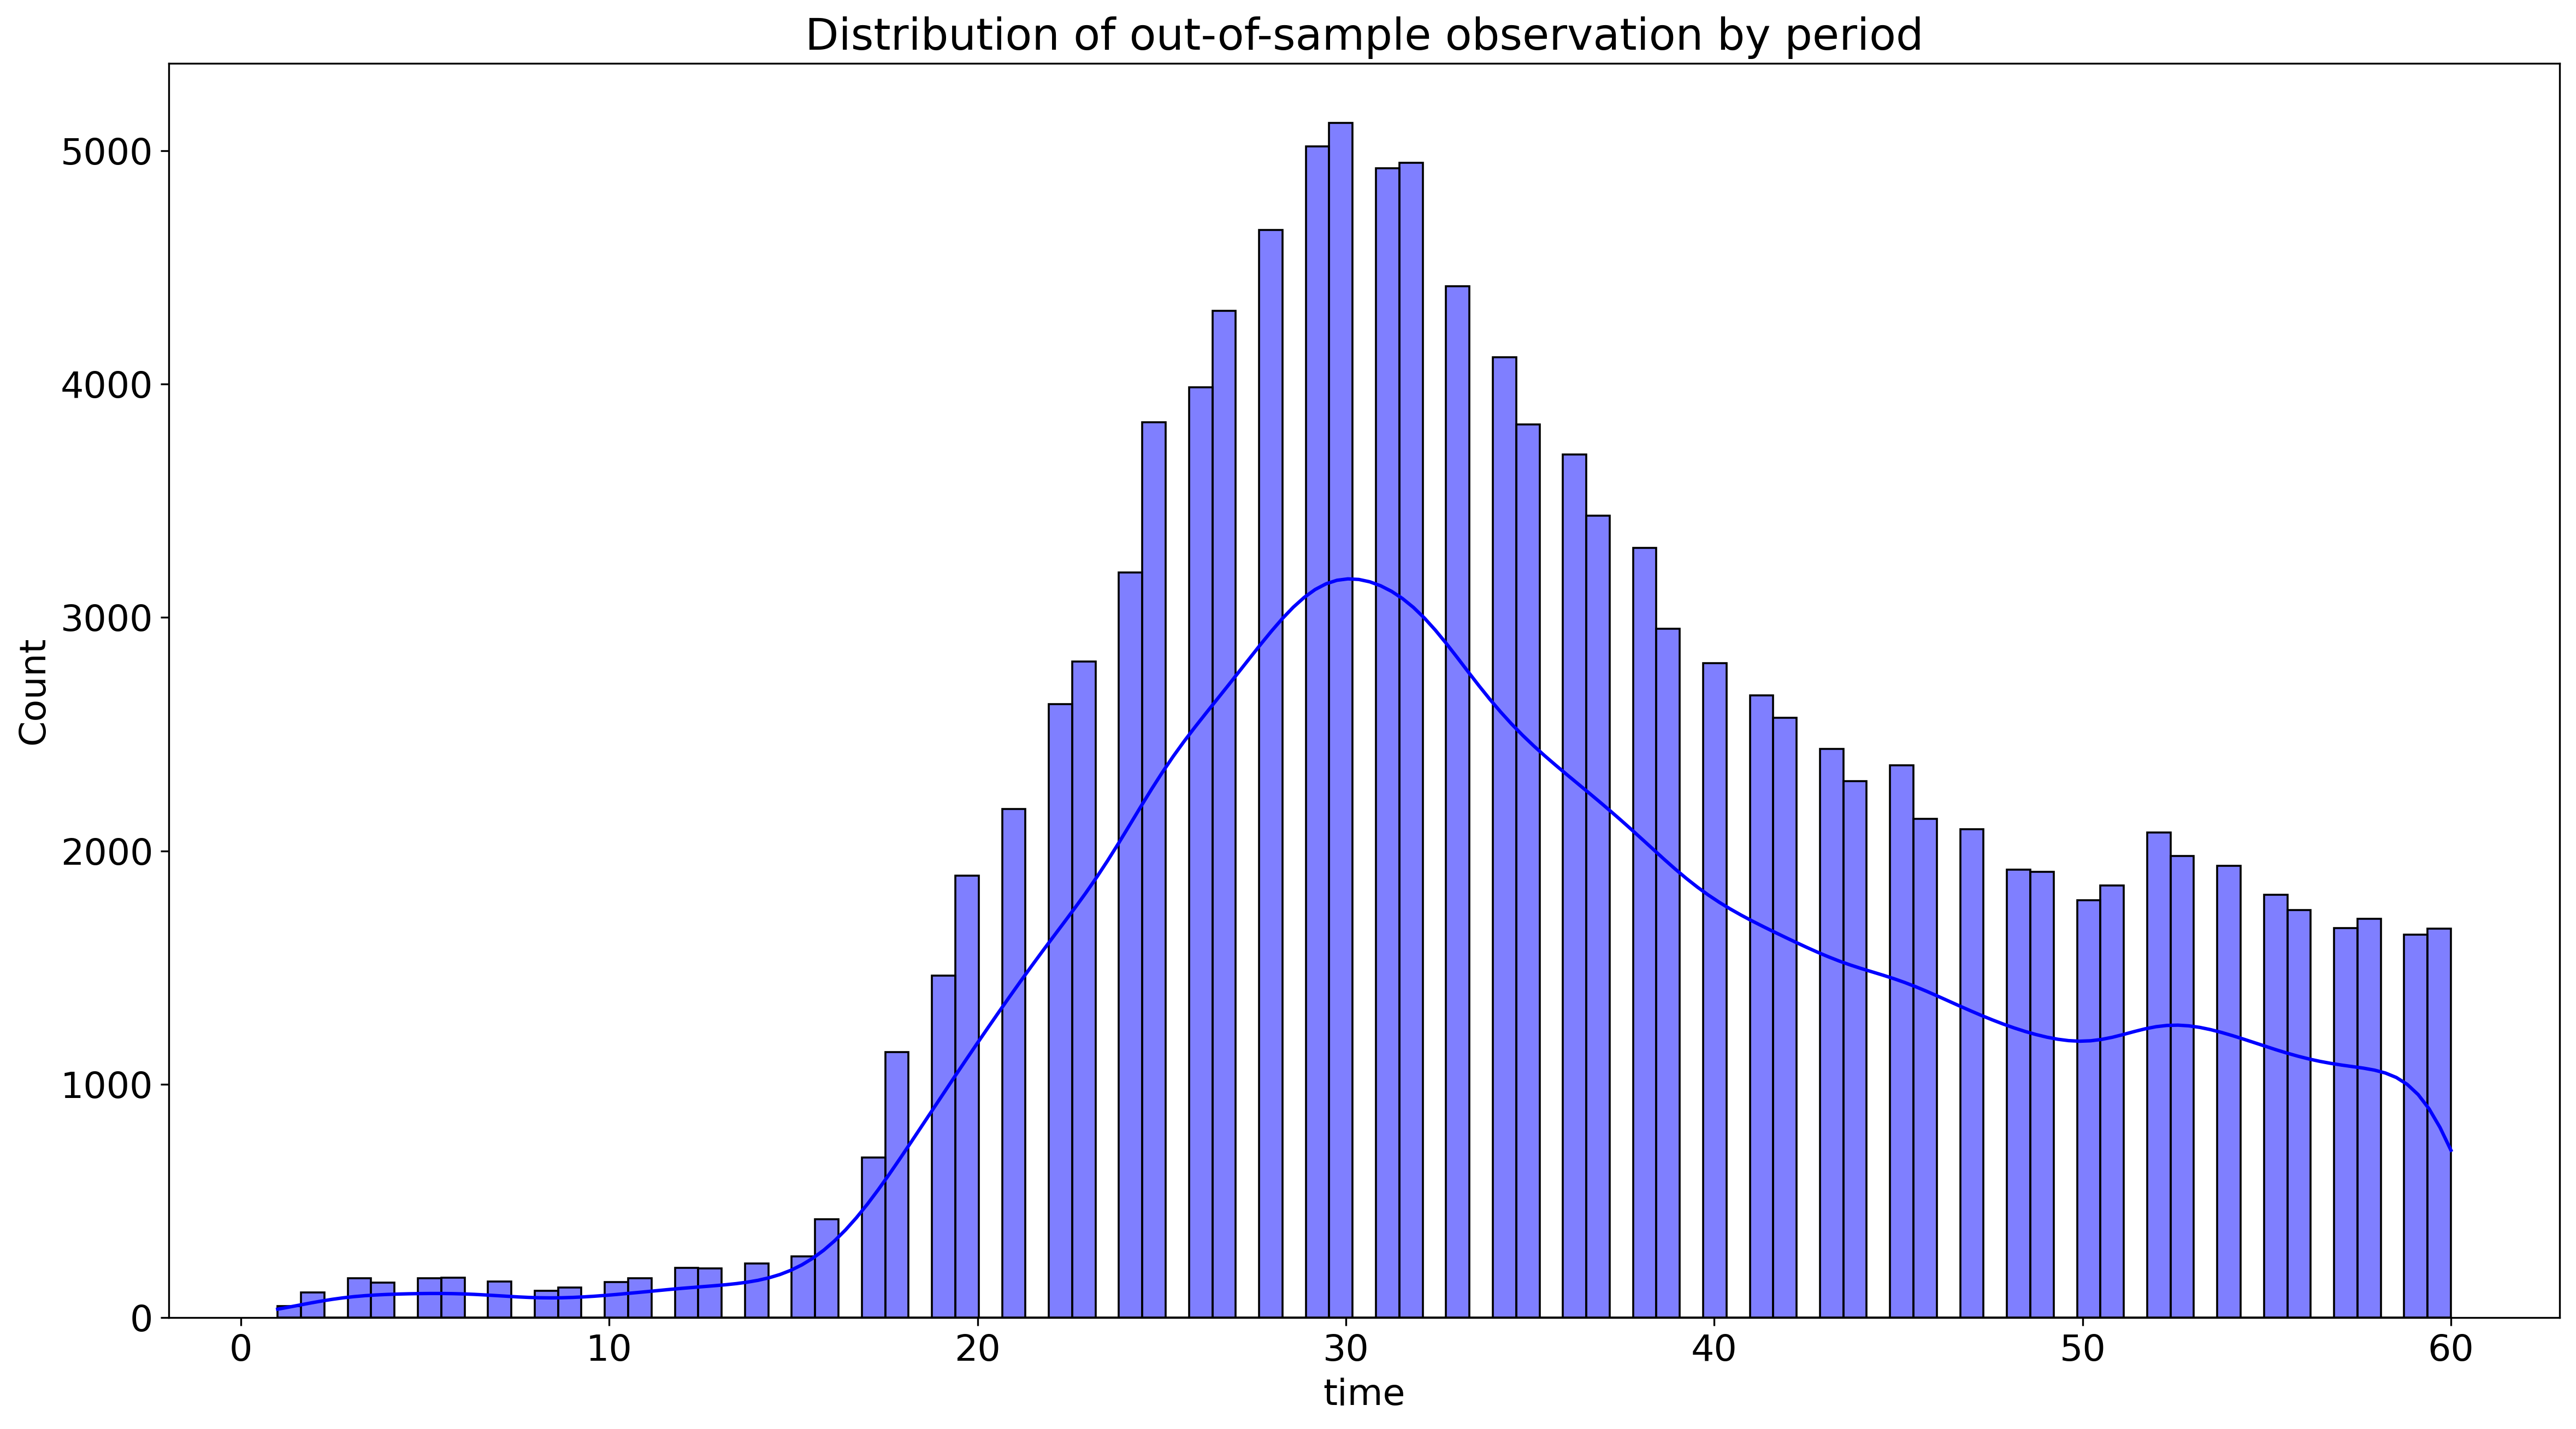

In [51]:
sns.histplot(lgbc_results['time'].values, kde=True, color='blue')
plt.title('Distribution of out-of-sample observation by period')
plt.xlabel('time')
plt.tight_layout()
plt.show()

We can see that there are lack of observations during the first 18 periods which results in inaccurate prediction of probability of default. As the number of observations increase, so does the accuracy (Look at the Time-Series Real-fit figures in section **1. Calculating aggregated forecast results** for more info).  

**THE END!!!**